In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn import preprocessing
from numpy import mean
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Import data and preprocess

Create separate dataframes for each year of output since 2017. The final model can then learn off of 5 years of data before making its predictions for 2022. 
#### Let's get this shit

In [4]:
rb_fp = pd.read_csv('rb_fantasy3.csv')
wr_fp = pd.read_csv('wr_fantasy3.csv')
te_fp = pd.read_csv('te_fantasy3.csv')
fp_df = rb_fp.append(wr_fp.append(te_fp))
fp_df

,Full Name,Position,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Fantasy Points Per Game (2021),Games (2014),Games (2015),Games (2016),Games (2017),Games (2018),Games (2019),Games (2020),Games (2021)
0,A.J. Dillon,RB,24.1,-,-,-,-,-,-,3.6636,10.9176,-,-,-,-,-,-,11,17
1,Aaron Jones,RB,27.5,-,-,-,8,14.3,19.7,18.4929,15.2667,-,-,-,10,12,16,14,15
2,Aaron Ripkowski,RB,29.4,-,2.8,4.7,1.1,-,-,-,-,-,1,10,11,-,-,-,-
3,Adrian Peterson,RB,37.2,11.3,16.3,3,7.9,11.8,9.8,7.7812,6.65,1,16,3,10,16,15,16,4
4,Ahmad Bradshaw,RB,36.2,15.4,7.1,-,-,-,-,-,-,10,6,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,Zach Ertz,TE,31.5,9,11.4,13.1,14.5,17.5,14.2,7.0455,10.6294,16,15,14,14,16,15,11,17
301,Zach Gentry,TE,25.7,-,-,-,-,-,1.4,0,2.1,-,-,-,-,-,1,2,17
302,Zach Miller,TE,37.6,-,8.3,12,7,-,-,-,-,-,13,10,8,-,-,-,-
303,Zach Miller,TE,36.5,4.5,-,-,-,-,-,-,-,3,-,-,-,-,-,-,-


In [5]:
fp_df['rb?'] = np.where(fp_df['Position'] == 'RB',1,0)
fp_df['wr?'] = np.where(fp_df['Position'] == 'WR',1,0)
fp_df['te?'] = np.where(fp_df['Position'] == 'TE',1,0)
fp_df

,Full Name,Position,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),...,Games (2015),Games (2016),Games (2017),Games (2018),Games (2019),Games (2020),Games (2021),rb?,wr?,te?
0,A.J. Dillon,RB,24.1,-,-,-,-,-,-,3.6636,...,-,-,-,-,-,11,17,1,0,0
1,Aaron Jones,RB,27.5,-,-,-,8,14.3,19.7,18.4929,...,-,-,10,12,16,14,15,1,0,0
2,Aaron Ripkowski,RB,29.4,-,2.8,4.7,1.1,-,-,-,...,1,10,11,-,-,-,-,1,0,0
3,Adrian Peterson,RB,37.2,11.3,16.3,3,7.9,11.8,9.8,7.7812,...,16,3,10,16,15,16,4,1,0,0
4,Ahmad Bradshaw,RB,36.2,15.4,7.1,-,-,-,-,-,...,6,-,-,-,-,-,-,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,Zach Ertz,TE,31.5,9,11.4,13.1,14.5,17.5,14.2,7.0455,...,15,14,14,16,15,11,17,0,0,1
301,Zach Gentry,TE,25.7,-,-,-,-,-,1.4,0,...,-,-,-,-,1,2,17,0,0,1
302,Zach Miller,TE,37.6,-,8.3,12,7,-,-,-,...,13,10,8,-,-,-,-,0,0,1
303,Zach Miller,TE,36.5,4.5,-,-,-,-,-,-,...,-,-,-,-,-,-,-,0,0,1


In [6]:
fp_clean = fp_df.replace('-',np.nan).set_index('Full Name').drop(columns=['Position'])
fp_final_df = fp_clean.apply(lambda x: pd.to_numeric(x))
fp_final_df

,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Fantasy Points Per Game (2021),Games (2014),Games (2015),Games (2016),Games (2017),Games (2018),Games (2019),Games (2020),Games (2021),rb?,wr?,te?
Full Name,,,,,,,,,,,,,,,,,,,,
A.J. Dillon,24.1,NaN,NaN,NaN,NaN,NaN,NaN,3.6636,10.9176,NaN,NaN,NaN,NaN,NaN,NaN,11.0,17.0,1,0,0
Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,18.4929,15.2667,NaN,NaN,NaN,10.0,12.0,16.0,14.0,15.0,1,0,0
Aaron Ripkowski,29.4,NaN,2.8,4.7,1.1,NaN,NaN,NaN,NaN,NaN,1.0,10.0,11.0,NaN,NaN,NaN,NaN,1,0,0
Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,7.7812,6.6500,1.0,16.0,3.0,10.0,16.0,15.0,16.0,4.0,1,0,0
Ahmad Bradshaw,36.2,15.4,7.1,NaN,NaN,NaN,NaN,NaN,NaN,10.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,7.0455,10.6294,16.0,15.0,14.0,14.0,16.0,15.0,11.0,17.0,0,0,1
Zach Gentry,25.7,NaN,NaN,NaN,NaN,NaN,1.4,0.0000,2.1000,NaN,NaN,NaN,NaN,NaN,1.0,2.0,17.0,0,0,1
Zach Miller,37.6,NaN,8.3,12.0,7.0,NaN,NaN,NaN,NaN,NaN,13.0,10.0,8.0,NaN,NaN,NaN,NaN,0,0,1


In [7]:
fp_final_df['fpts_2014'] = fp_final_df['Fantasy Points Per Game (2014)'] * fp_final_df['Games (2014)']
fp_final_df['fpts_2015'] = fp_final_df['Fantasy Points Per Game (2015)'] * fp_final_df['Games (2015)']
fp_final_df['fpts_2016'] = fp_final_df['Fantasy Points Per Game (2016)'] * fp_final_df['Games (2016)']
fp_final_df['fpts_2017'] = fp_final_df['Fantasy Points Per Game (2017)'] * fp_final_df['Games (2017)']
fp_final_df['fpts_2018'] = fp_final_df['Fantasy Points Per Game (2018)'] * fp_final_df['Games (2018)']
fp_final_df['fpts_2019'] = fp_final_df['Fantasy Points Per Game (2019)'] * fp_final_df['Games (2019)']
fp_final_df['fpts_2020'] = fp_final_df['Fantasy Points Per Game (2020)'] * fp_final_df['Games (2020)']
fp_final_df['fpts_2021'] = fp_final_df['Fantasy Points Per Game (2021)'] * fp_final_df['Games (2021)']
fp_final_df.reset_index()

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Fantasy Points Per Game (2021),...,wr?,te?,fpts_2014,fpts_2015,fpts_2016,fpts_2017,fpts_2018,fpts_2019,fpts_2020,fpts_2021
0,A.J. Dillon,24.1,NaN,NaN,NaN,NaN,NaN,NaN,3.6636,10.9176,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,40.2996,185.5992
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,18.4929,15.2667,...,0,0,NaN,NaN,NaN,80.0,171.6,315.2,258.9006,229.0005
2,Aaron Ripkowski,29.4,NaN,2.8,4.7,1.1,NaN,NaN,NaN,NaN,...,0,0,NaN,2.8,47.0,12.1,NaN,NaN,NaN,NaN
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,7.7812,6.6500,...,0,0,11.3,260.8,9.0,79.0,188.8,147.0,124.4992,26.6000
4,Ahmad Bradshaw,36.2,15.4,7.1,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,154.0,42.6,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1293,Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,7.0455,10.6294,...,0,1,144.0,171.0,183.4,203.0,280.0,213.0,77.5005,180.6998
1294,Zach Gentry,25.7,NaN,NaN,NaN,NaN,NaN,1.4,0.0000,2.1000,...,0,1,NaN,NaN,NaN,NaN,NaN,1.4,0.0000,35.7000
1295,Zach Miller,37.6,NaN,8.3,12.0,7.0,NaN,NaN,NaN,NaN,...,0,1,NaN,107.9,120.0,56.0,NaN,NaN,NaN,NaN
1296,Zach Miller,36.5,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,13.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
rb_dc = pd.read_csv('rb_dc.csv')
wr_dc = pd.read_csv('wr_dc.csv')
te_dc = pd.read_csv('te_dc.csv')

dc_df = rb_dc.append(wr_dc.append(te_dc))
dc_df

,Full Name,Position,Draft Pick,College Dominator Rating,Breakout Age
0,A.J. Dillon,RB,2.30,34.8%,19.3
1,Aaron Green,RB,Undrafted,18.7%,20.9
2,Aaron Jones,RB,5.39,47.0%,18.8
3,Aaron Ripkowski,RB,6.30,3.9%,-
4,Abram Smith,RB,Undrafted,25.5%,23
...,...,...,...,...,...
458,Xavier Grimble,TE,Undrafted,13.1%,-
459,Zach Ertz,TE,2.03,31.8%,21.8
460,Zach Gentry,TE,5.03,15.6%,-
461,Zach Miller,TE,2.06,18.1%,20.7


In [9]:
dc_df['cdr'] = dc_df['College Dominator Rating'].str.strip('%')
dc_df

,Full Name,Position,Draft Pick,College Dominator Rating,Breakout Age,cdr
0,A.J. Dillon,RB,2.30,34.8%,19.3,34.8
1,Aaron Green,RB,Undrafted,18.7%,20.9,18.7
2,Aaron Jones,RB,5.39,47.0%,18.8,47.0
3,Aaron Ripkowski,RB,6.30,3.9%,-,3.9
4,Abram Smith,RB,Undrafted,25.5%,23,25.5
...,...,...,...,...,...,...
458,Xavier Grimble,TE,Undrafted,13.1%,-,13.1
459,Zach Ertz,TE,2.03,31.8%,21.8,31.8
460,Zach Gentry,TE,5.03,15.6%,-,15.6
461,Zach Miller,TE,2.06,18.1%,20.7,18.1


In [10]:
dc_df['drafted'] = np.where(dc_df['Draft Pick'] != 'Undrafted', 1, 0)
dc_df

,Full Name,Position,Draft Pick,College Dominator Rating,Breakout Age,cdr,drafted
0,A.J. Dillon,RB,2.30,34.8%,19.3,34.8,1
1,Aaron Green,RB,Undrafted,18.7%,20.9,18.7,0
2,Aaron Jones,RB,5.39,47.0%,18.8,47.0,1
3,Aaron Ripkowski,RB,6.30,3.9%,-,3.9,1
4,Abram Smith,RB,Undrafted,25.5%,23,25.5,0
...,...,...,...,...,...,...,...
458,Xavier Grimble,TE,Undrafted,13.1%,-,13.1,0
459,Zach Ertz,TE,2.03,31.8%,21.8,31.8,1
460,Zach Gentry,TE,5.03,15.6%,-,15.6,1
461,Zach Miller,TE,2.06,18.1%,20.7,18.1,1


In [11]:
dc_df_clean = dc_df[['Draft Pick','Breakout Age','cdr','drafted']].set_index(dc_df['Full Name']
                                                                            ).replace({'Undrafted':np.nan,
                                                                                    '-':np.nan,
                                                                                      'Supplemental (2nd)':2.50}
                                                                                     ).apply(lambda x: 
                                                                                             pd.to_numeric(x))
dc_df_final = dc_df_clean.reset_index()
dc_df_final

,Full Name,Draft Pick,Breakout Age,cdr,drafted
0,A.J. Dillon,2.30,19.3,34.8,1
1,Aaron Green,NaN,20.9,18.7,0
2,Aaron Jones,5.39,18.8,47.0,1
3,Aaron Ripkowski,6.30,NaN,3.9,1
4,Abram Smith,NaN,23.0,25.5,0
...,...,...,...,...,...
2272,Xavier Grimble,NaN,NaN,13.1,0
2273,Zach Ertz,2.03,21.8,31.8,1
2274,Zach Gentry,5.03,NaN,15.6,1
2275,Zach Miller,2.06,20.7,18.1,1


In [12]:
full_data = fp_final_df.merge(dc_df_final,on='Full Name',how='inner')
full_data

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Fantasy Points Per Game (2021),...,fpts_2016,fpts_2017,fpts_2018,fpts_2019,fpts_2020,fpts_2021,Draft Pick,Breakout Age,cdr,drafted
0,A.J. Dillon,24.1,NaN,NaN,NaN,NaN,NaN,NaN,3.6636,10.9176,...,NaN,NaN,NaN,NaN,40.2996,185.5992,2.30,19.3,34.8,1
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,18.4929,15.2667,...,NaN,80.0,171.6,315.2,258.9006,229.0005,5.39,18.8,47.0,1
2,Aaron Ripkowski,29.4,NaN,2.8,4.7,1.1,NaN,NaN,NaN,NaN,...,47.0,12.1,NaN,NaN,NaN,NaN,6.30,NaN,3.9,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,7.7812,6.6500,...,9.0,79.0,188.8,147.0,124.4992,26.6000,1.07,19.5,42.7,1
4,Ahmad Bradshaw,36.2,15.4,7.1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.40,18.5,46.3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,7.0455,10.6294,...,183.4,203.0,280.0,213.0,77.5005,180.6998,2.03,21.8,31.8,1
1252,Zach Gentry,25.7,NaN,NaN,NaN,NaN,NaN,1.4,0.0000,2.1000,...,NaN,NaN,NaN,1.4,0.0000,35.7000,5.03,NaN,15.6,1
1253,Zach Miller,37.6,NaN,8.3,12.0,7.0,NaN,NaN,NaN,NaN,...,120.0,56.0,NaN,NaN,NaN,NaN,2.06,20.7,18.1,1
1254,Zach Miller,36.5,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.06,20.7,18.1,1


In [13]:
full_data.columns

Index(['Full Name', 'Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)',
       'Fantasy Points Per Game (2017)', 'Fantasy Points Per Game (2018)',
       'Fantasy Points Per Game (2019)', 'Fantasy Points Per Game (2020)',
       'Fantasy Points Per Game (2021)', 'Games (2014)', 'Games (2015)',
       'Games (2016)', 'Games (2017)', 'Games (2018)', 'Games (2019)',
       'Games (2020)', 'Games (2021)', 'rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016', 'fpts_2017', 'fpts_2018', 'fpts_2019',
       'fpts_2020', 'fpts_2021', 'Draft Pick', 'Breakout Age', 'cdr',
       'drafted'],
      dtype='object')

In [14]:
final_data = pd.DataFrame()
final_data_id = pd.DataFrame()

### 2017 predictions

In [15]:
fp_2017 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2017)'])
fp_2017

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Games (2014),Games (2015),Games (2016),rb?,wr?,te?,fpts_2014,fpts_2015,fpts_2016,fpts_2017,Draft Pick,Breakout Age,cdr,drafted
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,NaN,NaN,NaN,1,0,0,NaN,NaN,NaN,80.0,5.39,18.8,47.0,1
2,Aaron Ripkowski,29.4,NaN,2.8,4.7,1.1,NaN,1.0,10.0,1,0,0,NaN,2.8,47.0,12.1,6.30,NaN,3.9,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,1.0,16.0,3.0,1,0,0,11.3,260.8,9.0,79.0,1.07,19.5,42.7,1
5,Akeem Hunt,29.3,NaN,2.8,2.1,0.7,NaN,7.0,8.0,1,0,0,NaN,19.6,16.8,9.8,NaN,20.5,27.1,0
7,Alex Armah,28.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1,0,0,NaN,NaN,NaN,0.0,6.08,NaN,3.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,Virgil Green,33.8,3.9,3.2,5.2,3.6,5.0,11.0,10.0,0,0,1,19.5,35.2,52.0,39.6,7.01,21.1,19.5,1
1249,Will Tye,30.6,NaN,8.0,5.8,3.9,NaN,13.0,16.0,0,0,1,NaN,104.0,92.8,7.8,NaN,21.8,36.1,0
1250,Xavier Grimble,29.7,NaN,NaN,4.3,2.4,NaN,NaN,8.0,0,0,1,NaN,NaN,34.4,14.4,NaN,NaN,13.1,0
1251,Zach Ertz,31.5,9.0,11.4,13.1,14.5,16.0,15.0,14.0,0,0,1,144.0,171.0,183.4,203.0,2.03,21.8,31.8,1


In [16]:
fp_2017['y'] = np.where(fp_2017['fpts_2017'] > 200,1,0)
fp_2017['y'].value_counts()

0    438
1     33
Name: y, dtype: int64

In [17]:
fpts_df_2017 = fp_2017[['fpts_2014','fpts_2015', 'fpts_2016']]

In [18]:
injury_df_2017 = fp_2017[['Games (2014)','Games (2015)','Games (2016)']]

In [19]:
fppg_df_2017 = fp_2017[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)']]

In [20]:
df_2017 = fp_2017[['y','rb?','te?']]
df_2017

,y,rb?,te?
1,0,1,0
2,0,1,0
3,0,1,0
5,0,1,0
7,0,1,0
...,...,...,...
1247,0,0,1
1249,0,0,1
1250,0,0,1
1251,1,0,1


In [21]:
df_2017['age'] = fp_2017['Age'] - 5
df_2017

,y,rb?,te?,age
1,0,1,0,22.5
2,0,1,0,24.4
3,0,1,0,32.2
5,0,1,0,24.3
7,0,1,0,23.0
...,...,...,...,...
1247,0,0,1,28.8
1249,0,0,1,25.6
1250,0,0,1,24.7
1251,1,0,1,26.5


In [22]:
df_2017['max_pts'] = fpts_df_2017.max(axis=1)
df_2017

,y,rb?,te?,age,max_pts
1,0,1,0,22.5,NaN
2,0,1,0,24.4,47.0
3,0,1,0,32.2,260.8
5,0,1,0,24.3,19.6
7,0,1,0,23.0,NaN
...,...,...,...,...,...
1247,0,0,1,28.8,52.0
1249,0,0,1,25.6,104.0
1250,0,0,1,24.7,34.4
1251,1,0,1,26.5,183.4


In [23]:
df_2017['avg_pts'] = fpts_df_2017.mean(axis=1)
df_2017

,y,rb?,te?,age,max_pts,avg_pts
1,0,1,0,22.5,NaN,NaN
2,0,1,0,24.4,47.0,24.900000
3,0,1,0,32.2,260.8,93.700000
5,0,1,0,24.3,19.6,18.200000
7,0,1,0,23.0,NaN,NaN
...,...,...,...,...,...,...
1247,0,0,1,28.8,52.0,35.566667
1249,0,0,1,25.6,104.0,98.400000
1250,0,0,1,24.7,34.4,34.400000
1251,1,0,1,26.5,183.4,166.133333


In [24]:
df_2017['last_pts'] = fpts_df_2017['fpts_2016']
df_2017

,y,rb?,te?,age,max_pts,avg_pts,last_pts
1,0,1,0,22.5,NaN,NaN,NaN
2,0,1,0,24.4,47.0,24.900000,47.0
3,0,1,0,32.2,260.8,93.700000,9.0
5,0,1,0,24.3,19.6,18.200000,16.8
7,0,1,0,23.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1247,0,0,1,28.8,52.0,35.566667,52.0
1249,0,0,1,25.6,104.0,98.400000,92.8
1250,0,0,1,24.7,34.4,34.400000,34.4
1251,1,0,1,26.5,183.4,166.133333,183.4


In [25]:
df_2017['3_yr_trail_avg_fppg'] = fppg_df_2017.mean(axis=1)
df_2017

,y,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg
1,0,1,0,22.5,NaN,NaN,NaN,NaN
2,0,1,0,24.4,47.0,24.900000,47.0,3.750000
3,0,1,0,32.2,260.8,93.700000,9.0,10.200000
5,0,1,0,24.3,19.6,18.200000,16.8,2.450000
7,0,1,0,23.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1247,0,0,1,28.8,52.0,35.566667,52.0,4.100000
1249,0,0,1,25.6,104.0,98.400000,92.8,6.900000
1250,0,0,1,24.7,34.4,34.400000,34.4,4.300000
1251,1,0,1,26.5,183.4,166.133333,183.4,11.166667


In [26]:
df_2017['injury_risk'] = injury_df_2017.sum(axis = 1) / (injury_df_2017.count(axis=1)*16)
df_2017

,y,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk
1,0,1,0,22.5,NaN,NaN,NaN,NaN,NaN
2,0,1,0,24.4,47.0,24.900000,47.0,3.750000,0.343750
3,0,1,0,32.2,260.8,93.700000,9.0,10.200000,0.416667
5,0,1,0,24.3,19.6,18.200000,16.8,2.450000,0.468750
7,0,1,0,23.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1247,0,0,1,28.8,52.0,35.566667,52.0,4.100000,0.541667
1249,0,0,1,25.6,104.0,98.400000,92.8,6.900000,0.906250
1250,0,0,1,24.7,34.4,34.400000,34.4,4.300000,0.500000
1251,1,0,1,26.5,183.4,166.133333,183.4,11.166667,0.937500


In [27]:
df_2017['last_yr_games_played'] = injury_df_2017['Games (2016)']
df_2017

,y,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played
1,0,1,0,22.5,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1,0,24.4,47.0,24.900000,47.0,3.750000,0.343750,10.0
3,0,1,0,32.2,260.8,93.700000,9.0,10.200000,0.416667,3.0
5,0,1,0,24.3,19.6,18.200000,16.8,2.450000,0.468750,8.0
7,0,1,0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1247,0,0,1,28.8,52.0,35.566667,52.0,4.100000,0.541667,10.0
1249,0,0,1,25.6,104.0,98.400000,92.8,6.900000,0.906250,16.0
1250,0,0,1,24.7,34.4,34.400000,34.4,4.300000,0.500000,8.0
1251,1,0,1,26.5,183.4,166.133333,183.4,11.166667,0.937500,14.0


In [28]:
df_2017['hit_rate'] = fpts_df_2017[fpts_df_2017 > 200].count(axis = 1) / fpts_df_2017.count(axis=1)
df_2017

,y,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate
1,0,1,0,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1,0,24.4,47.0,24.900000,47.0,3.750000,0.343750,10.0,0.000000
3,0,1,0,32.2,260.8,93.700000,9.0,10.200000,0.416667,3.0,0.333333
5,0,1,0,24.3,19.6,18.200000,16.8,2.450000,0.468750,8.0,0.000000
7,0,1,0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1247,0,0,1,28.8,52.0,35.566667,52.0,4.100000,0.541667,10.0,0.000000
1249,0,0,1,25.6,104.0,98.400000,92.8,6.900000,0.906250,16.0,0.000000
1250,0,0,1,24.7,34.4,34.400000,34.4,4.300000,0.500000,8.0,0.000000
1251,1,0,1,26.5,183.4,166.133333,183.4,11.166667,0.937500,14.0,0.000000


In [29]:
df_2017['Draft Pick'] = fp_2017['Draft Pick']
df_2017['Breakout Age'] = fp_2017['Breakout Age']
df_2017['cdr'] = fp_2017['cdr']
df_2017

,y,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate,Draft Pick,Breakout Age,cdr
1,0,1,0,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.39,18.8,47.0
2,0,1,0,24.4,47.0,24.900000,47.0,3.750000,0.343750,10.0,0.000000,6.30,NaN,3.9
3,0,1,0,32.2,260.8,93.700000,9.0,10.200000,0.416667,3.0,0.333333,1.07,19.5,42.7
5,0,1,0,24.3,19.6,18.200000,16.8,2.450000,0.468750,8.0,0.000000,NaN,20.5,27.1
7,0,1,0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.08,NaN,3.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,0,0,1,28.8,52.0,35.566667,52.0,4.100000,0.541667,10.0,0.000000,7.01,21.1,19.5
1249,0,0,1,25.6,104.0,98.400000,92.8,6.900000,0.906250,16.0,0.000000,NaN,21.8,36.1
1250,0,0,1,24.7,34.4,34.400000,34.4,4.300000,0.500000,8.0,0.000000,NaN,NaN,13.1
1251,1,0,1,26.5,183.4,166.133333,183.4,11.166667,0.937500,14.0,0.000000,2.03,21.8,31.8


In [30]:
df_2017_id = df_2017.copy()
df_2017_id['id'] = fp_2017['Full Name']
df_2017_id['year'] = 2017
df_2017_id

,y,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate,Draft Pick,Breakout Age,cdr,id,year
1,0,1,0,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.39,18.8,47.0,Aaron Jones,2017
2,0,1,0,24.4,47.0,24.900000,47.0,3.750000,0.343750,10.0,0.000000,6.30,NaN,3.9,Aaron Ripkowski,2017
3,0,1,0,32.2,260.8,93.700000,9.0,10.200000,0.416667,3.0,0.333333,1.07,19.5,42.7,Adrian Peterson,2017
5,0,1,0,24.3,19.6,18.200000,16.8,2.450000,0.468750,8.0,0.000000,NaN,20.5,27.1,Akeem Hunt,2017
7,0,1,0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.08,NaN,3.2,Alex Armah,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,0,0,1,28.8,52.0,35.566667,52.0,4.100000,0.541667,10.0,0.000000,7.01,21.1,19.5,Virgil Green,2017
1249,0,0,1,25.6,104.0,98.400000,92.8,6.900000,0.906250,16.0,0.000000,NaN,21.8,36.1,Will Tye,2017
1250,0,0,1,24.7,34.4,34.400000,34.4,4.300000,0.500000,8.0,0.000000,NaN,NaN,13.1,Xavier Grimble,2017
1251,1,0,1,26.5,183.4,166.133333,183.4,11.166667,0.937500,14.0,0.000000,2.03,21.8,31.8,Zach Ertz,2017


In [31]:
final_data = final_data.append(df_2017)
final_data

,y,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate,Draft Pick,Breakout Age,cdr
1,0,1,0,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.39,18.8,47.0
2,0,1,0,24.4,47.0,24.900000,47.0,3.750000,0.343750,10.0,0.000000,6.30,NaN,3.9
3,0,1,0,32.2,260.8,93.700000,9.0,10.200000,0.416667,3.0,0.333333,1.07,19.5,42.7
5,0,1,0,24.3,19.6,18.200000,16.8,2.450000,0.468750,8.0,0.000000,NaN,20.5,27.1
7,0,1,0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.08,NaN,3.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,0,0,1,28.8,52.0,35.566667,52.0,4.100000,0.541667,10.0,0.000000,7.01,21.1,19.5
1249,0,0,1,25.6,104.0,98.400000,92.8,6.900000,0.906250,16.0,0.000000,NaN,21.8,36.1
1250,0,0,1,24.7,34.4,34.400000,34.4,4.300000,0.500000,8.0,0.000000,NaN,NaN,13.1
1251,1,0,1,26.5,183.4,166.133333,183.4,11.166667,0.937500,14.0,0.000000,2.03,21.8,31.8


In [32]:
final_data_id = final_data_id.append(df_2017_id)
final_data_id

,y,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate,Draft Pick,Breakout Age,cdr,id,year
1,0,1,0,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.39,18.8,47.0,Aaron Jones,2017
2,0,1,0,24.4,47.0,24.900000,47.0,3.750000,0.343750,10.0,0.000000,6.30,NaN,3.9,Aaron Ripkowski,2017
3,0,1,0,32.2,260.8,93.700000,9.0,10.200000,0.416667,3.0,0.333333,1.07,19.5,42.7,Adrian Peterson,2017
5,0,1,0,24.3,19.6,18.200000,16.8,2.450000,0.468750,8.0,0.000000,NaN,20.5,27.1,Akeem Hunt,2017
7,0,1,0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.08,NaN,3.2,Alex Armah,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,0,0,1,28.8,52.0,35.566667,52.0,4.100000,0.541667,10.0,0.000000,7.01,21.1,19.5,Virgil Green,2017
1249,0,0,1,25.6,104.0,98.400000,92.8,6.900000,0.906250,16.0,0.000000,NaN,21.8,36.1,Will Tye,2017
1250,0,0,1,24.7,34.4,34.400000,34.4,4.300000,0.500000,8.0,0.000000,NaN,NaN,13.1,Xavier Grimble,2017
1251,1,0,1,26.5,183.4,166.133333,183.4,11.166667,0.937500,14.0,0.000000,2.03,21.8,31.8,Zach Ertz,2017


### 2018

In [33]:
fp_2018 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2018)'])
fp_2018

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Games (2014),Games (2015),Games (2016),...,te?,fpts_2014,fpts_2015,fpts_2016,fpts_2017,fpts_2018,Draft Pick,Breakout Age,cdr,drafted
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,NaN,NaN,NaN,...,0,NaN,NaN,NaN,80.0,171.6,5.39,18.8,47.0,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,1.0,16.0,3.0,...,0,11.3,260.8,9.0,79.0,188.8,1.07,19.5,42.7,1
7,Alex Armah,28.0,NaN,NaN,NaN,0.0,1.9,NaN,NaN,NaN,...,0,NaN,NaN,NaN,0.0,15.2,6.08,NaN,3.2,1
8,Alex Collins,27.8,NaN,NaN,4.0,11.4,10.9,NaN,NaN,9.0,...,0,NaN,NaN,36.0,171.0,109.0,5.34,19.0,29.9,1
11,Alfred Blue,31.1,6.1,8.0,4.4,5.6,6.1,16.0,14.0,14.0,...,0,97.6,112.0,61.6,44.8,97.6,6.05,21.4,14.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,Vernon Davis,38.3,4.8,6.0,7.6,7.6,5.7,13.0,13.0,15.0,...,1,62.4,78.0,114.0,121.6,74.1,1.06,21.6,35.9,1
1247,Virgil Green,33.8,3.9,3.2,5.2,3.6,3.3,5.0,11.0,10.0,...,1,19.5,35.2,52.0,39.6,46.2,7.01,21.1,19.5,1
1248,Will Dissly,25.9,NaN,NaN,NaN,NaN,8.9,NaN,NaN,NaN,...,1,NaN,NaN,NaN,NaN,35.6,4.20,NaN,10.3,1
1250,Xavier Grimble,29.7,NaN,NaN,4.3,2.4,1.6,NaN,NaN,8.0,...,1,NaN,NaN,34.4,14.4,12.8,NaN,NaN,13.1,0


In [34]:
fp_2018['y'] = np.where(fp_2018['fpts_2018'] > 200,1,0)
fp_2018['y'].value_counts()

0    451
1     40
Name: y, dtype: int64

In [35]:
fpts_df_2018 = fp_2018[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017']]

injury_df_2018 = fp_2018[['Games (2014)','Games (2015)','Games (2016)','Games (2017)']]

fppg_df_2018 = fp_2018[['Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)']]

df_2018 = fp_2018[['y','rb?','te?']]


df_2018['age'] = fp_2018['Age'] - 4


df_2018['max_pts'] = fpts_df_2018.max(axis=1)


df_2018['avg_pts'] = fpts_df_2018.mean(axis=1)


df_2018['last_pts'] = fpts_df_2018['fpts_2017']


df_2018['3_yr_trail_avg_fppg'] = fppg_df_2018.mean(axis=1)


df_2018['injury_risk'] = injury_df_2018.sum(axis = 1) / (injury_df_2018.count(axis=1)*16)


df_2018['last_yr_games_played'] = injury_df_2018['Games (2017)']


df_2018['hit_rate'] = fpts_df_2018[fpts_df_2018 > 200].count(axis = 1) / fpts_df_2018.count(axis=1)


df_2018['Draft Pick'] = fp_2018['Draft Pick']
df_2018['Breakout Age'] = fp_2018['Breakout Age']
df_2018['cdr'] = fp_2018['cdr']

df_2018_id = df_2018.copy()
df_2018_id['id'] = fp_2018['Full Name']
df_2018_id['year'] = 2018
df_2018_id


final_data = final_data.append(df_2018)
final_data

final_data_id = final_data_id.append(df_2018_id)
final_data_id

,y,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate,Draft Pick,Breakout Age,cdr,id,year
1,0,1,0,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.39,18.8,47.0,Aaron Jones,2017
2,0,1,0,24.4,47.0,24.900,47.0,3.750000,0.343750,10.0,0.000000,6.30,NaN,3.9,Aaron Ripkowski,2017
3,0,1,0,32.2,260.8,93.700,9.0,10.200000,0.416667,3.0,0.333333,1.07,19.5,42.7,Adrian Peterson,2017
5,0,1,0,24.3,19.6,18.200,16.8,2.450000,0.468750,8.0,0.000000,NaN,20.5,27.1,Akeem Hunt,2017
7,0,1,0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.08,NaN,3.2,Alex Armah,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,0,0,1,34.3,121.6,94.000,121.6,7.066667,0.890625,16.0,0.000000,1.06,21.6,35.9,Vernon Davis,2018
1247,0,0,1,29.8,52.0,36.575,39.6,4.000000,0.578125,11.0,0.000000,7.01,21.1,19.5,Virgil Green,2018
1248,0,0,1,21.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.20,NaN,10.3,Will Dissly,2018
1250,0,0,1,25.7,34.4,24.400,14.4,3.350000,0.437500,6.0,0.000000,NaN,NaN,13.1,Xavier Grimble,2018


### 2019

In [36]:
fp_2019 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                     'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2019)'])
fp_2019

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Games (2014),Games (2015),...,fpts_2014,fpts_2015,fpts_2016,fpts_2017,fpts_2018,fpts_2019,Draft Pick,Breakout Age,cdr,drafted
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,NaN,NaN,...,NaN,NaN,NaN,80.0,171.6,315.2,5.39,18.8,47.0,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,1.0,16.0,...,11.3,260.8,9.0,79.0,188.8,147.0,1.07,19.5,42.7,1
6,Alec Ingold,25.9,NaN,NaN,NaN,NaN,NaN,1.6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.6,NaN,NaN,10.1,0
7,Alex Armah,28.0,NaN,NaN,NaN,0.0,1.9,1.2,NaN,NaN,...,NaN,NaN,NaN,0.0,15.2,9.6,6.08,NaN,3.2,1
9,Alexander Mattison,23.9,NaN,NaN,NaN,NaN,NaN,5.3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,68.9,3.38,19.2,28.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,Virgil Green,33.8,3.9,3.2,5.2,3.6,3.3,1.9,5.0,11.0,...,19.5,35.2,52.0,39.6,46.2,22.8,7.01,21.1,19.5,1
1248,Will Dissly,25.9,NaN,NaN,NaN,NaN,8.9,12.3,NaN,NaN,...,NaN,NaN,NaN,NaN,35.6,73.8,4.20,NaN,10.3,1
1250,Xavier Grimble,29.7,NaN,NaN,4.3,2.4,1.6,0.6,NaN,NaN,...,NaN,NaN,34.4,14.4,12.8,1.2,NaN,NaN,13.1,0
1251,Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,16.0,15.0,...,144.0,171.0,183.4,203.0,280.0,213.0,2.03,21.8,31.8,1


In [37]:
fp_2019['y'] = np.where(fp_2019['fpts_2019'] > 200,1,0)
fp_2019['y'].value_counts()

0    439
1     46
Name: y, dtype: int64

In [38]:
fpts_df_2019 = fp_2019[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018']]

injury_df_2019 = fp_2019[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)']]

fppg_df_2019 = fp_2019[['Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)']]

df_2019 = fp_2019[['y','rb?','te?']]


df_2019['age'] = fp_2019['Age'] - 3


df_2019['max_pts'] = fpts_df_2019.max(axis=1)


df_2019['avg_pts'] = fpts_df_2019.mean(axis=1)


df_2019['last_pts'] = fpts_df_2019['fpts_2018']


df_2019['3_yr_trail_avg_fppg'] = fppg_df_2019.mean(axis=1)


df_2019['injury_risk'] = injury_df_2019.sum(axis = 1) / (injury_df_2019.count(axis=1)*16)


df_2019['last_yr_games_played'] = injury_df_2019['Games (2018)']


df_2019['hit_rate'] = fpts_df_2019[fpts_df_2019 > 200].count(axis = 1) / fpts_df_2019.count(axis=1)


df_2019['Draft Pick'] = fp_2019['Draft Pick']
df_2019['Breakout Age'] = fp_2019['Breakout Age']
df_2019['cdr'] = fp_2019['cdr']

df_2019_id = df_2019.copy()
df_2019_id['id'] = fp_2019['Full Name']
df_2019_id['year'] = 2019
df_2019_id


final_data = final_data.append(df_2019)
final_data

final_data_id = final_data_id.append(df_2019_id)
final_data_id

,y,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate,Draft Pick,Breakout Age,cdr,id,year
1,0,1,0,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.39,18.8,47.0,Aaron Jones,2017
2,0,1,0,24.4,47.0,24.900000,47.0,3.750000,0.343750,10.0,0.000000,6.30,NaN,3.9,Aaron Ripkowski,2017
3,0,1,0,32.2,260.8,93.700000,9.0,10.200000,0.416667,3.0,0.333333,1.07,19.5,42.7,Adrian Peterson,2017
5,0,1,0,24.3,19.6,18.200000,16.8,2.450000,0.468750,8.0,0.000000,NaN,20.5,27.1,Akeem Hunt,2017
7,0,1,0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.08,NaN,3.2,Alex Armah,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,0,0,1,30.8,52.0,38.500000,46.2,4.033333,0.637500,14.0,0.000000,7.01,21.1,19.5,Virgil Green,2019
1248,0,0,1,22.9,35.6,35.600000,35.6,8.900000,0.250000,4.0,0.000000,4.20,NaN,10.3,Will Dissly,2019
1250,0,0,1,26.7,34.4,20.533333,12.8,2.766667,0.458333,8.0,0.000000,NaN,NaN,13.1,Xavier Grimble,2019
1251,1,0,1,28.5,280.0,196.280000,280.0,15.033333,0.937500,16.0,0.400000,2.03,21.8,31.8,Zach Ertz,2019


### 2020

In [39]:
fp_2020 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                     'Fantasy Points Per Game (2020)',
                     'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2020)'])
fp_2020

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Games (2014),...,fpts_2015,fpts_2016,fpts_2017,fpts_2018,fpts_2019,fpts_2020,Draft Pick,Breakout Age,cdr,drafted
0,A.J. Dillon,24.1,NaN,NaN,NaN,NaN,NaN,NaN,3.6636,NaN,...,NaN,NaN,NaN,NaN,NaN,40.2996,2.30,19.3,34.8,1
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,18.4929,NaN,...,NaN,NaN,80.0,171.6,315.2,258.9006,5.39,18.8,47.0,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,7.7812,1.0,...,260.8,9.0,79.0,188.8,147.0,124.4992,1.07,19.5,42.7,1
6,Alec Ingold,25.9,NaN,NaN,NaN,NaN,NaN,1.6,2.7000,NaN,...,NaN,NaN,NaN,NaN,17.6,29.7000,NaN,NaN,10.1,0
7,Alex Armah,28.0,NaN,NaN,NaN,0.0,1.9,1.2,0.6000,NaN,...,NaN,NaN,0.0,15.2,9.6,7.2000,6.08,NaN,3.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,Vance McDonald,32.0,0.8,5.8,8.7,4.3,8.9,6.0,1.7786,4.0,...,81.2,87.0,38.7,133.5,84.0,24.9004,2.23,20.2,26.6,1
1247,Virgil Green,33.8,3.9,3.2,5.2,3.6,3.3,1.9,2.3333,5.0,...,35.2,52.0,39.6,46.2,22.8,13.9998,7.01,21.1,19.5,1
1248,Will Dissly,25.9,NaN,NaN,NaN,NaN,8.9,12.3,3.8188,NaN,...,NaN,NaN,NaN,35.6,73.8,61.1008,4.20,NaN,10.3,1
1251,Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,7.0455,16.0,...,171.0,183.4,203.0,280.0,213.0,77.5005,2.03,21.8,31.8,1


In [40]:
fp_2020['y'] = np.where(fp_2020['fpts_2020'] > 200,1,0)
fp_2020['y'].value_counts()

0    500
1     43
Name: y, dtype: int64

In [41]:
fpts_df_2020 = fp_2020[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019']]

injury_df_2020 = fp_2020[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)','Games (2019)']]

fppg_df_2020 = fp_2020[['Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)']]

df_2020 = fp_2020[['y','rb?','te?']]


df_2020['age'] = fp_2020['Age'] - 2


df_2020['max_pts'] = fpts_df_2020.max(axis=1)


df_2020['avg_pts'] = fpts_df_2020.mean(axis=1)


df_2020['last_pts'] = fpts_df_2020['fpts_2019']


df_2020['3_yr_trail_avg_fppg'] = fppg_df_2020.mean(axis=1)


df_2020['injury_risk'] = injury_df_2020.sum(axis = 1) / (injury_df_2020.count(axis=1)*16)


df_2020['last_yr_games_played'] = injury_df_2020['Games (2019)']


df_2020['hit_rate'] = fpts_df_2020[fpts_df_2020 > 200].count(axis = 1) / fpts_df_2020.count(axis=1)


df_2020['Draft Pick'] = fp_2020['Draft Pick']
df_2020['Breakout Age'] = fp_2020['Breakout Age']
df_2020['cdr'] = fp_2020['cdr']

df_2020_id = df_2020.copy()
df_2020_id['id'] = fp_2020['Full Name']
df_2020_id['year'] = 2020
df_2020_id

final_data = final_data.append(df_2020)
final_data

final_data_id = final_data_id.append(df_2020_id)
final_data_id

,y,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate,Draft Pick,Breakout Age,cdr,id,year
1,0,1,0,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.39,18.8,47.0,Aaron Jones,2017
2,0,1,0,24.4,47.0,24.900000,47.0,3.750000,0.343750,10.0,0.000000,6.30,NaN,3.9,Aaron Ripkowski,2017
3,0,1,0,32.2,260.8,93.700000,9.0,10.200000,0.416667,3.0,0.333333,1.07,19.5,42.7,Adrian Peterson,2017
5,0,1,0,24.3,19.6,18.200000,16.8,2.450000,0.468750,8.0,0.000000,NaN,20.5,27.1,Akeem Hunt,2017
7,0,1,0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.08,NaN,3.2,Alex Armah,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,0,0,1,30.0,133.5,71.266667,84.0,6.400000,0.687500,14.0,0.000000,2.23,20.2,26.6,Vance McDonald,2020
1247,0,0,1,31.8,52.0,35.883333,22.8,2.933333,0.656250,12.0,0.000000,7.01,21.1,19.5,Virgil Green,2020
1248,0,0,1,23.9,73.8,54.700000,73.8,10.600000,0.312500,6.0,0.000000,4.20,NaN,10.3,Will Dissly,2020
1251,0,0,1,29.5,280.0,199.066667,213.0,15.400000,0.937500,15.0,0.500000,2.03,21.8,31.8,Zach Ertz,2020


### 2021

In [42]:
fp_2021 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                     'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)',
                     'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','Games (2019)','Games (2020)',
                     'rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','fpts_2021',
                     'Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2021)'])
fp_2021

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Fantasy Points Per Game (2021),...,fpts_2016,fpts_2017,fpts_2018,fpts_2019,fpts_2020,fpts_2021,Draft Pick,Breakout Age,cdr,drafted
0,A.J. Dillon,24.1,NaN,NaN,NaN,NaN,NaN,NaN,3.6636,10.9176,...,NaN,NaN,NaN,NaN,40.2996,185.5992,2.30,19.3,34.8,1
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,18.4929,15.2667,...,NaN,80.0,171.6,315.2,258.9006,229.0005,5.39,18.8,47.0,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,7.7812,6.6500,...,9.0,79.0,188.8,147.0,124.4992,26.6000,1.07,19.5,42.7,1
8,Alex Collins,27.8,NaN,NaN,4.0,11.4,10.9,NaN,7.0333,6.2545,...,36.0,171.0,109.0,NaN,21.0999,68.7995,5.34,19.0,29.9,1
9,Alexander Mattison,23.9,NaN,NaN,NaN,NaN,NaN,5.3,6.6846,7.8688,...,NaN,NaN,NaN,68.9,86.8998,125.9008,3.38,19.2,28.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242,Tyler Higbee,29.4,NaN,NaN,2.1,4.3,4.7,11.5,8.5467,9.8000,...,25.2,60.2,65.8,161.0,128.2005,147.0000,4.12,22.7,15.6,1
1243,Tyler Kroft,29.6,NaN,3.7,2.7,8.3,1.5,2.1,4.1900,4.3667,...,18.9,124.5,7.5,18.9,41.9000,39.3003,3.21,20.9,11.5,1
1248,Will Dissly,25.9,NaN,NaN,NaN,NaN,8.9,12.3,3.8188,3.3400,...,NaN,NaN,35.6,73.8,61.1008,50.1000,4.20,NaN,10.3,1
1251,Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,7.0455,10.6294,...,183.4,203.0,280.0,213.0,77.5005,180.6998,2.03,21.8,31.8,1


In [43]:
fp_2021['y'] = np.where(fp_2021['fpts_2021'] > 200,1,0)
fp_2021['y'].value_counts()

0    503
1     47
Name: y, dtype: int64

In [44]:
fpts_df_2021 = fp_2021[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020']]

injury_df_2021 = fp_2021[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)','Games (2019)',
                         'Games (2020)']]

fppg_df_2021 = fp_2021[['Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                       'Fantasy Points Per Game (2020)']]

df_2021 = fp_2021[['y','rb?','te?']]


df_2021['age'] = fp_2021['Age'] - 1


df_2021['max_pts'] = fpts_df_2021.max(axis=1)


df_2021['avg_pts'] = fpts_df_2021.mean(axis=1)


df_2021['last_pts'] = fpts_df_2021['fpts_2020']


df_2021['3_yr_trail_avg_fppg'] = fppg_df_2021.mean(axis=1)


df_2021['injury_risk'] = injury_df_2021.sum(axis = 1) / (injury_df_2021.count(axis=1)*16)


df_2021['last_yr_games_played'] = injury_df_2021['Games (2020)']


df_2021['hit_rate'] = fpts_df_2021[fpts_df_2021 > 200].count(axis = 1) / fpts_df_2021.count(axis=1)


df_2021['Draft Pick'] = fp_2021['Draft Pick']
df_2021['Breakout Age'] = fp_2021['Breakout Age']
df_2021['cdr'] = fp_2021['cdr']

df_2021_id = df_2021.copy()
df_2021_id['id'] = fp_2021['Full Name']
df_2021_id['year'] = 2021
df_2021_id

final_data = final_data.append(df_2021)
final_data

final_data_id = final_data_id.append(df_2021_id)
final_data_id

,y,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate,Draft Pick,Breakout Age,cdr,id,year
1,0,1,0,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.39,18.8,47.0,Aaron Jones,2017
2,0,1,0,24.4,47.0,24.900000,47.0000,3.750000,0.343750,10.0,0.000000,6.30,NaN,3.9,Aaron Ripkowski,2017
3,0,1,0,32.2,260.8,93.700000,9.0000,10.200000,0.416667,3.0,0.333333,1.07,19.5,42.7,Adrian Peterson,2017
5,0,1,0,24.3,19.6,18.200000,16.8000,2.450000,0.468750,8.0,0.000000,NaN,20.5,27.1,Akeem Hunt,2017
7,0,1,0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.08,NaN,3.2,Alex Armah,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242,0,0,1,28.4,161.0,88.080100,128.2005,8.248900,0.864583,15.0,0.000000,4.12,22.7,15.6,Tyler Higbee,2021
1243,0,0,1,28.6,124.5,40.216667,41.9000,2.596667,0.562500,10.0,0.000000,3.21,20.9,11.5,Tyler Kroft,2021
1248,0,0,1,24.9,73.8,56.833600,61.1008,8.339600,0.500000,16.0,0.000000,4.20,NaN,10.3,Will Dissly,2021
1251,0,0,1,30.5,280.0,181.700071,77.5005,12.915167,0.906250,11.0,0.428571,2.03,21.8,31.8,Zach Ertz,2021


In [45]:
final_data_id.y.value_counts()

0    2331
1     209
Name: y, dtype: int64

In [46]:
final_data.to_csv('final_data2.csv')
final_data_id.to_csv('final_data_id2.csv')

## CREATE 2022 DATAFRAME TO BE SCORED

In [47]:
fp_2022 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                     'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)',
                     'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','Games (2019)','Games (2020)','Games (2021)',
                     'rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','fpts_2021',
                     'Draft Pick', 'Breakout Age', 'cdr',
       'drafted']]
fp_2022

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Fantasy Points Per Game (2021),...,fpts_2016,fpts_2017,fpts_2018,fpts_2019,fpts_2020,fpts_2021,Draft Pick,Breakout Age,cdr,drafted
0,A.J. Dillon,24.1,NaN,NaN,NaN,NaN,NaN,NaN,3.6636,10.9176,...,NaN,NaN,NaN,NaN,40.2996,185.5992,2.30,19.3,34.8,1
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,18.4929,15.2667,...,NaN,80.0,171.6,315.2,258.9006,229.0005,5.39,18.8,47.0,1
2,Aaron Ripkowski,29.4,NaN,2.8,4.7,1.1,NaN,NaN,NaN,NaN,...,47.0,12.1,NaN,NaN,NaN,NaN,6.30,NaN,3.9,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,7.7812,6.6500,...,9.0,79.0,188.8,147.0,124.4992,26.6000,1.07,19.5,42.7,1
4,Ahmad Bradshaw,36.2,15.4,7.1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.40,18.5,46.3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,7.0455,10.6294,...,183.4,203.0,280.0,213.0,77.5005,180.6998,2.03,21.8,31.8,1
1252,Zach Gentry,25.7,NaN,NaN,NaN,NaN,NaN,1.4,0.0000,2.1000,...,NaN,NaN,NaN,1.4,0.0000,35.7000,5.03,NaN,15.6,1
1253,Zach Miller,37.6,NaN,8.3,12.0,7.0,NaN,NaN,NaN,NaN,...,120.0,56.0,NaN,NaN,NaN,NaN,2.06,20.7,18.1,1
1254,Zach Miller,36.5,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.06,20.7,18.1,1


In [48]:
fpts_df_2022 = fp_2022[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020',
                        'fpts_2021']]

injury_df_2022 = fp_2022[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)','Games (2019)',
                         'Games (2020)','Games (2021)']]

fppg_df_2022 = fp_2022[['Fantasy Points Per Game (2019)',
                       'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)']]

df_2022 = fp_2022[['rb?','te?']]


df_2022['age'] = fp_2022['Age']


df_2022['max_pts'] = fpts_df_2022.max(axis=1)


df_2022['avg_pts'] = fpts_df_2022.mean(axis=1)


df_2022['last_pts'] = fpts_df_2022['fpts_2021']


df_2022['3_yr_trail_avg_fppg'] = fppg_df_2022.mean(axis=1)


df_2022['injury_risk'] = injury_df_2022.sum(axis = 1) / (injury_df_2022.count(axis=1)*16)


df_2022['last_yr_games_played'] = injury_df_2022['Games (2021)']


df_2022['hit_rate'] = fpts_df_2022[fpts_df_2022 > 200].count(axis = 1) / fpts_df_2022.count(axis=1)


df_2022['Draft Pick'] = fp_2022['Draft Pick']
df_2022['Breakout Age'] = fp_2022['Breakout Age']
df_2022['cdr'] = fp_2022['cdr']

df_2022_id = df_2022.copy()
df_2022_id['id'] = fp_2022['Full Name']
df_2022_id['year'] = 2022

df_2022

,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate,Draft Pick,Breakout Age,cdr
0,1,0,24.1,185.5992,112.949400,185.5992,7.290600,0.875000,17.0,0.000,2.30,19.3,34.8
1,1,0,27.5,315.2000,210.940220,229.0005,17.819867,0.864583,15.0,0.600,5.39,18.8,47.0
2,1,0,29.4,47.0000,20.633333,NaN,NaN,0.458333,NaN,0.000,6.30,NaN,3.9
3,1,0,37.2,260.8000,105.874900,26.6000,8.077067,0.666667,4.0,0.125,1.07,19.5,42.7
4,1,0,36.2,154.0000,98.300000,NaN,NaN,0.500000,NaN,0.000,7.40,18.5,46.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,0,1,31.5,280.0000,181.575038,180.6998,10.624967,0.923611,17.0,0.375,2.03,21.8,31.8
1252,0,1,25.7,35.7000,12.366667,35.7000,1.166667,0.328125,17.0,0.000,5.03,NaN,15.6
1253,0,1,37.6,120.0000,94.633333,NaN,NaN,0.645833,NaN,0.000,2.06,20.7,18.1
1254,0,1,36.5,13.5000,13.500000,NaN,NaN,0.187500,NaN,0.000,2.06,20.7,18.1


In [49]:
rb_dc_rookie = pd.read_csv('rb_2022_rookie.csv')
wr_dc_rookie = pd.read_csv('wr_2022_rookie.csv')
te_dc_rookie = pd.read_csv('te_2022_rookie.csv')

dc_df_rookie = rb_dc_rookie.append(wr_dc_rookie.append(te_dc_rookie))
dc_df_rookie

dc_df_rookie['cdr'] = dc_df_rookie['College Dominator Rating'].str.strip('%')
dc_df_rookie

dc_df_rookie['rb?'] = np.where(dc_df_rookie['Position']=='RB',1,0)
dc_df_rookie['te?'] = np.where(dc_df_rookie['Position']=='TE',1,0)


dc_df_rookie_clean = dc_df_rookie[['Draft Pick','Breakout Age','cdr','rb?','te?','Age']].set_index(
    dc_df_rookie['Full Name']
                                                                            ).replace({'Undrafted':np.nan,
                                                                                    '-':np.nan,
                                                                                      'Supplemental (2nd)':2.50}
                                                                                     ).apply(lambda x: 
                                                                                             pd.to_numeric(x))
dc_df_rookie_final = dc_df_rookie_clean.reset_index()
dc_df_rookie_final

,Full Name,Draft Pick,Breakout Age,cdr,rb?,te?,Age
0,Abram Smith,NaN,23.0,25.5,1,0,23.7
1,B.J. Smith,NaN,20.7,19.9,1,0,24.4
2,BJ Baylor,NaN,23.0,25.0,1,0,23.7
3,Breece Hall,2.04,18.3,43.9,1,0,21.0
4,Brian Robinson,3.34,22.5,24.4,1,0,23.2
...,...,...,...,...,...,...,...
144,Rodney Williams,NaN,22.4,20.8,0,1,24.1
145,Seth Green,NaN,NaN,6.9,0,1,0.0
146,Stone Smartt,NaN,NaN,4.9,0,1,0.0
147,Teagan Quitoriano,5.27,NaN,12.7,0,1,22.2


In [50]:
dc_df_rookie_final = dc_df_rookie_final.append({'Full Name':'Travis Etienne','Draft Pick':1.25,
                                                'Breakout Age':19,'cdr':25.7,'rb?':1,'te?':0,'Age':23.3
                                               },ignore_index=True)
dc_df_rookie_final

,Full Name,Draft Pick,Breakout Age,cdr,rb?,te?,Age
0,Abram Smith,NaN,23.0,25.5,1,0,23.7
1,B.J. Smith,NaN,20.7,19.9,1,0,24.4
2,BJ Baylor,NaN,23.0,25.0,1,0,23.7
3,Breece Hall,2.04,18.3,43.9,1,0,21.0
4,Brian Robinson,3.34,22.5,24.4,1,0,23.2
...,...,...,...,...,...,...,...
145,Seth Green,NaN,NaN,6.9,0,1,0.0
146,Stone Smartt,NaN,NaN,4.9,0,1,0.0
147,Teagan Quitoriano,5.27,NaN,12.7,0,1,22.2
148,Trey McBride,2.23,20.8,46.3,0,1,22.5


In [51]:
rookie_df = pd.DataFrame()
rookie_df[['id','rb?','te?','age']] = dc_df_rookie_final[['Full Name','rb?','te?','Age']]
rookie_df

,id,rb?,te?,age
0,Abram Smith,1,0,23.7
1,B.J. Smith,1,0,24.4
2,BJ Baylor,1,0,23.7
3,Breece Hall,1,0,21.0
4,Brian Robinson,1,0,23.2
...,...,...,...,...
145,Seth Green,0,1,0.0
146,Stone Smartt,0,1,0.0
147,Teagan Quitoriano,0,1,22.2
148,Trey McBride,0,1,22.5


In [52]:
df_2022.columns

Index(['rb?', 'te?', 'age', 'max_pts', 'avg_pts', 'last_pts',
       '3_yr_trail_avg_fppg', 'injury_risk', 'last_yr_games_played',
       'hit_rate', 'Draft Pick', 'Breakout Age', 'cdr'],
      dtype='object')

In [53]:
rookie_df[['max_pts', 'avg_pts', 'last_pts',
       '3_yr_trail_avg_fppg', 'injury_risk', 'last_yr_games_played',
       'hit_rate',]] = np.nan
rookie_df

,id,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate
0,Abram Smith,1,0,23.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,B.J. Smith,1,0,24.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BJ Baylor,1,0,23.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Breece Hall,1,0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Brian Robinson,1,0,23.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
145,Seth Green,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,Stone Smartt,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,Teagan Quitoriano,0,1,22.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,Trey McBride,0,1,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
rookie_df[['Draft Pick', 'Breakout Age', 'cdr']] = dc_df_rookie_final[['Draft Pick', 'Breakout Age', 'cdr']]
rookie_df

,id,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate,Draft Pick,Breakout Age,cdr
0,Abram Smith,1,0,23.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,25.5
1,B.J. Smith,1,0,24.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.7,19.9
2,BJ Baylor,1,0,23.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,25.0
3,Breece Hall,1,0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.04,18.3,43.9
4,Brian Robinson,1,0,23.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.34,22.5,24.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,Seth Green,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.9
146,Stone Smartt,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.9
147,Teagan Quitoriano,0,1,22.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.27,NaN,12.7
148,Trey McBride,0,1,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.23,20.8,46.3


In [55]:
df_2022_X_id = df_2022_id.append(rookie_df)
df_2022_X_id

,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate,Draft Pick,Breakout Age,cdr,id,year
0,1,0,24.1,185.5992,112.949400,185.5992,7.290600,0.875000,17.0,0.000,2.30,19.3,34.8,A.J. Dillon,2022.0
1,1,0,27.5,315.2000,210.940220,229.0005,17.819867,0.864583,15.0,0.600,5.39,18.8,47.0,Aaron Jones,2022.0
2,1,0,29.4,47.0000,20.633333,NaN,NaN,0.458333,NaN,0.000,6.30,NaN,3.9,Aaron Ripkowski,2022.0
3,1,0,37.2,260.8000,105.874900,26.6000,8.077067,0.666667,4.0,0.125,1.07,19.5,42.7,Adrian Peterson,2022.0
4,1,0,36.2,154.0000,98.300000,NaN,NaN,0.500000,NaN,0.000,7.40,18.5,46.3,Ahmad Bradshaw,2022.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.9,Seth Green,NaN
146,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.9,Stone Smartt,NaN
147,0,1,22.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.27,NaN,12.7,Teagan Quitoriano,NaN
148,0,1,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.23,20.8,46.3,Trey McBride,NaN


In [56]:
df_2022_X = df_2022.append(rookie_df)
df_2022_X

,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate,Draft Pick,Breakout Age,cdr,id
0,1,0,24.1,185.5992,112.949400,185.5992,7.290600,0.875000,17.0,0.000,2.30,19.3,34.8,NaN
1,1,0,27.5,315.2000,210.940220,229.0005,17.819867,0.864583,15.0,0.600,5.39,18.8,47.0,NaN
2,1,0,29.4,47.0000,20.633333,NaN,NaN,0.458333,NaN,0.000,6.30,NaN,3.9,NaN
3,1,0,37.2,260.8000,105.874900,26.6000,8.077067,0.666667,4.0,0.125,1.07,19.5,42.7,NaN
4,1,0,36.2,154.0000,98.300000,NaN,NaN,0.500000,NaN,0.000,7.40,18.5,46.3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.9,Seth Green
146,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.9,Stone Smartt
147,0,1,22.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.27,NaN,12.7,Teagan Quitoriano
148,0,1,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.23,20.8,46.3,Trey McBride


## XGBOOST

In [57]:
X = final_data.drop(columns=['y'])
y = final_data['y']

In [58]:
sum(y)/len(y)

0.08228346456692913

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24, stratify=y)

In [60]:
sum(y_train)/len(y_train)

0.08241469816272966

In [61]:
sum(y_test)/len(y_test)

0.08188976377952756

In [62]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',seed=24,early_stopping_rounds=24)
clf_xgb.fit(X_train,
           y_train,
           verbose=True,
           eval_set=[(X_test,y_test)])

[0]	validation_0-logloss:0.49075
[1]	validation_0-logloss:0.37881
[2]	validation_0-logloss:0.31442
[3]	validation_0-logloss:0.27000
[4]	validation_0-logloss:0.24099
[5]	validation_0-logloss:0.22109
[6]	validation_0-logloss:0.20790
[7]	validation_0-logloss:0.19688
[8]	validation_0-logloss:0.19127
[9]	validation_0-logloss:0.18604
[10]	validation_0-logloss:0.18038
[11]	validation_0-logloss:0.17788
[12]	validation_0-logloss:0.17559
[13]	validation_0-logloss:0.17622
[14]	validation_0-logloss:0.17536
[15]	validation_0-logloss:0.17446
[16]	validation_0-logloss:0.17412
[17]	validation_0-logloss:0.17538
[18]	validation_0-logloss:0.17401
[19]	validation_0-logloss:0.17552
[20]	validation_0-logloss:0.17350
[21]	validation_0-logloss:0.17482
[22]	validation_0-logloss:0.17579
[23]	validation_0-logloss:0.17632
[24]	validation_0-logloss:0.17610
[25]	validation_0-logloss:0.17623
[26]	validation_0-logloss:0.17717
[27]	validation_0-logloss:0.17861
[28]	validation_0-logloss:0.17706
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=24, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=24,
              reg_alpha=0, reg_lambda=1, ...)

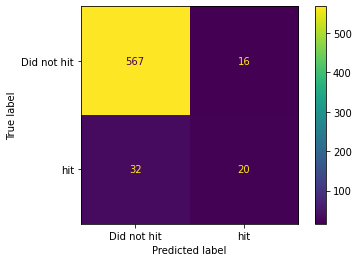

In [63]:
plot_confusion_matrix(clf_xgb,X_test,
                     y_test,
                     values_format='d',
                     display_labels=["Did not hit","hit"])

In [64]:
param_grid = {
    'max_depth':[3,4,5],
    'learning_rate':[0.1,0.01,0.05],
    'gamma':[0,0.25,1.0],
    'reg_lambda':[0,1.0,10.0],
    'scale_pos_weight':[1,3,5]
}

In [65]:
eval_set = [(X_test, y_test)]

In [66]:
gsearch1 = GridSearchCV(estimator = clf_xgb, param_grid = param_grid, scoring='f1_micro'
                        ,n_jobs=10,verbose = 2, cv=3)
gsearch1.fit(X_train, y_train, eval_set=eval_set)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[0]	validation_0-logloss:0.61816
[1]	validation_0-logloss:0.55632
[2]	validation_0-logloss:0.50618
[3]	validation_0-logloss:0.46308
[4]	validation_0-logloss:0.42590
[5]	validation_0-logloss:0.39505
[6]	validation_0-logloss:0.36786
[7]	validation_0-logloss:0.34328
[0]	validation_0-logloss:0.61555
[1]	validation_0-logloss:0.55244
[2]	validation_0-logloss:0.50076
[8]	validation_0-logloss:0.32179
[3]	validation_0-logloss:0.45741
[9]	validation_0-logloss:0.30399
[4]	validation_0-logloss:0.42084
[10]	validation_0-logloss:0.28771
[5]	validation_0-logloss:0.38894
[6]	validation_0-logloss:0.36129
[11]	validation_0-logloss:0.27318
[7]	validation_0-logloss:0.33716
[12]	validation_0-logloss:0.26129
[13]	validation_0-logloss:0.25000
[14]	validation_0-logloss:0.24055
[8]	validation_0-logloss:0.31629
[15]	validation_0-logloss:0.23310
[9]	validation_0-logloss:0.29830
[10]	validation_0-logloss:0.28240
[11]	validation_0-logloss:0.26875
[12]	

[56]	validation_0-logloss:0.20074
[57]	validation_0-logloss:0.19927
[55]	validation_0-logloss:0.18621
[46]	validation_0-logloss:0.20414
[61]	validation_0-logloss:0.21992
[47]	validation_0-logloss:0.20363
[48]	validation_0-logloss:0.20360
[62]	validation_0-logloss:0.22007
[70]	validation_0-logloss:0.17456
[49]	validation_0-logloss:0.20291
[71]	validation_0-logloss:0.17471
[50]	validation_0-logloss:0.20260
[43]	validation_0-logloss:0.21077
[51]	validation_0-logloss:0.20163
[44]	validation_0-logloss:0.21117
[56]	validation_0-logloss:0.18598
[52]	validation_0-logloss:0.20106
[57]	validation_0-logloss:0.18565
[72]	validation_0-logloss:0.17525
[58]	validation_0-logloss:0.19925
[58]	validation_0-logloss:0.18539
[73]	validation_0-logloss:0.17549
[59]	validation_0-logloss:0.19958
[45]	validation_0-logloss:0.21067
[74]	validation_0-logloss:0.17566
[46]	validation_0-logloss:0.20994
[59]	validation_0-logloss:0.18481
[47]	validation_0-logloss:0.20834
[60]	validation_0-logloss:0.19968
[63]	validatio

[2]	validation_0-logloss:0.50943
[58]	validation_0-logloss:0.19893
[39]	validation_0-logloss:0.22308
[9]	validation_0-logloss:0.31846
[3]	validation_0-logloss:0.46659
[59]	validation_0-logloss:0.19880
[40]	validation_0-logloss:0.22265
[10]	validation_0-logloss:0.30340
[4]	validation_0-logloss:0.42933
[60]	validation_0-logloss:0.19917
[51]	validation_0-logloss:0.18515
[48]	validation_0-logloss:0.20535
[25]	validation_0-logloss:0.23806
[52]	validation_0-logloss:0.18433
[49]	validation_0-logloss:0.20445
[82]	validation_0-logloss:0.17930
[26]	validation_0-logloss:0.23580
[50]	validation_0-logloss:0.20471
[83]	validation_0-logloss:0.17965
[27]	validation_0-logloss:0.23350
[5]	validation_0-logloss:0.39791
[84]	validation_0-logloss:0.17928
[25]	validation_0-logloss:0.20199
[61]	validation_0-logloss:0.19915
[41]	validation_0-logloss:0.22219
[6]	validation_0-logloss:0.37098
[62]	validation_0-logloss:0.19960
[26]	validation_0-logloss:0.19977
[42]	validation_0-logloss:0.22217
[7]	validation_0-log

[55]	validation_0-logloss:0.17089
[61]	validation_0-logloss:0.18311
[14]	validation_0-logloss:0.27858
[92]	validation_0-logloss:0.21549
[56]	validation_0-logloss:0.17092
[77]	validation_0-logloss:0.20139
[62]	validation_0-logloss:0.18311
[93]	validation_0-logloss:0.21507
[78]	validation_0-logloss:0.20046
[25]	validation_0-logloss:0.22169
[79]	validation_0-logloss:0.20065
[99]	validation_0-logloss:0.19060
[76]	validation_0-logloss:0.17408
[26]	validation_0-logloss:0.21891
[77]	validation_0-logloss:0.17409
[15]	validation_0-logloss:0.27030
[57]	validation_0-logloss:0.17064
[78]	validation_0-logloss:0.17406
[16]	validation_0-logloss:0.26270
[58]	validation_0-logloss:0.17041
[63]	validation_0-logloss:0.18329
[94]	validation_0-logloss:0.21519
[59]	validation_0-logloss:0.17033
[95]	validation_0-logloss:0.21544
[64]	validation_0-logloss:0.18361
[80]	validation_0-logloss:0.20066
[96]	validation_0-logloss:0.21573
[65]	validation_0-logloss:0.18340
[81]	validation_0-logloss:0.19980
[82]	validatio

[33]	validation_0-logloss:0.22916
[73]	validation_0-logloss:0.19757
[24]	validation_0-logloss:0.24847
[34]	validation_0-logloss:0.22833
[74]	validation_0-logloss:0.19800
[82]	validation_0-logloss:0.18442
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   1.1s
[0]	validation_0-logloss:0.61541
[83]	validation_0-logloss:0.18426
[45]	validation_0-logloss:0.19294
[46]	validation_0-logloss:0.19270
[39]	validation_0-logloss:0.22425
[15]	validation_0-logloss:0.24144
[13]	validation_0-logloss:0.24666
[47]	validation_0-logloss:0.19182
[40]	validation_0-logloss:0.22305
[16]	validation_0-logloss:0.23530
[48]	validation_0-logloss:0.19147
[41]	validation_0-logloss:0.22263
[49]	validation_0-logloss:0.19087
[25]	validation_0-logloss:0.24639
[75]	validation_0-logloss:0.19824
[35]	validation_0-logloss:0.22715
[76]	validation_0-logloss:0.19824
[26]	validation_0-logloss:0.24254
[36]	validation_0-logloss:0.22551
[84]	validation_0-logloss:0.18424
[1]	validat

[56]	validation_0-logloss:0.21434
[80]	validation_0-logloss:0.18846
[41]	validation_0-logloss:0.18582
[57]	validation_0-logloss:0.21415
[67]	validation_0-logloss:0.21743
[5]	validation_0-logloss:0.40969
[6]	validation_0-logloss:0.38142
[68]	validation_0-logloss:0.21722
[39]	validation_0-logloss:0.16898
[73]	validation_0-logloss:0.20604
[40]	validation_0-logloss:0.16831
[74]	validation_0-logloss:0.20489
[42]	validation_0-logloss:0.18660
[58]	validation_0-logloss:0.21366
[43]	validation_0-logloss:0.18678
[27]	validation_0-logloss:0.17742
[81]	validation_0-logloss:0.18839
[69]	validation_0-logloss:0.21667
[59]	validation_0-logloss:0.21332
[28]	validation_0-logloss:0.17535
[82]	validation_0-logloss:0.18839
[70]	validation_0-logloss:0.21671
[60]	validation_0-logloss:0.21264
[7]	validation_0-logloss:0.35920
[83]	validation_0-logloss:0.18821
[71]	validation_0-logloss:0.21650
[84]	validation_0-logloss:0.18805
[8]	validation_0-logloss:0.33804
[85]	validation_0-logloss:0.18772
[CV] END gamma=0, 

[89]	validation_0-logloss:0.20518
[55]	validation_0-logloss:0.17946
[67]	validation_0-logloss:0.16839
[90]	validation_0-logloss:0.20485
[32]	validation_0-logloss:0.18637
[68]	validation_0-logloss:0.16799
[91]	validation_0-logloss:0.20428
[33]	validation_0-logloss:0.18515
[69]	validation_0-logloss:0.16800
[56]	validation_0-logloss:0.17998
[57]	validation_0-logloss:0.18061
[24]	validation_0-logloss:0.21533
[92]	validation_0-logloss:0.20387
[25]	validation_0-logloss:0.21235
[93]	validation_0-logloss:0.20407
[34]	validation_0-logloss:0.18354
[94]	validation_0-logloss:0.20379
[70]	validation_0-logloss:0.16781
[35]	validation_0-logloss:0.18242
[71]	validation_0-logloss:0.16745
[26]	validation_0-logloss:0.21014
[27]	validation_0-logloss:0.20841
[58]	validation_0-logloss:0.18096
[95]	validation_0-logloss:0.20349
[36]	validation_0-logloss:0.18166
[59]	validation_0-logloss:0.18115
[96]	validation_0-logloss:0.20323
[37]	validation_0-logloss:0.17997
[72]	validation_0-logloss:0.16780
[CV] END gamma

[29]	validation_0-logloss:0.20373
[28]	validation_0-logloss:0.18256
[17]	validation_0-logloss:0.22754
[29]	validation_0-logloss:0.21658
[18]	validation_0-logloss:0.22254
[30]	validation_0-logloss:0.21533
[29]	validation_0-logloss:0.22190
[30]	validation_0-logloss:0.22002
[36]	validation_0-logloss:0.19396
[66]	validation_0-logloss:0.19908
[11]	validation_0-logloss:0.26853
[37]	validation_0-logloss:0.19378
[76]	validation_0-logloss:0.17079
[12]	validation_0-logloss:0.25655
[30]	validation_0-logloss:0.20157
[67]	validation_0-logloss:0.19990
[77]	validation_0-logloss:0.17089
[31]	validation_0-logloss:0.20010
[31]	validation_0-logloss:0.21536
[29]	validation_0-logloss:0.18117
[32]	validation_0-logloss:0.21303
[19]	validation_0-logloss:0.21743
[31]	validation_0-logloss:0.21856
[30]	validation_0-logloss:0.17975
[38]	validation_0-logloss:0.19420
[32]	validation_0-logloss:0.21741
[31]	validation_0-logloss:0.17883
[20]	validation_0-logloss:0.21313
[39]	validation_0-logloss:0.19322
[33]	validatio

[66]	validation_0-logloss:0.20800
[67]	validation_0-logloss:0.17461
[73]	validation_0-logloss:0.19290
[68]	validation_0-logloss:0.17433
[74]	validation_0-logloss:0.19304
[12]	validation_0-logloss:0.27856
[5]	validation_0-logloss:0.41137
[66]	validation_0-logloss:0.20077
[6]	validation_0-logloss:0.38631
[49]	validation_0-logloss:0.17351
[13]	validation_0-logloss:0.26746
[14]	validation_0-logloss:0.25827
[50]	validation_0-logloss:0.17409
[67]	validation_0-logloss:0.20010
[66]	validation_0-logloss:0.16881
[55]	validation_0-logloss:0.18683
[67]	validation_0-logloss:0.16999
[56]	validation_0-logloss:0.18733
[67]	validation_0-logloss:0.20762
[68]	validation_0-logloss:0.17008
[75]	validation_0-logloss:0.19355
[68]	validation_0-logloss:0.20878
[69]	validation_0-logloss:0.17392
[69]	validation_0-logloss:0.16960
[76]	validation_0-logloss:0.19360
[70]	validation_0-logloss:0.17386
[70]	validation_0-logloss:0.17013
[7]	validation_0-logloss:0.36365
[68]	validation_0-logloss:0.20024
[51]	validation_0

[6]	validation_0-logloss:0.37872
[42]	validation_0-logloss:0.17231
[43]	validation_0-logloss:0.17218
[7]	validation_0-logloss:0.35547
[6]	validation_0-logloss:0.40061
[7]	validation_0-logloss:0.37727
[10]	validation_0-logloss:0.32287
[46]	validation_0-logloss:0.19640
[49]	validation_0-logloss:0.17227
[47]	validation_0-logloss:0.19676
[11]	validation_0-logloss:0.30877
[8]	validation_0-logloss:0.33512
[50]	validation_0-logloss:0.17321
[20]	validation_0-logloss:0.22009
[9]	validation_0-logloss:0.31769
[21]	validation_0-logloss:0.21655
[8]	validation_0-logloss:0.35832
[9]	validation_0-logloss:0.34046
[10]	validation_0-logloss:0.32780
[44]	validation_0-logloss:0.17207
[12]	validation_0-logloss:0.29659
[45]	validation_0-logloss:0.17147
[48]	validation_0-logloss:0.19637
[11]	validation_0-logloss:0.31370
[46]	validation_0-logloss:0.17121
[13]	validation_0-logloss:0.28635
[47]	validation_0-logloss:0.17069
[14]	validation_0-logloss:0.27758
[48]	validation_0-logloss:0.17095
[49]	validation_0-logl

[16]	validation_0-logloss:0.23285
[36]	validation_0-logloss:0.20239
[76]	validation_0-logloss:0.16950
[33]	validation_0-logloss:0.18702
[21]	validation_0-logloss:0.21537
[33]	validation_0-logloss:0.21853
[37]	validation_0-logloss:0.20110
[22]	validation_0-logloss:0.21150
[34]	validation_0-logloss:0.21709
[17]	validation_0-logloss:0.22567
[35]	validation_0-logloss:0.21728
[75]	validation_0-logloss:0.16889
[35]	validation_0-logloss:0.21381
[34]	validation_0-logloss:0.18572
[76]	validation_0-logloss:0.16942
[36]	validation_0-logloss:0.21388
[35]	validation_0-logloss:0.18455
[77]	validation_0-logloss:0.16930
[46]	validation_0-logloss:0.18976
[78]	validation_0-logloss:0.16938
[38]	validation_0-logloss:0.19999
[18]	validation_0-logloss:0.21940
[47]	validation_0-logloss:0.18904
[79]	validation_0-logloss:0.16928
[39]	validation_0-logloss:0.19892
[23]	validation_0-logloss:0.20834
[19]	validation_0-logloss:0.21398
[36]	validation_0-logloss:0.21685
[24]	validation_0-logloss:0.20498
[77]	validatio

[64]	validation_0-logloss:0.18626
[62]	validation_0-logloss:0.20490
[60]	validation_0-logloss:0.17603
[65]	validation_0-logloss:0.18608
[61]	validation_0-logloss:0.17592
[63]	validation_0-logloss:0.20650
[62]	validation_0-logloss:0.17554
[66]	validation_0-logloss:0.18538
[64]	validation_0-logloss:0.20631
[65]	validation_0-logloss:0.20701
[67]	validation_0-logloss:0.18459
[63]	validation_0-logloss:0.17548
[45]	validation_0-logloss:0.17421
[75]	validation_0-logloss:0.18543
[66]	validation_0-logloss:0.20693
[64]	validation_0-logloss:0.17514
[46]	validation_0-logloss:0.17376
[50]	validation_0-logloss:0.18401
[76]	validation_0-logloss:0.18562
[47]	validation_0-logloss:0.17379
[51]	validation_0-logloss:0.18424
[12]	validation_0-logloss:0.29671
[63]	validation_0-logloss:0.20480
[13]	validation_0-logloss:0.28580
[64]	validation_0-logloss:0.20461
[65]	validation_0-logloss:0.20397
[77]	validation_0-logloss:0.18598
[48]	validation_0-logloss:0.17337
[68]	validation_0-logloss:0.18416
[78]	validatio

[21]	validation_0-logloss:0.23525
[94]	validation_0-logloss:0.17913
[17]	validation_0-logloss:0.24953
[95]	validation_0-logloss:0.17892
[18]	validation_0-logloss:0.24314
[73]	validation_0-logloss:0.17297
[92]	validation_0-logloss:0.20736
[38]	validation_0-logloss:0.19390
[93]	validation_0-logloss:0.20701
[CV] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=3; total time=   1.4s
[0]	validation_0-logloss:0.63078
[74]	validation_0-logloss:0.17320
[77]	validation_0-logloss:0.18724
[91]	validation_0-logloss:0.20090
[90]	validation_0-logloss:0.17509
[92]	validation_0-logloss:0.20061
[91]	validation_0-logloss:0.17503
[93]	validation_0-logloss:0.20040
[22]	validation_0-logloss:0.23100
[39]	validation_0-logloss:0.19329
[94]	validation_0-logloss:0.20678
[19]	validation_0-logloss:0.23761
[23]	validation_0-logloss:0.22744
[95]	validation_0-logloss:0.20709
[75]	validation_0-logloss:0.17322
[40]	validation_0-logloss:0.19268
[20]	validation_0-logloss:0.23294
[76]	validat

[12]	validation_0-logloss:0.25605
[20]	validation_0-logloss:0.25637
[17]	validation_0-logloss:0.27669
[14]	validation_0-logloss:0.23957
[18]	validation_0-logloss:0.26989
[21]	validation_0-logloss:0.25301
[19]	validation_0-logloss:0.26451
[10]	validation_0-logloss:0.29783
[20]	validation_0-logloss:0.26063
[11]	validation_0-logloss:0.28408
[22]	validation_0-logloss:0.24974
[76]	validation_0-logloss:0.18079
[15]	validation_0-logloss:0.24278
[56]	validation_0-logloss:0.18685
[23]	validation_0-logloss:0.24668
[13]	validation_0-logloss:0.24473
[77]	validation_0-logloss:0.18116
[57]	validation_0-logloss:0.18636
[16]	validation_0-logloss:0.23668
[14]	validation_0-logloss:0.23513
[15]	validation_0-logloss:0.23167
[60]	validation_0-logloss:0.19427
[37]	validation_0-logloss:0.21652
[61]	validation_0-logloss:0.19453
[16]	validation_0-logloss:0.22478
[38]	validation_0-logloss:0.21597
[78]	validation_0-logloss:0.18085
[58]	validation_0-logloss:0.18601
[12]	validation_0-logloss:0.27207
[17]	validatio

[48]	validation_0-logloss:0.21451
[63]	validation_0-logloss:0.20093
[36]	validation_0-logloss:0.17347
[49]	validation_0-logloss:0.21466
[35]	validation_0-logloss:0.17368
[38]	validation_0-logloss:0.19593
[45]	validation_0-logloss:0.21356
[39]	validation_0-logloss:0.19712
[36]	validation_0-logloss:0.17397
[33]	validation_0-logloss:0.17627
[46]	validation_0-logloss:0.21287
[34]	validation_0-logloss:0.17494
[85]	validation_0-logloss:0.18472
[37]	validation_0-logloss:0.17253
[64]	validation_0-logloss:0.20020
[86]	validation_0-logloss:0.18501
[38]	validation_0-logloss:0.17233
[65]	validation_0-logloss:0.19970
[50]	validation_0-logloss:0.21435
[39]	validation_0-logloss:0.17243
[51]	validation_0-logloss:0.21442
[47]	validation_0-logloss:0.21240
[37]	validation_0-logloss:0.17336
[40]	validation_0-logloss:0.17252
[40]	validation_0-logloss:0.19733
[38]	validation_0-logloss:0.17327
[48]	validation_0-logloss:0.21159
[35]	validation_0-logloss:0.17406
[87]	validation_0-logloss:0.18478
[36]	validatio

[89]	validation_0-logloss:0.21274
[90]	validation_0-logloss:0.21256
[23]	validation_0-logloss:0.21693
[86]	validation_0-logloss:0.20260
[22]	validation_0-logloss:0.20606
[24]	validation_0-logloss:0.21432
[7]	validation_0-logloss:0.35396
[87]	validation_0-logloss:0.20236
[69]	validation_0-logloss:0.17303
[23]	validation_0-logloss:0.20263
[88]	validation_0-logloss:0.20223
[3]	validation_0-logloss:0.48240
[70]	validation_0-logloss:0.17255
[8]	validation_0-logloss:0.33506
[4]	validation_0-logloss:0.44598
[25]	validation_0-logloss:0.21219
[89]	validation_0-logloss:0.20184
[9]	validation_0-logloss:0.31615
[91]	validation_0-logloss:0.21267
[90]	validation_0-logloss:0.20157
[92]	validation_0-logloss:0.21283
[71]	validation_0-logloss:0.17284
[24]	validation_0-logloss:0.20033
[72]	validation_0-logloss:0.17302
[93]	validation_0-logloss:0.21295
[5]	validation_0-logloss:0.41866
[26]	validation_0-logloss:0.21170
[10]	validation_0-logloss:0.30112
[25]	validation_0-logloss:0.19880
[27]	validation_0-lo

[40]	validation_0-logloss:0.18870
[13]	validation_0-logloss:0.26346
[41]	validation_0-logloss:0.18770
[25]	validation_0-logloss:0.20469
[26]	validation_0-logloss:0.20274
[59]	validation_0-logloss:0.20543
[27]	validation_0-logloss:0.20769
[26]	validation_0-logloss:0.19070
[16]	validation_0-logloss:0.22314
[36]	validation_0-logloss:0.21536
[28]	validation_0-logloss:0.20656
[17]	validation_0-logloss:0.21742
[27]	validation_0-logloss:0.18888
[11]	validation_0-logloss:0.29852
[37]	validation_0-logloss:0.21623
[42]	validation_0-logloss:0.18789
[14]	validation_0-logloss:0.25382
[12]	validation_0-logloss:0.28695
[27]	validation_0-logloss:0.20129
[60]	validation_0-logloss:0.20594
[58]	validation_0-logloss:0.19371
[15]	validation_0-logloss:0.24471
[61]	validation_0-logloss:0.20586
[18]	validation_0-logloss:0.21136
[29]	validation_0-logloss:0.20554
[13]	validation_0-logloss:0.27813
[28]	validation_0-logloss:0.18738
[38]	validation_0-logloss:0.21636
[30]	validation_0-logloss:0.20504
[43]	validatio

[45]	validation_0-logloss:0.19964
[15]	validation_0-logloss:0.25325
[77]	validation_0-logloss:0.18100
[53]	validation_0-logloss:0.17999
[46]	validation_0-logloss:0.19967
[54]	validation_0-logloss:0.18045
[20]	validation_0-logloss:0.21596
[62]	validation_0-logloss:0.19401
[64]	validation_0-logloss:0.19810
[63]	validation_0-logloss:0.19538
[64]	validation_0-logloss:0.17730
[65]	validation_0-logloss:0.19785
[49]	validation_0-logloss:0.17474
[65]	validation_0-logloss:0.17755
[78]	validation_0-logloss:0.17979
[16]	validation_0-logloss:0.24560
[50]	validation_0-logloss:0.17489
[47]	validation_0-logloss:0.20065
[79]	validation_0-logloss:0.18004
[17]	validation_0-logloss:0.23943
[55]	validation_0-logloss:0.18085
[48]	validation_0-logloss:0.20119
[CV] END gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=5; total time=   1.2s
[0]	validation_0-logloss:0.62501
[80]	validation_0-logloss:0.17884
[56]	validation_0-logloss:0.18083
[64]	validation_0-logloss:0.19519
[21]	validatio

[32]	validation_0-logloss:0.22003
[49]	validation_0-logloss:0.18006
[7]	validation_0-logloss:0.35339
[50]	validation_0-logloss:0.17964
[4]	validation_0-logloss:0.42912
[56]	validation_0-logloss:0.18671
[14]	validation_0-logloss:0.25761
[CV] END gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=5; total time=   1.8s
[0]	validation_0-logloss:0.62748
[15]	validation_0-logloss:0.26254
[1]	validation_0-logloss:0.57171
[15]	validation_0-logloss:0.24944
[33]	validation_0-logloss:0.21888
[8]	validation_0-logloss:0.33370
[51]	validation_0-logloss:0.17975
[34]	validation_0-logloss:0.21783
[5]	validation_0-logloss:0.39834
[57]	validation_0-logloss:0.18646
[9]	validation_0-logloss:0.31683
[16]	validation_0-logloss:0.25547
[6]	validation_0-logloss:0.37101
[58]	validation_0-logloss:0.18619
[2]	validation_0-logloss:0.52529
[17]	validation_0-logloss:0.24833
[16]	validation_0-logloss:0.24160
[CV] END gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=5; total 

[40]	validation_0-logloss:0.18709
[66]	validation_0-logloss:0.21731
[38]	validation_0-logloss:0.17585
[49]	validation_0-logloss:0.19970
[67]	validation_0-logloss:0.21735
[68]	validation_0-logloss:0.21682
[32]	validation_0-logloss:0.20216
[69]	validation_0-logloss:0.21733
[33]	validation_0-logloss:0.20021
[86]	validation_0-logloss:0.18091
[2]	validation_0-logloss:0.53426
[28]	validation_0-logloss:0.20393
[3]	validation_0-logloss:0.49516
[47]	validation_0-logloss:0.17867
[39]	validation_0-logloss:0.17530
[29]	validation_0-logloss:0.20198
[41]	validation_0-logloss:0.18668
[48]	validation_0-logloss:0.17830
[31]	validation_0-logloss:0.21376
[40]	validation_0-logloss:0.17513
[50]	validation_0-logloss:0.19910
[49]	validation_0-logloss:0.17790
[42]	validation_0-logloss:0.18619
[34]	validation_0-logloss:0.19899
[51]	validation_0-logloss:0.19906
[87]	validation_0-logloss:0.18084
[30]	validation_0-logloss:0.20038
[35]	validation_0-logloss:0.19720
[32]	validation_0-logloss:0.21228
[31]	validation_

[67]	validation_0-logloss:0.18149
[85]	validation_0-logloss:0.19805
[63]	validation_0-logloss:0.18574
[86]	validation_0-logloss:0.19838
[68]	validation_0-logloss:0.18165
[69]	validation_0-logloss:0.18163
[10]	validation_0-logloss:0.33866
[81]	validation_0-logloss:0.17498
[63]	validation_0-logloss:0.19992
[11]	validation_0-logloss:0.32586
[33]	validation_0-logloss:0.21416
[15]	validation_0-logloss:0.28332
[34]	validation_0-logloss:0.21176
[16]	validation_0-logloss:0.27658
[17]	validation_0-logloss:0.26974
[74]	validation_0-logloss:0.17470
[64]	validation_0-logloss:0.18572
[82]	validation_0-logloss:0.17504
[83]	validation_0-logloss:0.17487
[64]	validation_0-logloss:0.19981
[12]	validation_0-logloss:0.31384
[35]	validation_0-logloss:0.20984
[65]	validation_0-logloss:0.20002
[87]	validation_0-logloss:0.19819
[36]	validation_0-logloss:0.20758
[65]	validation_0-logloss:0.18575
[13]	validation_0-logloss:0.30336
[84]	validation_0-logloss:0.17505
[75]	validation_0-logloss:0.17482
[66]	validatio

[32]	validation_0-logloss:0.49701
[33]	validation_0-logloss:0.49257
[8]	validation_0-logloss:0.62547
[34]	validation_0-logloss:0.48826
[9]	validation_0-logloss:0.61867
[7]	validation_0-logloss:0.63870
[44]	validation_0-logloss:0.21591
[8]	validation_0-logloss:0.63246
[10]	validation_0-logloss:0.61490
[35]	validation_0-logloss:0.48396
[10]	validation_0-logloss:0.61196
[66]	validation_0-logloss:0.19319
[9]	validation_0-logloss:0.62633
[36]	validation_0-logloss:0.47976
[10]	validation_0-logloss:0.62032
[11]	validation_0-logloss:0.60542
[67]	validation_0-logloss:0.19251
[11]	validation_0-logloss:0.61440
[12]	validation_0-logloss:0.59895
[12]	validation_0-logloss:0.60861
[68]	validation_0-logloss:0.19235
[13]	validation_0-logloss:0.59268
[13]	validation_0-logloss:0.60290
[11]	validation_0-logloss:0.60852
[45]	validation_0-logloss:0.20894
[45]	validation_0-logloss:0.21481
[12]	validation_0-logloss:0.60230
[46]	validation_0-logloss:0.20870
[13]	validation_0-logloss:0.59622
[46]	validation_0-l

[42]	validation_0-logloss:0.45112
[66]	validation_0-logloss:0.21135
[44]	validation_0-logloss:0.45053
[69]	validation_0-logloss:0.37146
[43]	validation_0-logloss:0.44738
[29]	validation_0-logloss:0.51955
[70]	validation_0-logloss:0.36892
[44]	validation_0-logloss:0.44362
[45]	validation_0-logloss:0.44701
[30]	validation_0-logloss:0.51531
[66]	validation_0-logloss:0.20017
[46]	validation_0-logloss:0.44353
[67]	validation_0-logloss:0.19989
[40]	validation_0-logloss:0.47980
[13]	validation_0-logloss:0.60749
[26]	validation_0-logloss:0.53912
[87]	validation_0-logloss:0.18936
[41]	validation_0-logloss:0.47615
[14]	validation_0-logloss:0.60211
[27]	validation_0-logloss:0.53469
[42]	validation_0-logloss:0.47244
[45]	validation_0-logloss:0.43993
[71]	validation_0-logloss:0.36634
[67]	validation_0-logloss:0.21128
[28]	validation_0-logloss:0.53020
[31]	validation_0-logloss:0.51098
[46]	validation_0-logloss:0.43634
[72]	validation_0-logloss:0.36379
[68]	validation_0-logloss:0.21106
[32]	validatio

[49]	validation_0-logloss:0.46011
[92]	validation_0-logloss:0.21242
[83]	validation_0-logloss:0.34448
[65]	validation_0-logloss:0.39888
[90]	validation_0-logloss:0.19885
[66]	validation_0-logloss:0.39635
[91]	validation_0-logloss:0.19877
[63]	validation_0-logloss:0.40897
[64]	validation_0-logloss:0.40636
[50]	validation_0-logloss:0.45716
[82]	validation_0-logloss:0.33504
[51]	validation_0-logloss:0.45418
[67]	validation_0-logloss:0.39399
[84]	validation_0-logloss:0.34251
[93]	validation_0-logloss:0.21263
[78]	validation_0-logloss:0.37012
[68]	validation_0-logloss:0.39152
[85]	validation_0-logloss:0.34057
[79]	validation_0-logloss:0.36789
[94]	validation_0-logloss:0.21267
[69]	validation_0-logloss:0.38905
[86]	validation_0-logloss:0.33866
[80]	validation_0-logloss:0.36573
[CV] END gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=10.0, scale_pos_weight=5; total time=   2.6s
[0]	validation_0-logloss:0.68621
[83]	validation_0-logloss:0.33295
[65]	validation_0-logloss:0.40369
[66]	valida

[89]	validation_0-logloss:0.36575
[6]	validation_0-logloss:0.64010
[90]	validation_0-logloss:0.36398
[4]	validation_0-logloss:0.65837
[5]	validation_0-logloss:0.65180
[6]	validation_0-logloss:0.64536
[30]	validation_0-logloss:0.52589
[11]	validation_0-logloss:0.60890
[38]	validation_0-logloss:0.49723
[31]	validation_0-logloss:0.52193
[12]	validation_0-logloss:0.60272
[39]	validation_0-logloss:0.49363
[7]	validation_0-logloss:0.63470
[32]	validation_0-logloss:0.51787
[13]	validation_0-logloss:0.59660
[40]	validation_0-logloss:0.49008
[8]	validation_0-logloss:0.62802
[7]	validation_0-logloss:0.63307
[91]	validation_0-logloss:0.36228
[8]	validation_0-logloss:0.62621
[33]	validation_0-logloss:0.51403
[9]	validation_0-logloss:0.62147
[14]	validation_0-logloss:0.59072
[34]	validation_0-logloss:0.51017
[10]	validation_0-logloss:0.61499
[15]	validation_0-logloss:0.58481
[11]	validation_0-logloss:0.60870
[16]	validation_0-logloss:0.57912
[92]	validation_0-logloss:0.36045
[12]	validation_0-loglo

[44]	validation_0-logloss:0.44482
[47]	validation_0-logloss:0.43990
[76]	validation_0-logloss:0.39283
[23]	validation_0-logloss:0.55909
[45]	validation_0-logloss:0.44120
[48]	validation_0-logloss:0.43640
[46]	validation_0-logloss:0.44436
[41]	validation_0-logloss:0.47696
[46]	validation_0-logloss:0.43756
[47]	validation_0-logloss:0.44083
[27]	validation_0-logloss:0.52970
[42]	validation_0-logloss:0.47338
[48]	validation_0-logloss:0.43739
[28]	validation_0-logloss:0.52519
[35]	validation_0-logloss:0.50170
[29]	validation_0-logloss:0.52074
[68]	validation_0-logloss:0.40752
[36]	validation_0-logloss:0.49765
[77]	validation_0-logloss:0.39076
[69]	validation_0-logloss:0.40501
[78]	validation_0-logloss:0.38879
[49]	validation_0-logloss:0.43299
[70]	validation_0-logloss:0.40275
[47]	validation_0-logloss:0.43406
[79]	validation_0-logloss:0.38694
[50]	validation_0-logloss:0.42959
[8]	validation_0-logloss:0.63600
[48]	validation_0-logloss:0.43059
[51]	validation_0-logloss:0.42628
[43]	validation

[55]	validation_0-logloss:0.44447
[68]	validation_0-logloss:0.39702
[69]	validation_0-logloss:0.39462
[56]	validation_0-logloss:0.44171
[44]	validation_0-logloss:0.47742
[57]	validation_0-logloss:0.43896
[82]	validation_0-logloss:0.33647
[63]	validation_0-logloss:0.40529
[45]	validation_0-logloss:0.47415
[83]	validation_0-logloss:0.33434
[64]	validation_0-logloss:0.40267
[65]	validation_0-logloss:0.40008
[84]	validation_0-logloss:0.33226
[84]	validation_0-logloss:0.34301
[84]	validation_0-logloss:0.33874
[85]	validation_0-logloss:0.34106
[85]	validation_0-logloss:0.33660
[77]	validation_0-logloss:0.37405
[70]	validation_0-logloss:0.39219
[86]	validation_0-logloss:0.33450
[78]	validation_0-logloss:0.37184
[71]	validation_0-logloss:0.38984
[58]	validation_0-logloss:0.43615
[46]	validation_0-logloss:0.47092
[59]	validation_0-logloss:0.43358
[66]	validation_0-logloss:0.39762
[47]	validation_0-logloss:0.46775
[85]	validation_0-logloss:0.33012
[86]	validation_0-logloss:0.33915
[48]	validatio

[88]	validation_0-logloss:0.37006
[89]	validation_0-logloss:0.36823
[96]	validation_0-logloss:0.33513
[77]	validation_0-logloss:0.39142
[97]	validation_0-logloss:0.33339
[78]	validation_0-logloss:0.38940
[98]	validation_0-logloss:0.33171
[26]	validation_0-logloss:0.54344
[79]	validation_0-logloss:0.38749
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   1.7s
[0]	validation_0-logloss:0.68555
[27]	validation_0-logloss:0.53908
[28]	validation_0-logloss:0.53493
[29]	validation_0-logloss:0.53069
[30]	validation_0-logloss:0.52658
[90]	validation_0-logloss:0.36639
[16]	validation_0-logloss:0.58336
[99]	validation_0-logloss:0.33009
[17]	validation_0-logloss:0.57788
[91]	validation_0-logloss:0.36460
[92]	validation_0-logloss:0.36281
[80]	validation_0-logloss:0.38551
[1]	validation_0-logloss:0.67811
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   1.7s
[0]	validation_0-logloss:0.68551
[81]	vali

[29]	validation_0-logloss:0.53343
[59]	validation_0-logloss:0.43093
[60]	validation_0-logloss:0.42826
[30]	validation_0-logloss:0.52926
[31]	validation_0-logloss:0.52516
[61]	validation_0-logloss:0.42559
[62]	validation_0-logloss:0.42310
[30]	validation_0-logloss:0.51263
[29]	validation_0-logloss:0.53223
[3]	validation_0-logloss:0.66743
[30]	validation_0-logloss:0.52812
[4]	validation_0-logloss:0.66130
[48]	validation_0-logloss:0.44531
[31]	validation_0-logloss:0.50827
[5]	validation_0-logloss:0.65527
[9]	validation_0-logloss:0.63432
[49]	validation_0-logloss:0.44195
[10]	validation_0-logloss:0.62901
[50]	validation_0-logloss:0.43867
[19]	validation_0-logloss:0.57559
[11]	validation_0-logloss:0.62376
[31]	validation_0-logloss:0.50469
[20]	validation_0-logloss:0.57065
[32]	validation_0-logloss:0.50032
[21]	validation_0-logloss:0.56584
[32]	validation_0-logloss:0.50394
[12]	validation_0-logloss:0.61864
[31]	validation_0-logloss:0.52407
[6]	validation_0-logloss:0.64930
[33]	validation_0-l

[71]	validation_0-logloss:0.37893
[91]	validation_0-logloss:0.33718
[92]	validation_0-logloss:0.33533
[70]	validation_0-logloss:0.40101
[93]	validation_0-logloss:0.33350
[70]	validation_0-logloss:0.37465
[71]	validation_0-logloss:0.39863
[71]	validation_0-logloss:0.37222
[72]	validation_0-logloss:0.36976
[72]	validation_0-logloss:0.37658
[60]	validation_0-logloss:0.42467
[44]	validation_0-logloss:0.48434
[73]	validation_0-logloss:0.37426
[61]	validation_0-logloss:0.42191
[45]	validation_0-logloss:0.48113
[74]	validation_0-logloss:0.37194
[62]	validation_0-logloss:0.41940
[50]	validation_0-logloss:0.47221
[70]	validation_0-logloss:0.40352
[63]	validation_0-logloss:0.41661
[51]	validation_0-logloss:0.46932
[71]	validation_0-logloss:0.40116
[64]	validation_0-logloss:0.41389
[32]	validation_0-logloss:0.52711
[52]	validation_0-logloss:0.46652
[53]	validation_0-logloss:0.46375
[33]	validation_0-logloss:0.52334
[72]	validation_0-logloss:0.39882
[54]	validation_0-logloss:0.46097
[72]	validatio

[74]	validation_0-logloss:0.40600
[83]	validation_0-logloss:0.39453
[84]	validation_0-logloss:0.39270
[9]	validation_0-logloss:0.62051
[10]	validation_0-logloss:0.61403
[3]	validation_0-logloss:0.66239
[4]	validation_0-logloss:0.65508
[96]	validation_0-logloss:0.34614
[62]	validation_0-logloss:0.43460
[5]	validation_0-logloss:0.64792
[97]	validation_0-logloss:0.34447
[63]	validation_0-logloss:0.43212
[75]	validation_0-logloss:0.40385
[98]	validation_0-logloss:0.34285
[85]	validation_0-logloss:0.39078
[76]	validation_0-logloss:0.40177
[77]	validation_0-logloss:0.39983
[86]	validation_0-logloss:0.38901
[78]	validation_0-logloss:0.39778
[87]	validation_0-logloss:0.38717
[79]	validation_0-logloss:0.39591
[11]	validation_0-logloss:0.60760
[12]	validation_0-logloss:0.60129
[6]	validation_0-logloss:0.64088
[64]	validation_0-logloss:0.42963
[7]	validation_0-logloss:0.63400
[65]	validation_0-logloss:0.42727
[66]	validation_0-logloss:0.42488
[99]	validation_0-logloss:0.34123
[88]	validation_0-lo

[43]	validation_0-logloss:0.44925
[44]	validation_0-logloss:0.44535
[45]	validation_0-logloss:0.44154
[4]	validation_0-logloss:0.65888
[46]	validation_0-logloss:0.43795
[38]	validation_0-logloss:0.47131
[5]	validation_0-logloss:0.65245
[39]	validation_0-logloss:0.46734
[20]	validation_0-logloss:0.56160
[21]	validation_0-logloss:0.55949
[22]	validation_0-logloss:0.53986
[21]	validation_0-logloss:0.55636
[23]	validation_0-logloss:0.53450
[22]	validation_0-logloss:0.55460
[20]	validation_0-logloss:0.56422
[16]	validation_0-logloss:0.58674
[6]	validation_0-logloss:0.64612
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=5; total time=   1.9s
[0]	validation_0-logloss:0.68605
[21]	validation_0-logloss:0.55913
[17]	validation_0-logloss:0.58156
[7]	validation_0-logloss:0.63994
[47]	validation_0-logloss:0.43419
[22]	validation_0-logloss:0.55419
[18]	validation_0-logloss:0.57637
[48]	validation_0-logloss:0.43068
[23]	validation_0-logloss:0.54932
[19]	validatio

[45]	validation_0-logloss:0.45974
[46]	validation_0-logloss:0.45202
[66]	validation_0-logloss:0.38097
[47]	validation_0-logloss:0.44861
[38]	validation_0-logloss:0.48819
[67]	validation_0-logloss:0.37844
[48]	validation_0-logloss:0.44502
[39]	validation_0-logloss:0.48445
[23]	validation_0-logloss:0.55576
[29]	validation_0-logloss:0.52744
[46]	validation_0-logloss:0.45559
[46]	validation_0-logloss:0.45637
[47]	validation_0-logloss:0.42966
[40]	validation_0-logloss:0.48080
[48]	validation_0-logloss:0.42615
[47]	validation_0-logloss:0.45310
[47]	validation_0-logloss:0.45227
[30]	validation_0-logloss:0.52329
[41]	validation_0-logloss:0.47720
[72]	validation_0-logloss:0.35985
[24]	validation_0-logloss:0.55140
[15]	validation_0-logloss:0.58390
[31]	validation_0-logloss:0.51906
[73]	validation_0-logloss:0.35741
[25]	validation_0-logloss:0.54677
[16]	validation_0-logloss:0.57808
[48]	validation_0-logloss:0.44884
[49]	validation_0-logloss:0.42265
[68]	validation_0-logloss:0.37577
[49]	validatio

[53]	validation_0-logloss:0.44334
[76]	validation_0-logloss:0.34601
[54]	validation_0-logloss:0.44031
[75]	validation_0-logloss:0.37184
[76]	validation_0-logloss:0.36944
[77]	validation_0-logloss:0.34372
[66]	validation_0-logloss:0.40376
[73]	validation_0-logloss:0.38007
[67]	validation_0-logloss:0.40141
[75]	validation_0-logloss:0.36958
[74]	validation_0-logloss:0.37771
[44]	validation_0-logloss:0.44896
[76]	validation_0-logloss:0.36736
[45]	validation_0-logloss:0.44535
[77]	validation_0-logloss:0.36499
[78]	validation_0-logloss:0.36266
[58]	validation_0-logloss:0.42899
[78]	validation_0-logloss:0.34148
[55]	validation_0-logloss:0.43722
[75]	validation_0-logloss:0.37551
[59]	validation_0-logloss:0.42642
[79]	validation_0-logloss:0.33922
[56]	validation_0-logloss:0.43422
[76]	validation_0-logloss:0.37316
[68]	validation_0-logloss:0.39906
[60]	validation_0-logloss:0.42352
[77]	validation_0-logloss:0.36715
[61]	validation_0-logloss:0.42101
[69]	validation_0-logloss:0.39671
[78]	validatio

[90]	validation_0-logloss:0.35776
[91]	validation_0-logloss:0.35613
[76]	validation_0-logloss:0.35439
[99]	validation_0-logloss:0.33793
[77]	validation_0-logloss:0.35220
[87]	validation_0-logloss:0.36226
[19]	validation_0-logloss:0.56074
[15]	validation_0-logloss:0.58120
[88]	validation_0-logloss:0.36046
[20]	validation_0-logloss:0.55526
[16]	validation_0-logloss:0.57518
[21]	validation_0-logloss:0.54989
[22]	validation_0-logloss:0.54469
[78]	validation_0-logloss:0.34993
[79]	validation_0-logloss:0.34773
[92]	validation_0-logloss:0.35441
[89]	validation_0-logloss:0.35866
[90]	validation_0-logloss:0.35684
[17]	validation_0-logloss:0.56930
[18]	validation_0-logloss:0.56363
[23]	validation_0-logloss:0.53951
[93]	validation_0-logloss:0.35283
[24]	validation_0-logloss:0.53437
[80]	validation_0-logloss:0.34553
[94]	validation_0-logloss:0.35116
[91]	validation_0-logloss:0.35506
[19]	validation_0-logloss:0.55805
[81]	validation_0-logloss:0.34329
[92]	validation_0-logloss:0.35319
[93]	validatio

[22]	validation_0-logloss:0.55991
[57]	validation_0-logloss:0.40728
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   2.2s
[0]	validation_0-logloss:0.68555
[11]	validation_0-logloss:0.61725
[23]	validation_0-logloss:0.55512
[58]	validation_0-logloss:0.40434
[30]	validation_0-logloss:0.51817
[11]	validation_0-logloss:0.61224
[31]	validation_0-logloss:0.51396
[12]	validation_0-logloss:0.60627
[54]	validation_0-logloss:0.40904
[31]	validation_0-logloss:0.51146
[32]	validation_0-logloss:0.50977
[55]	validation_0-logloss:0.40586
[32]	validation_0-logloss:0.50725
[33]	validation_0-logloss:0.50564
[29]	validation_0-logloss:0.52745
[34]	validation_0-logloss:0.50166
[33]	validation_0-logloss:0.50646
[30]	validation_0-logloss:0.52316
[35]	validation_0-logloss:0.49768
[34]	validation_0-logloss:0.50246
[12]	validation_0-logloss:0.61164
[1]	validation_0-logloss:0.67810
[59]	validation_0-logloss:0.40141
[13]	validation_0-logloss:0.60041
[2]	validati

[48]	validation_0-logloss:0.44496
[92]	validation_0-logloss:0.32661
[65]	validation_0-logloss:0.39634
[93]	validation_0-logloss:0.32488
[66]	validation_0-logloss:0.39395
[66]	validation_0-logloss:0.39847
[67]	validation_0-logloss:0.39503
[89]	validation_0-logloss:0.32082
[56]	validation_0-logloss:0.43623
[36]	validation_0-logloss:0.48645
[68]	validation_0-logloss:0.39246
[46]	validation_0-logloss:0.46958
[90]	validation_0-logloss:0.31886
[57]	validation_0-logloss:0.43355
[37]	validation_0-logloss:0.48246
[47]	validation_0-logloss:0.46648
[91]	validation_0-logloss:0.31692
[49]	validation_0-logloss:0.44167
[94]	validation_0-logloss:0.32317
[92]	validation_0-logloss:0.31499
[64]	validation_0-logloss:0.41176
[50]	validation_0-logloss:0.43835
[95]	validation_0-logloss:0.32148
[67]	validation_0-logloss:0.39601
[67]	validation_0-logloss:0.39132
[65]	validation_0-logloss:0.40926
[68]	validation_0-logloss:0.38882
[68]	validation_0-logloss:0.39356
[69]	validation_0-logloss:0.38985
[58]	validatio

[12]	validation_0-logloss:0.60390
[89]	validation_0-logloss:0.36169
[8]	validation_0-logloss:0.63592
[70]	validation_0-logloss:0.37848
[71]	validation_0-logloss:0.37601
[99]	validation_0-logloss:0.32539
[82]	validation_0-logloss:0.35383
[9]	validation_0-logloss:0.63013
[83]	validation_0-logloss:0.35172
[10]	validation_0-logloss:0.62433
[96]	validation_0-logloss:0.34602
[84]	validation_0-logloss:0.34966
[82]	validation_0-logloss:0.37651
[97]	validation_0-logloss:0.34434
[85]	validation_0-logloss:0.34762
[83]	validation_0-logloss:0.37452
[13]	validation_0-logloss:0.59791
[72]	validation_0-logloss:0.37362
[14]	validation_0-logloss:0.59203
[90]	validation_0-logloss:0.35999
[11]	validation_0-logloss:0.61873
[73]	validation_0-logloss:0.37122
[98]	validation_0-logloss:0.34278
[12]	validation_0-logloss:0.61312
[91]	validation_0-logloss:0.35829
[74]	validation_0-logloss:0.36886
[99]	validation_0-logloss:0.34123
[15]	validation_0-logloss:0.58624
[84]	validation_0-logloss:0.37266
[16]	validation_

[51]	validation_0-logloss:0.42876
[23]	validation_0-logloss:0.55545
[52]	validation_0-logloss:0.42556
[2]	validation_0-logloss:0.66990
[22]	validation_0-logloss:0.56953
[48]	validation_0-logloss:0.46103
[23]	validation_0-logloss:0.56510
[3]	validation_0-logloss:0.66247
[49]	validation_0-logloss:0.45778
[5]	validation_0-logloss:0.64765
[4]	validation_0-logloss:0.65511
[24]	validation_0-logloss:0.56073
[19]	validation_0-logloss:0.57865
[5]	validation_0-logloss:0.64798
[6]	validation_0-logloss:0.64055
[11]	validation_0-logloss:0.62267
[20]	validation_0-logloss:0.57384
[7]	validation_0-logloss:0.63360
[24]	validation_0-logloss:0.55087
[12]	validation_0-logloss:0.61747
[53]	validation_0-logloss:0.42239
[25]	validation_0-logloss:0.54641
[8]	validation_0-logloss:0.62671
[54]	validation_0-logloss:0.41926
[50]	validation_0-logloss:0.45465
[27]	validation_0-logloss:0.53675
[21]	validation_0-logloss:0.56920
[28]	validation_0-logloss:0.53251
[51]	validation_0-logloss:0.45148
[13]	validation_0-logl

[45]	validation_0-logloss:0.48443
[87]	validation_0-logloss:0.33675
[26]	validation_0-logloss:0.51908
[33]	validation_0-logloss:0.49094
[46]	validation_0-logloss:0.48111
[88]	validation_0-logloss:0.33483
[27]	validation_0-logloss:0.51414
[34]	validation_0-logloss:0.48656
[47]	validation_0-logloss:0.47814
[32]	validation_0-logloss:0.49605
[60]	validation_0-logloss:0.42203
[57]	validation_0-logloss:0.43290
[61]	validation_0-logloss:0.41944
[55]	validation_0-logloss:0.45385
[58]	validation_0-logloss:0.43012
[82]	validation_0-logloss:0.37436
[56]	validation_0-logloss:0.45113
[53]	validation_0-logloss:0.45173
[35]	validation_0-logloss:0.48231
[83]	validation_0-logloss:0.37232
[54]	validation_0-logloss:0.44899
[89]	validation_0-logloss:0.33283
[33]	validation_0-logloss:0.49170
[28]	validation_0-logloss:0.50917
[90]	validation_0-logloss:0.33089
[91]	validation_0-logloss:0.32903
[34]	validation_0-logloss:0.48745
[62]	validation_0-logloss:0.41664
[57]	validation_0-logloss:0.44842
[92]	validatio

[94]	validation_0-logloss:0.35009
[64]	validation_0-logloss:0.38652
[5]	validation_0-logloss:0.65019
[91]	validation_0-logloss:0.37064
[92]	validation_0-logloss:0.36902
[65]	validation_0-logloss:0.38383
[60]	validation_0-logloss:0.38751
[67]	validation_0-logloss:0.37308
[61]	validation_0-logloss:0.38456
[95]	validation_0-logloss:0.34837
[68]	validation_0-logloss:0.37064
[94]	validation_0-logloss:0.37065
[6]	validation_0-logloss:0.64351
[96]	validation_0-logloss:0.34676
[95]	validation_0-logloss:0.36897
[7]	validation_0-logloss:0.63696
[12]	validation_0-logloss:0.60572
[97]	validation_0-logloss:0.34505
[96]	validation_0-logloss:0.36737
[86]	validation_0-logloss:0.38400
[13]	validation_0-logloss:0.59982
[66]	validation_0-logloss:0.38129
[87]	validation_0-logloss:0.38221
[93]	validation_0-logloss:0.36723
[94]	validation_0-logloss:0.36570
[62]	validation_0-logloss:0.38173
[69]	validation_0-logloss:0.36802
[97]	validation_0-logloss:0.36576
[98]	validation_0-logloss:0.34348
[88]	validation_0

[13]	validation_0-logloss:0.60305
[98]	validation_0-logloss:0.30591
[99]	validation_0-logloss:0.30409
[14]	validation_0-logloss:0.59760
[19]	validation_0-logloss:0.56372
[11]	validation_0-logloss:0.61321
[93]	validation_0-logloss:0.31068
[20]	validation_0-logloss:0.55824
[94]	validation_0-logloss:0.30887
[98]	validation_0-logloss:0.31590
[8]	validation_0-logloss:0.62796
[16]	validation_0-logloss:0.58116
[38]	validation_0-logloss:0.48225
[99]	validation_0-logloss:0.31433
[43]	validation_0-logloss:0.46152
[21]	validation_0-logloss:0.55312
[39]	validation_0-logloss:0.47850
[44]	validation_0-logloss:0.45802
[15]	validation_0-logloss:0.59216
[12]	validation_0-logloss:0.60735
[95]	validation_0-logloss:0.30712
[13]	validation_0-logloss:0.60160
[9]	validation_0-logloss:0.62139
[17]	validation_0-logloss:0.57560
[10]	validation_0-logloss:0.61495
[18]	validation_0-logloss:0.57014
[16]	validation_0-logloss:0.58688
[40]	validation_0-logloss:0.47483
[45]	validation_0-logloss:0.45437
[17]	validation_

[44]	validation_0-logloss:0.46833
[42]	validation_0-logloss:0.47324
[13]	validation_0-logloss:0.60051
[43]	validation_0-logloss:0.46972
[50]	validation_0-logloss:0.43415
[46]	validation_0-logloss:0.44989
[51]	validation_0-logloss:0.43110
[40]	validation_0-logloss:0.46439
[19]	validation_0-logloss:0.55831
[69]	validation_0-logloss:0.38510
[41]	validation_0-logloss:0.46045
[19]	validation_0-logloss:0.56132
[20]	validation_0-logloss:0.55277
[70]	validation_0-logloss:0.38264
[20]	validation_0-logloss:0.55591
[45]	validation_0-logloss:0.46476
[47]	validation_0-logloss:0.44640
[21]	validation_0-logloss:0.54733
[71]	validation_0-logloss:0.38010
[46]	validation_0-logloss:0.46138
[14]	validation_0-logloss:0.59477
[22]	validation_0-logloss:0.54195
[44]	validation_0-logloss:0.46624
[76]	validation_0-logloss:0.36412
[15]	validation_0-logloss:0.58905
[52]	validation_0-logloss:0.42792
[42]	validation_0-logloss:0.45668
[45]	validation_0-logloss:0.46283
[53]	validation_0-logloss:0.42481
[43]	validatio

[53]	validation_0-logloss:0.41923
[76]	validation_0-logloss:0.37928
[54]	validation_0-logloss:0.41612
[77]	validation_0-logloss:0.37707
[55]	validation_0-logloss:0.41306
[76]	validation_0-logloss:0.35440
[54]	validation_0-logloss:0.41004
[83]	validation_0-logloss:0.34661
[46]	validation_0-logloss:0.45257
[55]	validation_0-logloss:0.40686
[78]	validation_0-logloss:0.36103
[84]	validation_0-logloss:0.34456
[77]	validation_0-logloss:0.35201
[79]	validation_0-logloss:0.35872
[78]	validation_0-logloss:0.37501
[76]	validation_0-logloss:0.37669
[47]	validation_0-logloss:0.44914
[78]	validation_0-logloss:0.34983
[77]	validation_0-logloss:0.37451
[56]	validation_0-logloss:0.40373
[48]	validation_0-logloss:0.44577
[85]	validation_0-logloss:0.34260
[57]	validation_0-logloss:0.40061
[56]	validation_0-logloss:0.41011
[86]	validation_0-logloss:0.34055
[80]	validation_0-logloss:0.35667
[79]	validation_0-logloss:0.37286
[57]	validation_0-logloss:0.40721
[80]	validation_0-logloss:0.37094
[79]	validatio

[2]	validation_0-logloss:0.67154
[21]	validation_0-logloss:0.55589
[3]	validation_0-logloss:0.66463
[76]	validation_0-logloss:0.36759
[77]	validation_0-logloss:0.36531
[88]	validation_0-logloss:0.32319
[90]	validation_0-logloss:0.33007
[28]	validation_0-logloss:0.52475
[91]	validation_0-logloss:0.32828
[22]	validation_0-logloss:0.55071
[92]	validation_0-logloss:0.32646
[29]	validation_0-logloss:0.52028
[78]	validation_0-logloss:0.36305
[23]	validation_0-logloss:0.54572
[89]	validation_0-logloss:0.32123
[4]	validation_0-logloss:0.65784
[90]	validation_0-logloss:0.31919
[30]	validation_0-logloss:0.51585
[31]	validation_0-logloss:0.51148
[24]	validation_0-logloss:0.54091
[79]	validation_0-logloss:0.36084
[91]	validation_0-logloss:0.31719
[5]	validation_0-logloss:0.65118
[80]	validation_0-logloss:0.35861
[92]	validation_0-logloss:0.31531
[CV] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   1.9s
[0]	validation_0-logloss:0.68598
[6]	validation_

[61]	validation_0-logloss:0.40765
[9]	validation_0-logloss:0.62990
[34]	validation_0-logloss:0.50048
[28]	validation_0-logloss:0.52069
[62]	validation_0-logloss:0.40486
[10]	validation_0-logloss:0.62423
[29]	validation_0-logloss:0.52438
[30]	validation_0-logloss:0.52016
[35]	validation_0-logloss:0.49311
[13]	validation_0-logloss:0.59783
[30]	validation_0-logloss:0.52359
[36]	validation_0-logloss:0.48909
[14]	validation_0-logloss:0.59185
[56]	validation_0-logloss:0.42034
[29]	validation_0-logloss:0.51615
[35]	validation_0-logloss:0.49630
[57]	validation_0-logloss:0.41750
[30]	validation_0-logloss:0.51168
[36]	validation_0-logloss:0.49250
[63]	validation_0-logloss:0.40209
[31]	validation_0-logloss:0.50730
[15]	validation_0-logloss:0.58606
[64]	validation_0-logloss:0.39939
[16]	validation_0-logloss:0.58022
[11]	validation_0-logloss:0.61850
[65]	validation_0-logloss:0.39672
[31]	validation_0-logloss:0.51602
[17]	validation_0-logloss:0.57462
[18]	validation_0-logloss:0.56898
[12]	validation

[71]	validation_0-logloss:0.37859
[89]	validation_0-logloss:0.34122
[64]	validation_0-logloss:0.39403
[62]	validation_0-logloss:0.41417
[65]	validation_0-logloss:0.39141
[63]	validation_0-logloss:0.41168
[62]	validation_0-logloss:0.41647
[94]	validation_0-logloss:0.33516
[50]	validation_0-logloss:0.43168
[30]	validation_0-logloss:0.52471
[66]	validation_0-logloss:0.39515
[51]	validation_0-logloss:0.42841
[44]	validation_0-logloss:0.47385
[90]	validation_0-logloss:0.33925
[72]	validation_0-logloss:0.37615
[31]	validation_0-logloss:0.52058
[66]	validation_0-logloss:0.38878
[95]	validation_0-logloss:0.33349
[73]	validation_0-logloss:0.37377
[91]	validation_0-logloss:0.33733
[63]	validation_0-logloss:0.41373
[67]	validation_0-logloss:0.38616
[96]	validation_0-logloss:0.33177
[52]	validation_0-logloss:0.42518
[45]	validation_0-logloss:0.47048
[68]	validation_0-logloss:0.38365
[64]	validation_0-logloss:0.41118
[53]	validation_0-logloss:0.42197
[67]	validation_0-logloss:0.39260
[46]	validatio

[15]	validation_0-logloss:0.59507
[96]	validation_0-logloss:0.33175
[76]	validation_0-logloss:0.38590
[16]	validation_0-logloss:0.58983
[61]	validation_0-logloss:0.42149
[97]	validation_0-logloss:0.32994
[62]	validation_0-logloss:0.41875
[94]	validation_0-logloss:0.34480
[94]	validation_0-logloss:0.34894
[95]	validation_0-logloss:0.34307
[86]	validation_0-logloss:0.33851
[95]	validation_0-logloss:0.34737
[96]	validation_0-logloss:0.34136
[87]	validation_0-logloss:0.33654
[96]	validation_0-logloss:0.34570
[11]	validation_0-logloss:0.62135
[12]	validation_0-logloss:0.61603
[17]	validation_0-logloss:0.58461
[77]	validation_0-logloss:0.38367
[78]	validation_0-logloss:0.38151
[98]	validation_0-logloss:0.32821
[63]	validation_0-logloss:0.41604
[88]	validation_0-logloss:0.33460
[18]	validation_0-logloss:0.57944
[99]	validation_0-logloss:0.32647
[64]	validation_0-logloss:0.41348
[89]	validation_0-logloss:0.33263
[19]	validation_0-logloss:0.57440
[79]	validation_0-logloss:0.37943
[65]	validatio

[11]	validation_0-logloss:0.41610
[51]	validation_0-logloss:0.44676
[28]	validation_0-logloss:0.24694
[96]	validation_0-logloss:0.34571
[12]	validation_0-logloss:0.40197
[29]	validation_0-logloss:0.24246
[13]	validation_0-logloss:0.38904
[97]	validation_0-logloss:0.34403
[52]	validation_0-logloss:0.44376
[22]	validation_0-logloss:0.28955
[20]	validation_0-logloss:0.57698
[23]	validation_0-logloss:0.28295
[25]	validation_0-logloss:0.25926
[21]	validation_0-logloss:0.57244
[28]	validation_0-logloss:0.53620
[24]	validation_0-logloss:0.27681
[26]	validation_0-logloss:0.25411
[42]	validation_0-logloss:0.48958
[14]	validation_0-logloss:0.37704
[25]	validation_0-logloss:0.27120
[27]	validation_0-logloss:0.24914
[15]	validation_0-logloss:0.36565
[43]	validation_0-logloss:0.48614
[30]	validation_0-logloss:0.23796
[26]	validation_0-logloss:0.26583
[16]	validation_0-logloss:0.35518
[31]	validation_0-logloss:0.23387
[27]	validation_0-logloss:0.26047
[32]	validation_0-logloss:0.23009
[28]	validatio

[41]	validation_0-logloss:0.49496
[59]	validation_0-logloss:0.17977
[45]	validation_0-logloss:0.21839
[48]	validation_0-logloss:0.46346
[60]	validation_0-logloss:0.17932
[42]	validation_0-logloss:0.49168
[61]	validation_0-logloss:0.17872
[49]	validation_0-logloss:0.46038
[46]	validation_0-logloss:0.21648
[61]	validation_0-logloss:0.43320
[47]	validation_0-logloss:0.21485
[62]	validation_0-logloss:0.43062
[57]	validation_0-logloss:0.17988
[72]	validation_0-logloss:0.39008
[28]	validation_0-logloss:0.27872
[63]	validation_0-logloss:0.42810
[58]	validation_0-logloss:0.17940
[29]	validation_0-logloss:0.27428
[5]	validation_0-logloss:0.51735
[64]	validation_0-logloss:0.42550
[73]	validation_0-logloss:0.38771
[56]	validation_0-logloss:0.19402
[6]	validation_0-logloss:0.49616
[65]	validation_0-logloss:0.42304
[57]	validation_0-logloss:0.19330
[7]	validation_0-logloss:0.47718
[43]	validation_0-logloss:0.48840
[58]	validation_0-logloss:0.19274
[62]	validation_0-logloss:0.17819
[59]	validation_0

[59]	validation_0-logloss:0.20952
[95]	validation_0-logloss:0.16813
[96]	validation_0-logloss:0.16837
[60]	validation_0-logloss:0.20888
[68]	validation_0-logloss:0.41084
[89]	validation_0-logloss:0.17264
[77]	validation_0-logloss:0.18868
[90]	validation_0-logloss:0.17279
[78]	validation_0-logloss:0.18815
[91]	validation_0-logloss:0.17340
[82]	validation_0-logloss:0.38616
[63]	validation_0-logloss:0.43148
[89]	validation_0-logloss:0.18440
[36]	validation_0-logloss:0.24013
[90]	validation_0-logloss:0.18442
[37]	validation_0-logloss:0.23728
[83]	validation_0-logloss:0.38417
[61]	validation_0-logloss:0.20794
[64]	validation_0-logloss:0.42899
[79]	validation_0-logloss:0.18737
[94]	validation_0-logloss:0.34494
[62]	validation_0-logloss:0.20754
[69]	validation_0-logloss:0.40862
[80]	validation_0-logloss:0.18669
[95]	validation_0-logloss:0.34317
[63]	validation_0-logloss:0.20670
[81]	validation_0-logloss:0.18613
[38]	validation_0-logloss:0.23514
[70]	validation_0-logloss:0.40640
[91]	validatio

[18]	validation_0-logloss:0.35253
[95]	validation_0-logloss:0.36444
[99]	validation_0-logloss:0.35448
[19]	validation_0-logloss:0.34437
[82]	validation_0-logloss:0.19145
[20]	validation_0-logloss:0.33685
[83]	validation_0-logloss:0.19119
[84]	validation_0-logloss:0.19120
[23]	validation_0-logloss:0.31846
[19]	validation_0-logloss:0.35049
[24]	validation_0-logloss:0.31277
[20]	validation_0-logloss:0.34342
[19]	validation_0-logloss:0.30823
[25]	validation_0-logloss:0.30656
[1]	validation_0-logloss:0.61816
[20]	validation_0-logloss:0.29994
[9]	validation_0-logloss:0.43159
[2]	validation_0-logloss:0.58573
[21]	validation_0-logloss:0.29213
[3]	validation_0-logloss:0.55634
[10]	validation_0-logloss:0.41587
[96]	validation_0-logloss:0.36260
[21]	validation_0-logloss:0.33672
[85]	validation_0-logloss:0.19079
[22]	validation_0-logloss:0.32998
[86]	validation_0-logloss:0.19031
[26]	validation_0-logloss:0.30191
[23]	validation_0-logloss:0.32409
[11]	validation_0-logloss:0.40106
[27]	validation_0-

[45]	validation_0-logloss:0.19431
[21]	validation_0-logloss:0.31868
[66]	validation_0-logloss:0.21678
[16]	validation_0-logloss:0.35415
[22]	validation_0-logloss:0.31219
[6]	validation_0-logloss:0.51117
[51]	validation_0-logloss:0.19926
[23]	validation_0-logloss:0.30531
[7]	validation_0-logloss:0.49257
[52]	validation_0-logloss:0.19817
[34]	validation_0-logloss:0.24735
[8]	validation_0-logloss:0.47551
[60]	validation_0-logloss:0.22713
[35]	validation_0-logloss:0.24419
[61]	validation_0-logloss:0.22644
[36]	validation_0-logloss:0.24116
[64]	validation_0-logloss:0.17962
[37]	validation_0-logloss:0.23837
[62]	validation_0-logloss:0.23223
[62]	validation_0-logloss:0.22511
[38]	validation_0-logloss:0.23573
[63]	validation_0-logloss:0.23170
[65]	validation_0-logloss:0.17912
[64]	validation_0-logloss:0.23123
[66]	validation_0-logloss:0.17873
[67]	validation_0-logloss:0.21609
[46]	validation_0-logloss:0.19258
[17]	validation_0-logloss:0.34453
[68]	validation_0-logloss:0.21579
[65]	validation_0

[80]	validation_0-logloss:0.17222
[96]	validation_0-logloss:0.22208
[51]	validation_0-logloss:0.21262
[97]	validation_0-logloss:0.22199
[52]	validation_0-logloss:0.21132
[98]	validation_0-logloss:0.22196
[53]	validation_0-logloss:0.21020
[85]	validation_0-logloss:0.18313
[55]	validation_0-logloss:0.21267
[86]	validation_0-logloss:0.18308
[56]	validation_0-logloss:0.21166
[57]	validation_0-logloss:0.21038
[87]	validation_0-logloss:0.18314
[95]	validation_0-logloss:0.21099
[99]	validation_0-logloss:0.17293
[40]	validation_0-logloss:0.25503
[96]	validation_0-logloss:0.21035
[68]	validation_0-logloss:0.19428
[41]	validation_0-logloss:0.25254
[81]	validation_0-logloss:0.17200
[69]	validation_0-logloss:0.19338
[82]	validation_0-logloss:0.17172
[99]	validation_0-logloss:0.22184
[58]	validation_0-logloss:0.20975
[88]	validation_0-logloss:0.18302
[59]	validation_0-logloss:0.20868
[97]	validation_0-logloss:0.21020
[89]	validation_0-logloss:0.18297
[98]	validation_0-logloss:0.21037
[42]	validatio

[9]	validation_0-logloss:0.45784
[26]	validation_0-logloss:0.27524
[26]	validation_0-logloss:0.27469
[10]	validation_0-logloss:0.44272
[89]	validation_0-logloss:0.20832
[27]	validation_0-logloss:0.26963
[11]	validation_0-logloss:0.42873
[90]	validation_0-logloss:0.20844
[28]	validation_0-logloss:0.26470
[91]	validation_0-logloss:0.20795
[29]	validation_0-logloss:0.26009
[29]	validation_0-logloss:0.28924
[30]	validation_0-logloss:0.25590
[30]	validation_0-logloss:0.28510
[30]	validation_0-logloss:0.29115
[17]	validation_0-logloss:0.33067
[27]	validation_0-logloss:0.27028
[31]	validation_0-logloss:0.28748
[18]	validation_0-logloss:0.32127
[28]	validation_0-logloss:0.26550
[32]	validation_0-logloss:0.28340
[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   1.4s
[0]	validation_0-logloss:0.65970
[29]	validation_0-logloss:0.26109
[92]	validation_0-logloss:0.20770
[12]	validation_0-logloss:0.41560
[93]	validation_0-logloss:0.20704
[31]	validat

[32]	validation_0-logloss:0.26818
[60]	validation_0-logloss:0.19216
[49]	validation_0-logloss:0.19586
[33]	validation_0-logloss:0.26464
[61]	validation_0-logloss:0.19118
[50]	validation_0-logloss:0.19460
[34]	validation_0-logloss:0.26107
[35]	validation_0-logloss:0.25739
[62]	validation_0-logloss:0.19031
[14]	validation_0-logloss:0.41039
[4]	validation_0-logloss:0.55690
[15]	validation_0-logloss:0.39986
[5]	validation_0-logloss:0.53592
[19]	validation_0-logloss:0.33899
[42]	validation_0-logloss:0.23885
[64]	validation_0-logloss:0.22814
[20]	validation_0-logloss:0.33123
[43]	validation_0-logloss:0.23674
[62]	validation_0-logloss:0.22788
[65]	validation_0-logloss:0.22769
[44]	validation_0-logloss:0.23476
[21]	validation_0-logloss:0.32402
[63]	validation_0-logloss:0.22691
[66]	validation_0-logloss:0.22735
[61]	validation_0-logloss:0.19398
[51]	validation_0-logloss:0.19333
[62]	validation_0-logloss:0.19305
[52]	validation_0-logloss:0.19222
[63]	validation_0-logloss:0.18972
[63]	validation_

[96]	validation_0-logloss:0.17719
[47]	validation_0-logloss:0.25568
[77]	validation_0-logloss:0.19838
[48]	validation_0-logloss:0.25427
[95]	validation_0-logloss:0.18265
[49]	validation_0-logloss:0.25285
[53]	validation_0-logloss:0.21600
[66]	validation_0-logloss:0.20832
[54]	validation_0-logloss:0.21478
[67]	validation_0-logloss:0.20781
[96]	validation_0-logloss:0.21108
[99]	validation_0-logloss:0.21751
[86]	validation_0-logloss:0.17352
[97]	validation_0-logloss:0.21080
[38]	validation_0-logloss:0.27149
[87]	validation_0-logloss:0.17340
[98]	validation_0-logloss:0.21058
[97]	validation_0-logloss:0.17711
[39]	validation_0-logloss:0.26889
[78]	validation_0-logloss:0.19755
[96]	validation_0-logloss:0.18274
[98]	validation_0-logloss:0.17679
[79]	validation_0-logloss:0.19712
[50]	validation_0-logloss:0.25129
[97]	validation_0-logloss:0.18289
[99]	validation_0-logloss:0.17645
[55]	validation_0-logloss:0.21379
[80]	validation_0-logloss:0.19661
[51]	validation_0-logloss:0.24937
[68]	validatio

[20]	validation_0-logloss:0.29493
[18]	validation_0-logloss:0.31993
[86]	validation_0-logloss:0.22232
[18]	validation_0-logloss:0.30700
[87]	validation_0-logloss:0.22243
[19]	validation_0-logloss:0.31169
[97]	validation_0-logloss:0.21589
[4]	validation_0-logloss:0.54308
[20]	validation_0-logloss:0.30313
[5]	validation_0-logloss:0.52012
[98]	validation_0-logloss:0.21559
[6]	validation_0-logloss:0.49908
[28]	validation_0-logloss:0.30377
[12]	validation_0-logloss:0.39867
[7]	validation_0-logloss:0.47986
[29]	validation_0-logloss:0.29944
[21]	validation_0-logloss:0.28725
[19]	validation_0-logloss:0.29802
[13]	validation_0-logloss:0.38564
[20]	validation_0-logloss:0.28974
[21]	validation_0-logloss:0.29538
[99]	validation_0-logloss:0.21508
[22]	validation_0-logloss:0.28792
[21]	validation_0-logloss:0.28207
[88]	validation_0-logloss:0.22212
[22]	validation_0-logloss:0.27460
[89]	validation_0-logloss:0.22208
[30]	validation_0-logloss:0.29522
[22]	validation_0-logloss:0.27986
[90]	validation_0-

[77]	validation_0-logloss:0.22320
[60]	validation_0-logloss:0.17888
[51]	validation_0-logloss:0.20014
[78]	validation_0-logloss:0.22292
[60]	validation_0-logloss:0.19259
[58]	validation_0-logloss:0.17506
[61]	validation_0-logloss:0.19215
[52]	validation_0-logloss:0.19854
[59]	validation_0-logloss:0.17475
[53]	validation_0-logloss:0.19735
[79]	validation_0-logloss:0.22247
[80]	validation_0-logloss:0.22240
[54]	validation_0-logloss:0.19644
[81]	validation_0-logloss:0.22166
[14]	validation_0-logloss:0.38594
[43]	validation_0-logloss:0.22471
[55]	validation_0-logloss:0.19543
[35]	validation_0-logloss:0.23846
[15]	validation_0-logloss:0.37558
[56]	validation_0-logloss:0.19392
[36]	validation_0-logloss:0.23538
[26]	validation_0-logloss:0.29055
[16]	validation_0-logloss:0.36566
[57]	validation_0-logloss:0.19293
[22]	validation_0-logloss:0.31976
[44]	validation_0-logloss:0.22263
[27]	validation_0-logloss:0.28574
[23]	validation_0-logloss:0.31324
[45]	validation_0-logloss:0.22085
[60]	validatio

[89]	validation_0-logloss:0.18679
[47]	validation_0-logloss:0.23900
[48]	validation_0-logloss:0.23778
[77]	validation_0-logloss:0.17903
[78]	validation_0-logloss:0.17839
[86]	validation_0-logloss:0.17401
[87]	validation_0-logloss:0.16751
[87]	validation_0-logloss:0.17420
[61]	validation_0-logloss:0.19893
[88]	validation_0-logloss:0.16749
[40]	validation_0-logloss:0.24185
[71]	validation_0-logloss:0.19718
[62]	validation_0-logloss:0.19872
[41]	validation_0-logloss:0.23915
[52]	validation_0-logloss:0.21427
[72]	validation_0-logloss:0.19703
[90]	validation_0-logloss:0.18711
[53]	validation_0-logloss:0.21277
[91]	validation_0-logloss:0.18712
[49]	validation_0-logloss:0.23640
[88]	validation_0-logloss:0.17357
[79]	validation_0-logloss:0.17791
[89]	validation_0-logloss:0.16725
[89]	validation_0-logloss:0.17370
[80]	validation_0-logloss:0.17760
[90]	validation_0-logloss:0.16698
[42]	validation_0-logloss:0.23710
[63]	validation_0-logloss:0.19865
[73]	validation_0-logloss:0.19683
[91]	validatio

[13]	validation_0-logloss:0.36380
[78]	validation_0-logloss:0.21357
[17]	validation_0-logloss:0.32900
[79]	validation_0-logloss:0.21298
[88]	validation_0-logloss:0.21437
[89]	validation_0-logloss:0.21424
[35]	validation_0-logloss:0.22056
[3]	validation_0-logloss:0.56798
[36]	validation_0-logloss:0.21729
[12]	validation_0-logloss:0.40067
[4]	validation_0-logloss:0.54314
[14]	validation_0-logloss:0.35151
[13]	validation_0-logloss:0.38763
[91]	validation_0-logloss:0.18523
[15]	validation_0-logloss:0.33963
[18]	validation_0-logloss:0.32032
[92]	validation_0-logloss:0.18489
[19]	validation_0-logloss:0.31252
[80]	validation_0-logloss:0.21325
[90]	validation_0-logloss:0.21406
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   1.6s
[0]	validation_0-logloss:0.65697
[81]	validation_0-logloss:0.21281
[91]	validation_0-logloss:0.21388
[14]	validation_0-logloss:0.37510
[37]	validation_0-logloss:0.21481
[5]	validation_0-logloss:0.52027
[93]	validation_

[11]	validation_0-logloss:0.42611
[12]	validation_0-logloss:0.41359
[30]	validation_0-logloss:0.25870
[5]	validation_0-logloss:0.52943
[68]	validation_0-logloss:0.17755
[31]	validation_0-logloss:0.25459
[69]	validation_0-logloss:0.17728
[6]	validation_0-logloss:0.50895
[20]	validation_0-logloss:0.33174
[52]	validation_0-logloss:0.19719
[49]	validation_0-logloss:0.18959
[50]	validation_0-logloss:0.18828
[53]	validation_0-logloss:0.19583
[21]	validation_0-logloss:0.32465
[46]	validation_0-logloss:0.21222
[51]	validation_0-logloss:0.18666
[39]	validation_0-logloss:0.23654
[47]	validation_0-logloss:0.21070
[52]	validation_0-logloss:0.18549
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=5; total time=   1.7s
[0]	validation_0-logloss:0.65653
[53]	validation_0-logloss:0.18419
[40]	validation_0-logloss:0.23418
[1]	validation_0-logloss:0.62333
[32]	validation_0-logloss:0.25113
[7]	validation_0-logloss:0.49007
[70]	validation_0-logloss:0.17688
[33]	validation_0

[67]	validation_0-logloss:0.19637
[87]	validation_0-logloss:0.18406
[46]	validation_0-logloss:0.23914
[74]	validation_0-logloss:0.19944
[88]	validation_0-logloss:0.18416
[75]	validation_0-logloss:0.19933
[35]	validation_0-logloss:0.23656
[36]	validation_0-logloss:0.23370
[54]	validation_0-logloss:0.21419
[37]	validation_0-logloss:0.23057
[55]	validation_0-logloss:0.21334
[76]	validation_0-logloss:0.19911
[86]	validation_0-logloss:0.17281
[77]	validation_0-logloss:0.19903
[81]	validation_0-logloss:0.18138
[40]	validation_0-logloss:0.24348
[68]	validation_0-logloss:0.19562
[87]	validation_0-logloss:0.17294
[82]	validation_0-logloss:0.18063
[47]	validation_0-logloss:0.23790
[69]	validation_0-logloss:0.19571
[41]	validation_0-logloss:0.24150
[89]	validation_0-logloss:0.18448
[70]	validation_0-logloss:0.19526
[48]	validation_0-logloss:0.23667
[90]	validation_0-logloss:0.18425
[71]	validation_0-logloss:0.19491
[56]	validation_0-logloss:0.21221
[38]	validation_0-logloss:0.22791
[72]	validatio

[13]	validation_0-logloss:0.37496
[95]	validation_0-logloss:0.18782
[10]	validation_0-logloss:0.43976
[5]	validation_0-logloss:0.52721
[6]	validation_0-logloss:0.50714
[11]	validation_0-logloss:0.42559
[81]	validation_0-logloss:0.21416
[14]	validation_0-logloss:0.36289
[12]	validation_0-logloss:0.41276
[15]	validation_0-logloss:0.35150
[82]	validation_0-logloss:0.21354
[1]	validation_0-logloss:0.62763
[13]	validation_0-logloss:0.40033
[33]	validation_0-logloss:0.24386
[2]	validation_0-logloss:0.59907
[76]	validation_0-logloss:0.18277
[34]	validation_0-logloss:0.24043
[96]	validation_0-logloss:0.18762
[77]	validation_0-logloss:0.18235
[88]	validation_0-logloss:0.21262
[7]	validation_0-logloss:0.48837
[97]	validation_0-logloss:0.18727
[89]	validation_0-logloss:0.21195
[8]	validation_0-logloss:0.47104
[3]	validation_0-logloss:0.57295
[35]	validation_0-logloss:0.23708
[16]	validation_0-logloss:0.34075
[4]	validation_0-logloss:0.54856
[36]	validation_0-logloss:0.23454
[17]	validation_0-logl

[50]	validation_0-logloss:0.19431
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=1.0, scale_pos_weight=5; total time=   1.8s
[0]	validation_0-logloss:0.65433
[42]	validation_0-logloss:0.23896
[8]	validation_0-logloss:0.48588
[43]	validation_0-logloss:0.23682
[1]	validation_0-logloss:0.61903
[51]	validation_0-logloss:0.19330
[9]	validation_0-logloss:0.47097
[52]	validation_0-logloss:0.19204
[10]	validation_0-logloss:0.45588
[15]	validation_0-logloss:0.38979
[53]	validation_0-logloss:0.19114
[54]	validation_0-logloss:0.18982
[16]	validation_0-logloss:0.38099
[55]	validation_0-logloss:0.18876
[27]	validation_0-logloss:0.31072
[28]	validation_0-logloss:0.30613
[38]	validation_0-logloss:0.24227
[48]	validation_0-logloss:0.22442
[39]	validation_0-logloss:0.23965
[72]	validation_0-logloss:0.18790
[49]	validation_0-logloss:0.22271
[73]	validation_0-logloss:0.18755
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   1.7s
[0]	valid

[23]	validation_0-logloss:0.27257
[68]	validation_0-logloss:0.20666
[54]	validation_0-logloss:0.23771
[20]	validation_0-logloss:0.30449
[69]	validation_0-logloss:0.20604
[74]	validation_0-logloss:0.19732
[97]	validation_0-logloss:0.18366
[75]	validation_0-logloss:0.19697
[98]	validation_0-logloss:0.18365
[35]	validation_0-logloss:0.27677
[41]	validation_0-logloss:0.26007
[65]	validation_0-logloss:0.20250
[99]	validation_0-logloss:0.18338
[36]	validation_0-logloss:0.27335
[80]	validation_0-logloss:0.17564
[42]	validation_0-logloss:0.25842
[81]	validation_0-logloss:0.17561
[66]	validation_0-logloss:0.20210
[24]	validation_0-logloss:0.26587
[70]	validation_0-logloss:0.20523
[82]	validation_0-logloss:0.17518
[55]	validation_0-logloss:0.23630
[83]	validation_0-logloss:0.17514
[71]	validation_0-logloss:0.20442
[21]	validation_0-logloss:0.29787
[56]	validation_0-logloss:0.23493
[37]	validation_0-logloss:0.27023
[76]	validation_0-logloss:0.19668
[43]	validation_0-logloss:0.25617
[22]	validatio

[50]	validation_0-logloss:0.20438
[53]	validation_0-logloss:0.17899
[72]	validation_0-logloss:0.22405
[90]	validation_0-logloss:0.20876
[73]	validation_0-logloss:0.22331
[91]	validation_0-logloss:0.20830
[51]	validation_0-logloss:0.20303
[1]	validation_0-logloss:0.62258
[54]	validation_0-logloss:0.17820
[52]	validation_0-logloss:0.20177
[2]	validation_0-logloss:0.59243
[15]	validation_0-logloss:0.33678
[92]	validation_0-logloss:0.20804
[78]	validation_0-logloss:0.22052
[74]	validation_0-logloss:0.22288
[93]	validation_0-logloss:0.20762
[16]	validation_0-logloss:0.32602
[79]	validation_0-logloss:0.22008
[75]	validation_0-logloss:0.22226
[55]	validation_0-logloss:0.17736
[3]	validation_0-logloss:0.56497
[53]	validation_0-logloss:0.20078
[56]	validation_0-logloss:0.17693
[17]	validation_0-logloss:0.31617
[94]	validation_0-logloss:0.20692
[18]	validation_0-logloss:0.30699
[95]	validation_0-logloss:0.20665
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=

[20]	validation_0-logloss:0.31236
[87]	validation_0-logloss:0.16869
[25]	validation_0-logloss:0.27540
[88]	validation_0-logloss:0.16846
[21]	validation_0-logloss:0.30420
[12]	validation_0-logloss:0.40553
[29]	validation_0-logloss:0.26445
[30]	validation_0-logloss:0.25996
[2]	validation_0-logloss:0.59496
[13]	validation_0-logloss:0.39269
[34]	validation_0-logloss:0.23331
[84]	validation_0-logloss:0.19182
[14]	validation_0-logloss:0.38144
[3]	validation_0-logloss:0.56836
[26]	validation_0-logloss:0.27002
[89]	validation_0-logloss:0.16796
[35]	validation_0-logloss:0.22953
[22]	validation_0-logloss:0.29711
[49]	validation_0-logloss:0.18864
[90]	validation_0-logloss:0.16791
[50]	validation_0-logloss:0.18706
[31]	validation_0-logloss:0.25628
[85]	validation_0-logloss:0.19207
[4]	validation_0-logloss:0.54378
[86]	validation_0-logloss:0.19200
[27]	validation_0-logloss:0.26551
[36]	validation_0-logloss:0.22614
[91]	validation_0-logloss:0.16784
[23]	validation_0-logloss:0.29036
[28]	validation_0

[6]	validation_0-logloss:0.48211
[53]	validation_0-logloss:0.20088
[33]	validation_0-logloss:0.25309
[32]	validation_0-logloss:0.23270
[57]	validation_0-logloss:0.19912
[44]	validation_0-logloss:0.23815
[10]	validation_0-logloss:0.41389
[45]	validation_0-logloss:0.23714
[11]	validation_0-logloss:0.39914
[58]	validation_0-logloss:0.19845
[65]	validation_0-logloss:0.18229
[83]	validation_0-logloss:0.17253
[62]	validation_0-logloss:0.20158
[66]	validation_0-logloss:0.18130
[84]	validation_0-logloss:0.17259
[46]	validation_0-logloss:0.23626
[63]	validation_0-logloss:0.20124
[59]	validation_0-logloss:0.19796
[67]	validation_0-logloss:0.18106
[47]	validation_0-logloss:0.23536
[85]	validation_0-logloss:0.17298
[60]	validation_0-logloss:0.19772
[68]	validation_0-logloss:0.18026
[86]	validation_0-logloss:0.17300
[7]	validation_0-logloss:0.46134
[54]	validation_0-logloss:0.19984
[34]	validation_0-logloss:0.24876
[12]	validation_0-logloss:0.38561
[35]	validation_0-logloss:0.24533
[33]	validation_

[85]	validation_0-logloss:0.18435
[77]	validation_0-logloss:0.21271
[96]	validation_0-logloss:0.19908
[6]	validation_0-logloss:0.49532
[63]	validation_0-logloss:0.20352
[97]	validation_0-logloss:0.19904
[64]	validation_0-logloss:0.20332
[45]	validation_0-logloss:0.21163
[46]	validation_0-logloss:0.21031
[64]	validation_0-logloss:0.18025
[39]	validation_0-logloss:0.20517
[40]	validation_0-logloss:0.20301
[78]	validation_0-logloss:0.21361
[65]	validation_0-logloss:0.17999
[86]	validation_0-logloss:0.18420
[79]	validation_0-logloss:0.21350
[7]	validation_0-logloss:0.47566
[65]	validation_0-logloss:0.20316
[98]	validation_0-logloss:0.19968
[87]	validation_0-logloss:0.18410
[66]	validation_0-logloss:0.20286
[99]	validation_0-logloss:0.19994
[66]	validation_0-logloss:0.17962
[47]	validation_0-logloss:0.20868
[41]	validation_0-logloss:0.20107
[67]	validation_0-logloss:0.20289
[67]	validation_0-logloss:0.17930
[8]	validation_0-logloss:0.45679
[80]	validation_0-logloss:0.21307
[88]	validation_0

[18]	validation_0-logloss:0.33082
[15]	validation_0-logloss:0.36424
[CV] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=5; total time=   2.0s
[0]	validation_0-logloss:0.65794
[16]	validation_0-logloss:0.35344
[1]	validation_0-logloss:0.62548
[6]	validation_0-logloss:0.50569
[7]	validation_0-logloss:0.48755
[20]	validation_0-logloss:0.31752
[78]	validation_0-logloss:0.19024
[21]	validation_0-logloss:0.31040
[79]	validation_0-logloss:0.19011
[98]	validation_0-logloss:0.19826
[72]	validation_0-logloss:0.17832
[99]	validation_0-logloss:0.19793
[19]	validation_0-logloss:0.32199
[17]	validation_0-logloss:0.34346
[40]	validation_0-logloss:0.21729
[20]	validation_0-logloss:0.31367
[8]	validation_0-logloss:0.46949
[80]	validation_0-logloss:0.19014
[9]	validation_0-logloss:0.45323
[22]	validation_0-logloss:0.30354
[73]	validation_0-logloss:0.17833
[81]	validation_0-logloss:0.19000
[41]	validation_0-logloss:0.21491
[23]	validation_0-logloss:0.29749
[2]	validation_0-l

[48]	validation_0-logloss:0.21719
[49]	validation_0-logloss:0.21598
[34]	validation_0-logloss:0.26096
[21]	validation_0-logloss:0.30478
[22]	validation_0-logloss:0.29776
[70]	validation_0-logloss:0.18243
[29]	validation_0-logloss:0.27483
[45]	validation_0-logloss:0.21617
[49]	validation_0-logloss:0.20806
[17]	validation_0-logloss:0.33569
[46]	validation_0-logloss:0.21488
[18]	validation_0-logloss:0.32671
[50]	validation_0-logloss:0.20695
[51]	validation_0-logloss:0.20598
[50]	validation_0-logloss:0.21499
[52]	validation_0-logloss:0.20510
[35]	validation_0-logloss:0.25777
[71]	validation_0-logloss:0.18241
[51]	validation_0-logloss:0.21429
[23]	validation_0-logloss:0.29121
[52]	validation_0-logloss:0.21307
[24]	validation_0-logloss:0.28522
[72]	validation_0-logloss:0.18226
[36]	validation_0-logloss:0.25518
[30]	validation_0-logloss:0.27014
[47]	validation_0-logloss:0.21362
[19]	validation_0-logloss:0.31834
[31]	validation_0-logloss:0.26534
[CV] END gamma=0, learning_rate=0.05, max_depth=

[75]	validation_0-logloss:0.18871
[29]	validation_0-logloss:0.24887
[76]	validation_0-logloss:0.18855
[30]	validation_0-logloss:0.24462
[79]	validation_0-logloss:0.19909
[48]	validation_0-logloss:0.20825
[55]	validation_0-logloss:0.19829
[49]	validation_0-logloss:0.20680
[56]	validation_0-logloss:0.19724
[50]	validation_0-logloss:0.20543
[82]	validation_0-logloss:0.19458
[64]	validation_0-logloss:0.21546
[22]	validation_0-logloss:0.31735
[83]	validation_0-logloss:0.19457
[23]	validation_0-logloss:0.31058
[77]	validation_0-logloss:0.18854
[60]	validation_0-logloss:0.21035
[80]	validation_0-logloss:0.19873
[78]	validation_0-logloss:0.18820
[31]	validation_0-logloss:0.24045
[57]	validation_0-logloss:0.19617
[81]	validation_0-logloss:0.19861
[65]	validation_0-logloss:0.21484
[32]	validation_0-logloss:0.23651
[58]	validation_0-logloss:0.19528
[66]	validation_0-logloss:0.21470
[84]	validation_0-logloss:0.19484
[24]	validation_0-logloss:0.30445
[59]	validation_0-logloss:0.19448
[85]	validatio

[97]	validation_0-logloss:0.20933
[81]	validation_0-logloss:0.18620
[98]	validation_0-logloss:0.20963
[4]	validation_0-logloss:0.54824
[94]	validation_0-logloss:0.19991
[95]	validation_0-logloss:0.19958
[65]	validation_0-logloss:0.18056
[90]	validation_0-logloss:0.18072
[66]	validation_0-logloss:0.17998
[2]	validation_0-logloss:0.60446
[55]	validation_0-logloss:0.21412
[91]	validation_0-logloss:0.18053
[23]	validation_0-logloss:0.31077
[3]	validation_0-logloss:0.57971
[56]	validation_0-logloss:0.21304
[82]	validation_0-logloss:0.18613
[24]	validation_0-logloss:0.30512
[5]	validation_0-logloss:0.52530
[99]	validation_0-logloss:0.20976
[6]	validation_0-logloss:0.50478
[96]	validation_0-logloss:0.19977
[CV] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   2.1s
[0]	validation_0-logloss:0.65950
[67]	validation_0-logloss:0.17965
[92]	validation_0-logloss:0.18051
[57]	validation_0-logloss:0.21205
[68]	validation_0-logloss:0.17917
[4]	validation_0

[17]	validation_0-logloss:0.22832
[54]	validation_0-logloss:0.22004
[2]	validation_0-logloss:0.50076
[55]	validation_0-logloss:0.21906
[38]	validation_0-logloss:0.23800
[19]	validation_0-logloss:0.35645
[39]	validation_0-logloss:0.23514
[20]	validation_0-logloss:0.34857
[3]	validation_0-logloss:0.45741
[33]	validation_0-logloss:0.27646
[4]	validation_0-logloss:0.42084
[21]	validation_0-logloss:0.34099
[31]	validation_0-logloss:0.28600
[34]	validation_0-logloss:0.27275
[24]	validation_0-logloss:0.18921
[90]	validation_0-logloss:0.19220
[25]	validation_0-logloss:0.18672
[18]	validation_0-logloss:0.22268
[26]	validation_0-logloss:0.18435
[91]	validation_0-logloss:0.19216
[32]	validation_0-logloss:0.28243
[19]	validation_0-logloss:0.21802
[35]	validation_0-logloss:0.26959
[92]	validation_0-logloss:0.19170
[33]	validation_0-logloss:0.27909
[5]	validation_0-logloss:0.38894
[56]	validation_0-logloss:0.21810
[93]	validation_0-logloss:0.19141
[40]	validation_0-logloss:0.23274
[6]	validation_0-l

[51]	validation_0-logloss:0.18615
[51]	validation_0-logloss:0.23893
[76]	validation_0-logloss:0.20565
[59]	validation_0-logloss:0.16726
[60]	validation_0-logloss:0.16695
[37]	validation_0-logloss:0.17433
[17]	validation_0-logloss:0.24263
[38]	validation_0-logloss:0.17421
[18]	validation_0-logloss:0.23730
[39]	validation_0-logloss:0.17412
[54]	validation_0-logloss:0.22889
[CV] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=3; total time=   2.0s
[0]	validation_0-logloss:0.62533
[42]	validation_0-logloss:0.25012
[55]	validation_0-logloss:0.22763
[1]	validation_0-logloss:0.56970
[52]	validation_0-logloss:0.23766
[19]	validation_0-logloss:0.23212
[43]	validation_0-logloss:0.24757
[52]	validation_0-logloss:0.18628
[20]	validation_0-logloss:0.22765
[53]	validation_0-logloss:0.23643
[44]	validation_0-logloss:0.24556
[53]	validation_0-logloss:0.18635
[21]	validation_0-logloss:0.22247
[77]	validation_0-logloss:0.20542
[54]	validation_0-logloss:0.23545
[54]	valida

[12]	validation_0-logloss:0.28437
[52]	validation_0-logloss:0.17814
[73]	validation_0-logloss:0.22070
[53]	validation_0-logloss:0.17766
[72]	validation_0-logloss:0.17438
[73]	validation_0-logloss:0.17452
[64]	validation_0-logloss:0.22107
[74]	validation_0-logloss:0.17408
[99]	validation_0-logloss:0.20095
[65]	validation_0-logloss:0.22049
[77]	validation_0-logloss:0.20822
[84]	validation_0-logloss:0.19319
[33]	validation_0-logloss:0.20409
[54]	validation_0-logloss:0.17710
[78]	validation_0-logloss:0.20763
[34]	validation_0-logloss:0.20353
[13]	validation_0-logloss:0.27455
[55]	validation_0-logloss:0.17636
[35]	validation_0-logloss:0.20350
[14]	validation_0-logloss:0.26604
[74]	validation_0-logloss:0.22018
[56]	validation_0-logloss:0.17623
[15]	validation_0-logloss:0.25754
[75]	validation_0-logloss:0.22001
[85]	validation_0-logloss:0.19317
[75]	validation_0-logloss:0.17449
[66]	validation_0-logloss:0.21988
[86]	validation_0-logloss:0.19273
[79]	validation_0-logloss:0.20726
[67]	validatio

[32]	validation_0-logloss:0.21732
[17]	validation_0-logloss:0.26771
[84]	validation_0-logloss:0.20358
[33]	validation_0-logloss:0.21536
[18]	validation_0-logloss:0.26223
[85]	validation_0-logloss:0.20366
[34]	validation_0-logloss:0.21455
[4]	validation_0-logloss:0.42748
[5]	validation_0-logloss:0.39624
[26]	validation_0-logloss:0.24041
[97]	validation_0-logloss:0.20753
[60]	validation_0-logloss:0.18402
[27]	validation_0-logloss:0.23761
[98]	validation_0-logloss:0.20725
[61]	validation_0-logloss:0.18472
[19]	validation_0-logloss:0.25819
[62]	validation_0-logloss:0.18450
[20]	validation_0-logloss:0.25445
[6]	validation_0-logloss:0.36890
[86]	validation_0-logloss:0.20405
[87]	validation_0-logloss:0.20391
[28]	validation_0-logloss:0.23581
[7]	validation_0-logloss:0.34451
[88]	validation_0-logloss:0.20401
[29]	validation_0-logloss:0.23436
[8]	validation_0-logloss:0.32332
[30]	validation_0-logloss:0.23356
[99]	validation_0-logloss:0.20697
[63]	validation_0-logloss:0.18405
[35]	validation_0-l

[64]	validation_0-logloss:0.19637
[37]	validation_0-logloss:0.17497
[65]	validation_0-logloss:0.19612
[10]	validation_0-logloss:0.31704
[66]	validation_0-logloss:0.19657
[11]	validation_0-logloss:0.30501
[50]	validation_0-logloss:0.20767
[20]	validation_0-logloss:0.20211
[51]	validation_0-logloss:0.20813
[21]	validation_0-logloss:0.19793
[52]	validation_0-logloss:0.20797
[3]	validation_0-logloss:0.47509
[4]	validation_0-logloss:0.44111
[27]	validation_0-logloss:0.19401
[18]	validation_0-logloss:0.23711
[60]	validation_0-logloss:0.22411
[5]	validation_0-logloss:0.41084
[28]	validation_0-logloss:0.19283
[19]	validation_0-logloss:0.23200
[6]	validation_0-logloss:0.38475
[29]	validation_0-logloss:0.19160
[7]	validation_0-logloss:0.36235
[61]	validation_0-logloss:0.22429
[8]	validation_0-logloss:0.34321
[38]	validation_0-logloss:0.17496
[62]	validation_0-logloss:0.22400
[67]	validation_0-logloss:0.19622
[12]	validation_0-logloss:0.29343
[39]	validation_0-logloss:0.17458
[68]	validation_0-lo

[61]	validation_0-logloss:0.18523
[23]	validation_0-logloss:0.24121
[99]	validation_0-logloss:0.18877
[71]	validation_0-logloss:0.16931
[62]	validation_0-logloss:0.18520
[44]	validation_0-logloss:0.19970
[45]	validation_0-logloss:0.19968
[72]	validation_0-logloss:0.16948
[85]	validation_0-logloss:0.20053
[86]	validation_0-logloss:0.19988
[55]	validation_0-logloss:0.17129
[87]	validation_0-logloss:0.19993
[56]	validation_0-logloss:0.17155
[95]	validation_0-logloss:0.22029
[52]	validation_0-logloss:0.18188
[96]	validation_0-logloss:0.21958
[53]	validation_0-logloss:0.18231
[24]	validation_0-logloss:0.23792
[57]	validation_0-logloss:0.17129
[63]	validation_0-logloss:0.18564
[97]	validation_0-logloss:0.22014
[54]	validation_0-logloss:0.18233
[25]	validation_0-logloss:0.23438
[64]	validation_0-logloss:0.18572
[26]	validation_0-logloss:0.23170
[40]	validation_0-logloss:0.19233
[55]	validation_0-logloss:0.18230
[73]	validation_0-logloss:0.16937
[56]	validation_0-logloss:0.18211
[74]	validatio

[10]	validation_0-logloss:0.30360
[18]	validation_0-logloss:0.26581
[56]	validation_0-logloss:0.20027
[57]	validation_0-logloss:0.20037
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   1.3s
[0]	validation_0-logloss:0.62057
[14]	validation_0-logloss:0.28769
[15]	validation_0-logloss:0.28063
[72]	validation_0-logloss:0.18331
[87]	validation_0-logloss:0.17873
[73]	validation_0-logloss:0.18272
[88]	validation_0-logloss:0.17870
[11]	validation_0-logloss:0.29051
[58]	validation_0-logloss:0.20002
[12]	validation_0-logloss:0.27857
[1]	validation_0-logloss:0.56120
[59]	validation_0-logloss:0.19936
[13]	validation_0-logloss:0.26783
[60]	validation_0-logloss:0.19962
[2]	validation_0-logloss:0.51220
[16]	validation_0-logloss:0.27282
[14]	validation_0-logloss:0.25844
[74]	validation_0-logloss:0.18207
[17]	validation_0-logloss:0.26763
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   1.2s
[0]	val

[26]	validation_0-logloss:0.22008
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   1.3s
[0]	validation_0-logloss:0.62663
[34]	validation_0-logloss:0.18770
[49]	validation_0-logloss:0.21912
[27]	validation_0-logloss:0.21673
[90]	validation_0-logloss:0.19193
[50]	validation_0-logloss:0.21812
[43]	validation_0-logloss:0.17772
[91]	validation_0-logloss:0.19133
[44]	validation_0-logloss:0.17769
[28]	validation_0-logloss:0.21451
[48]	validation_0-logloss:0.20758
[92]	validation_0-logloss:0.19101
[49]	validation_0-logloss:0.20744
[29]	validation_0-logloss:0.18363
[30]	validation_0-logloss:0.18227
[1]	validation_0-logloss:0.57203
[31]	validation_0-logloss:0.18094
[51]	validation_0-logloss:0.21813
[35]	validation_0-logloss:0.18692
[45]	validation_0-logloss:0.17732
[2]	validation_0-logloss:0.52502
[52]	validation_0-logloss:0.21783
[36]	validation_0-logloss:0.18604
[46]	validation_0-logloss:0.17659
[53]	validation_0-logloss:0.21792
[29]	valida

[84]	validation_0-logloss:0.21562
[33]	validation_0-logloss:0.20224
[69]	validation_0-logloss:0.18379
[20]	validation_0-logloss:0.26697
[85]	validation_0-logloss:0.21493
[61]	validation_0-logloss:0.18764
[21]	validation_0-logloss:0.26314
[86]	validation_0-logloss:0.21452
[62]	validation_0-logloss:0.18719
[83]	validation_0-logloss:0.20226
[78]	validation_0-logloss:0.17399
[84]	validation_0-logloss:0.20142
[79]	validation_0-logloss:0.17377
[80]	validation_0-logloss:0.17404
[63]	validation_0-logloss:0.16973
[58]	validation_0-logloss:0.19736
[59]	validation_0-logloss:0.19756
[64]	validation_0-logloss:0.16975
[60]	validation_0-logloss:0.19745
[4]	validation_0-logloss:0.46406
[34]	validation_0-logloss:0.20099
[65]	validation_0-logloss:0.16970
[70]	validation_0-logloss:0.18368
[5]	validation_0-logloss:0.43595
[35]	validation_0-logloss:0.20041
[87]	validation_0-logloss:0.21488
[71]	validation_0-logloss:0.18376
[6]	validation_0-logloss:0.41145
[36]	validation_0-logloss:0.19928
[63]	validation_0

[96]	validation_0-logloss:0.17101
[95]	validation_0-logloss:0.18395
[67]	validation_0-logloss:0.18780
[96]	validation_0-logloss:0.18404
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=5; total time=   1.3s
[0]	validation_0-logloss:0.61752
[97]	validation_0-logloss:0.18416
[93]	validation_0-logloss:0.19917
[38]	validation_0-logloss:0.22391
[21]	validation_0-logloss:0.25652
[39]	validation_0-logloss:0.22320
[97]	validation_0-logloss:0.17112
[22]	validation_0-logloss:0.25405
[40]	validation_0-logloss:0.22281
[23]	validation_0-logloss:0.25036
[98]	validation_0-logloss:0.17133
[68]	validation_0-logloss:0.18791
[1]	validation_0-logloss:0.55608
[55]	validation_0-logloss:0.21315
[69]	validation_0-logloss:0.18777
[2]	validation_0-logloss:0.50352
[56]	validation_0-logloss:0.21211
[98]	validation_0-logloss:0.18436
[57]	validation_0-logloss:0.21134
[99]	validation_0-logloss:0.18450
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_

[27]	validation_0-logloss:0.18200
[10]	validation_0-logloss:0.31093
[89]	validation_0-logloss:0.20338
[8]	validation_0-logloss:0.33537
[21]	validation_0-logloss:0.19710
[90]	validation_0-logloss:0.20308
[91]	validation_0-logloss:0.20328
[22]	validation_0-logloss:0.19246
[9]	validation_0-logloss:0.31963
[10]	validation_0-logloss:0.30317
[24]	validation_0-logloss:0.20227
[73]	validation_0-logloss:0.21631
[55]	validation_0-logloss:0.21420
[74]	validation_0-logloss:0.21585
[25]	validation_0-logloss:0.20034
[56]	validation_0-logloss:0.21435
[28]	validation_0-logloss:0.18043
[75]	validation_0-logloss:0.21577
[29]	validation_0-logloss:0.17924
[11]	validation_0-logloss:0.29623
[9]	validation_0-logloss:0.31786
[11]	validation_0-logloss:0.28893
[12]	validation_0-logloss:0.28527
[10]	validation_0-logloss:0.30311
[12]	validation_0-logloss:0.27634
[23]	validation_0-logloss:0.18921
[57]	validation_0-logloss:0.21388
[76]	validation_0-logloss:0.21572
[58]	validation_0-logloss:0.21330
[24]	validation_0

[13]	validation_0-logloss:0.28157
[52]	validation_0-logloss:0.18850
[36]	validation_0-logloss:0.18252
[89]	validation_0-logloss:0.20625
[53]	validation_0-logloss:0.18823
[49]	validation_0-logloss:0.18041
[90]	validation_0-logloss:0.20578
[50]	validation_0-logloss:0.18045
[37]	validation_0-logloss:0.19838
[56]	validation_0-logloss:0.16794
[38]	validation_0-logloss:0.19805
[57]	validation_0-logloss:0.16803
[35]	validation_0-logloss:0.19908
[3]	validation_0-logloss:0.48253
[39]	validation_0-logloss:0.19706
[14]	validation_0-logloss:0.27194
[37]	validation_0-logloss:0.18152
[36]	validation_0-logloss:0.19757
[4]	validation_0-logloss:0.45003
[15]	validation_0-logloss:0.26485
[54]	validation_0-logloss:0.18821
[38]	validation_0-logloss:0.18016
[51]	validation_0-logloss:0.18126
[91]	validation_0-logloss:0.20582
[40]	validation_0-logloss:0.19681
[55]	validation_0-logloss:0.18901
[52]	validation_0-logloss:0.18145
[92]	validation_0-logloss:0.20588
[58]	validation_0-logloss:0.16807
[41]	validation_

[70]	validation_0-logloss:0.19533
[22]	validation_0-logloss:0.23041
[45]	validation_0-logloss:0.18506
[71]	validation_0-logloss:0.19503
[23]	validation_0-logloss:0.22732
[46]	validation_0-logloss:0.18458
[47]	validation_0-logloss:0.18383
[4]	validation_0-logloss:0.41951
[5]	validation_0-logloss:0.38813
[4]	validation_0-logloss:0.42645
[8]	validation_0-logloss:0.32344
[5]	validation_0-logloss:0.39594
[71]	validation_0-logloss:0.16975
[9]	validation_0-logloss:0.30472
[72]	validation_0-logloss:0.16960
[24]	validation_0-logloss:0.22505
[6]	validation_0-logloss:0.36015
[37]	validation_0-logloss:0.21553
[25]	validation_0-logloss:0.22300
[4]	validation_0-logloss:0.44176
[7]	validation_0-logloss:0.33640
[38]	validation_0-logloss:0.21591
[72]	validation_0-logloss:0.19538
[5]	validation_0-logloss:0.41132
[73]	validation_0-logloss:0.19552
[6]	validation_0-logloss:0.36998
[10]	validation_0-logloss:0.28955
[73]	validation_0-logloss:0.16958
[7]	validation_0-logloss:0.34802
[11]	validation_0-logloss:

[14]	validation_0-logloss:0.26934
[62]	validation_0-logloss:0.20811
[33]	validation_0-logloss:0.17673
[63]	validation_0-logloss:0.20783
[34]	validation_0-logloss:0.17650
[27]	validation_0-logloss:0.19547
[30]	validation_0-logloss:0.18977
[28]	validation_0-logloss:0.19386
[99]	validation_0-logloss:0.17211
[31]	validation_0-logloss:0.18950
[29]	validation_0-logloss:0.19102
[35]	validation_0-logloss:0.17514
[50]	validation_0-logloss:0.20647
[74]	validation_0-logloss:0.17489
[51]	validation_0-logloss:0.20685
[75]	validation_0-logloss:0.17534
[64]	validation_0-logloss:0.20780
[76]	validation_0-logloss:0.17435
[77]	validation_0-logloss:0.17431
[65]	validation_0-logloss:0.20810
[30]	validation_0-logloss:0.18968
[78]	validation_0-logloss:0.17384
[15]	validation_0-logloss:0.26106
[79]	validation_0-logloss:0.17283
[16]	validation_0-logloss:0.25418
[32]	validation_0-logloss:0.18858
[80]	validation_0-logloss:0.17387
[33]	validation_0-logloss:0.18830
[36]	validation_0-logloss:0.17496
[35]	validatio

[1]	validation_0-logloss:0.57132
[74]	validation_0-logloss:0.17013
[51]	validation_0-logloss:0.19695
[19]	validation_0-logloss:0.24297
[52]	validation_0-logloss:0.19746
[75]	validation_0-logloss:0.17085
[31]	validation_0-logloss:0.19627
[70]	validation_0-logloss:0.18924
[32]	validation_0-logloss:0.19602
[71]	validation_0-logloss:0.18917
[65]	validation_0-logloss:0.17288
[72]	validation_0-logloss:0.18942
[66]	validation_0-logloss:0.17266
[53]	validation_0-logloss:0.19767
[89]	validation_0-logloss:0.20241
[54]	validation_0-logloss:0.19753
[90]	validation_0-logloss:0.20132
[76]	validation_0-logloss:0.17102
[2]	validation_0-logloss:0.52394
[20]	validation_0-logloss:0.23799
[33]	validation_0-logloss:0.19545
[77]	validation_0-logloss:0.17103
[3]	validation_0-logloss:0.48406
[21]	validation_0-logloss:0.23362
[34]	validation_0-logloss:0.19534
[67]	validation_0-logloss:0.17209
[91]	validation_0-logloss:0.20192
[68]	validation_0-logloss:0.17236
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4

[18]	validation_0-logloss:0.21869
[72]	validation_0-logloss:0.19016
[40]	validation_0-logloss:0.21081
[37]	validation_0-logloss:0.21623
[41]	validation_0-logloss:0.21119
[19]	validation_0-logloss:0.21302
[42]	validation_0-logloss:0.21085
[73]	validation_0-logloss:0.19050
[59]	validation_0-logloss:0.18941
[31]	validation_0-logloss:0.18988
[17]	validation_0-logloss:0.25297
[60]	validation_0-logloss:0.18846
[3]	validation_0-logloss:0.48544
[32]	validation_0-logloss:0.18858
[18]	validation_0-logloss:0.24678
[4]	validation_0-logloss:0.45219
[33]	validation_0-logloss:0.18705
[22]	validation_0-logloss:0.21162
[5]	validation_0-logloss:0.42244
[34]	validation_0-logloss:0.18588
[23]	validation_0-logloss:0.20846
[6]	validation_0-logloss:0.39655
[38]	validation_0-logloss:0.21491
[20]	validation_0-logloss:0.20806
[74]	validation_0-logloss:0.19056
[39]	validation_0-logloss:0.21374
[21]	validation_0-logloss:0.20399
[75]	validation_0-logloss:0.19011
[43]	validation_0-logloss:0.21098
[61]	validation_0-

[47]	validation_0-logloss:0.18369
[65]	validation_0-logloss:0.20490
[57]	validation_0-logloss:0.17498
[29]	validation_0-logloss:0.21331
[30]	validation_0-logloss:0.21092
[58]	validation_0-logloss:0.17499
[87]	validation_0-logloss:0.18332
[18]	validation_0-logloss:0.24296
[47]	validation_0-logloss:0.17263
[43]	validation_0-logloss:0.19054
[19]	validation_0-logloss:0.23730
[88]	validation_0-logloss:0.18333
[48]	validation_0-logloss:0.17271
[44]	validation_0-logloss:0.18919
[69]	validation_0-logloss:0.20772
[48]	validation_0-logloss:0.18366
[66]	validation_0-logloss:0.20459
[49]	validation_0-logloss:0.18357
[70]	validation_0-logloss:0.20820
[31]	validation_0-logloss:0.20930
[67]	validation_0-logloss:0.20476
[59]	validation_0-logloss:0.17449
[32]	validation_0-logloss:0.20736
[20]	validation_0-logloss:0.23191
[60]	validation_0-logloss:0.17433
[45]	validation_0-logloss:0.18768
[21]	validation_0-logloss:0.22782
[89]	validation_0-logloss:0.18278
[49]	validation_0-logloss:0.17282
[46]	validatio

[85]	validation_0-logloss:0.17388
[55]	validation_0-logloss:0.19485
[86]	validation_0-logloss:0.17404
[56]	validation_0-logloss:0.19495
[74]	validation_0-logloss:0.17275
[45]	validation_0-logloss:0.18942
[46]	validation_0-logloss:0.18893
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=5; total time=   1.7s
[0]	validation_0-logloss:0.62856
[22]	validation_0-logloss:0.25127
[47]	validation_0-logloss:0.18849
[70]	validation_0-logloss:0.18043
[94]	validation_0-logloss:0.20009
[48]	validation_0-logloss:0.18811
[95]	validation_0-logloss:0.19940
[71]	validation_0-logloss:0.18014
[23]	validation_0-logloss:0.24742
[75]	validation_0-logloss:0.17267
[87]	validation_0-logloss:0.17442
[76]	validation_0-logloss:0.17258
[57]	validation_0-logloss:0.19477
[88]	validation_0-logloss:0.17430
[77]	validation_0-logloss:0.17265
[58]	validation_0-logloss:0.19457
[1]	validation_0-logloss:0.57502
[89]	validation_0-logloss:0.17442
[96]	validation_0-logloss:0.19871
[24]	valid

[22]	validation_0-logloss:0.19391
[8]	validation_0-logloss:0.33085
[17]	validation_0-logloss:0.23043
[23]	validation_0-logloss:0.19069
[61]	validation_0-logloss:0.19993
[62]	validation_0-logloss:0.20011
[84]	validation_0-logloss:0.18621
[31]	validation_0-logloss:0.22953
[85]	validation_0-logloss:0.18625
[14]	validation_0-logloss:0.23522
[32]	validation_0-logloss:0.22721
[39]	validation_0-logloss:0.21870
[9]	validation_0-logloss:0.31263
[24]	validation_0-logloss:0.18846
[40]	validation_0-logloss:0.21802
[18]	validation_0-logloss:0.22409
[25]	validation_0-logloss:0.18566
[19]	validation_0-logloss:0.22020
[26]	validation_0-logloss:0.18369
[63]	validation_0-logloss:0.19959
[86]	validation_0-logloss:0.18633
[15]	validation_0-logloss:0.22699
[41]	validation_0-logloss:0.21792
[87]	validation_0-logloss:0.18645
[64]	validation_0-logloss:0.19952
[33]	validation_0-logloss:0.22621
[10]	validation_0-logloss:0.29740
[42]	validation_0-logloss:0.21724
[16]	validation_0-logloss:0.21977
[34]	validation_

[65]	validation_0-logloss:0.20497
[35]	validation_0-logloss:0.17951
[36]	validation_0-logloss:0.17887
[52]	validation_0-logloss:0.17566
[53]	validation_0-logloss:0.17586
[96]	validation_0-logloss:0.19243
[43]	validation_0-logloss:0.17755
[22]	validation_0-logloss:0.21712
[97]	validation_0-logloss:0.19250
[23]	validation_0-logloss:0.21429
[44]	validation_0-logloss:0.17829
[74]	validation_0-logloss:0.21095
[24]	validation_0-logloss:0.21191
[46]	validation_0-logloss:0.19126
[75]	validation_0-logloss:0.21097
[47]	validation_0-logloss:0.19177
[66]	validation_0-logloss:0.20456
[67]	validation_0-logloss:0.20403
[21]	validation_0-logloss:0.20941
[11]	validation_0-logloss:0.28843
[22]	validation_0-logloss:0.20637
[37]	validation_0-logloss:0.17884
[12]	validation_0-logloss:0.27634
[54]	validation_0-logloss:0.17651
[98]	validation_0-logloss:0.19219
[55]	validation_0-logloss:0.17587
[76]	validation_0-logloss:0.21076
[99]	validation_0-logloss:0.19200
[48]	validation_0-logloss:0.19227
[45]	validatio

[67]	validation_0-logloss:0.17084
[5]	validation_0-logloss:0.41670
[14]	validation_0-logloss:0.27859
[1]	validation_0-logloss:0.55703
[68]	validation_0-logloss:0.17141
[53]	validation_0-logloss:0.18770
[55]	validation_0-logloss:0.20346
[54]	validation_0-logloss:0.18694
[2]	validation_0-logloss:0.50594
[56]	validation_0-logloss:0.20331
[41]	validation_0-logloss:0.18904
[69]	validation_0-logloss:0.17165
[3]	validation_0-logloss:0.46353
[2]	validation_0-logloss:0.50665
[42]	validation_0-logloss:0.18776
[70]	validation_0-logloss:0.17294
[3]	validation_0-logloss:0.46375
[15]	validation_0-logloss:0.27028
[55]	validation_0-logloss:0.18792
[57]	validation_0-logloss:0.20389
[4]	validation_0-logloss:0.42759
[58]	validation_0-logloss:0.20404
[43]	validation_0-logloss:0.18761
[5]	validation_0-logloss:0.39732
[71]	validation_0-logloss:0.17387
[6]	validation_0-logloss:0.39019
[44]	validation_0-logloss:0.18756
[4]	validation_0-logloss:0.42608
[72]	validation_0-logloss:0.17365
[7]	validation_0-logloss

[36]	validation_0-logloss:0.20644
[4]	validation_0-logloss:0.43543
[76]	validation_0-logloss:0.18616
[37]	validation_0-logloss:0.20507
[35]	validation_0-logloss:0.17795
[48]	validation_0-logloss:0.21357
[36]	validation_0-logloss:0.17730
[49]	validation_0-logloss:0.21342
[37]	validation_0-logloss:0.19098
[23]	validation_0-logloss:0.20434
[37]	validation_0-logloss:0.17617
[38]	validation_0-logloss:0.19076
[13]	validation_0-logloss:0.27649
[38]	validation_0-logloss:0.17499
[14]	validation_0-logloss:0.26713
[5]	validation_0-logloss:0.40474
[15]	validation_0-logloss:0.25928
[38]	validation_0-logloss:0.20487
[6]	validation_0-logloss:0.37826
[34]	validation_0-logloss:0.17836
[77]	validation_0-logloss:0.18601
[24]	validation_0-logloss:0.20247
[35]	validation_0-logloss:0.17887
[50]	validation_0-logloss:0.21442
[78]	validation_0-logloss:0.18675
[51]	validation_0-logloss:0.21450
[25]	validation_0-logloss:0.19995
[39]	validation_0-logloss:0.19137
[39]	validation_0-logloss:0.20336
[40]	validation_0

[39]	validation_0-logloss:0.19399
[47]	validation_0-logloss:0.20378
[30]	validation_0-logloss:0.19943
[72]	validation_0-logloss:0.20212
[31]	validation_0-logloss:0.19797
[73]	validation_0-logloss:0.20220
[14]	validation_0-logloss:0.28062
[3]	validation_0-logloss:0.48054
[15]	validation_0-logloss:0.27178
[4]	validation_0-logloss:0.44764
[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   1.0s
[0]	validation_0-logloss:0.62171
[48]	validation_0-logloss:0.20240
[74]	validation_0-logloss:0.17454
[1]	validation_0-logloss:0.56296
[49]	validation_0-logloss:0.20249
[40]	validation_0-logloss:0.19396
[32]	validation_0-logloss:0.19610
[61]	validation_0-logloss:0.17838
[74]	validation_0-logloss:0.20254
[41]	validation_0-logloss:0.19384
[33]	validation_0-logloss:0.19484
[16]	validation_0-logloss:0.26337
[5]	validation_0-logloss:0.41758
[75]	validation_0-logloss:0.17503
[2]	validation_0-logloss:0.51377
[6]	validation_0-logloss:0.39345
[76]	validation

[76]	validation_0-logloss:0.19556
[1]	validation_0-logloss:0.57073
[26]	validation_0-logloss:0.20150
[66]	validation_0-logloss:0.18599
[9]	validation_0-logloss:0.33679
[67]	validation_0-logloss:0.18643
[37]	validation_0-logloss:0.20678
[11]	validation_0-logloss:0.27986
[49]	validation_0-logloss:0.21243
[36]	validation_0-logloss:0.18480
[38]	validation_0-logloss:0.20646
[50]	validation_0-logloss:0.21122
[68]	validation_0-logloss:0.18524
[37]	validation_0-logloss:0.18407
[6]	validation_0-logloss:0.39660
[2]	validation_0-logloss:0.52434
[27]	validation_0-logloss:0.19950
[7]	validation_0-logloss:0.37388
[10]	validation_0-logloss:0.32108
[3]	validation_0-logloss:0.48304
[12]	validation_0-logloss:0.26800
[4]	validation_0-logloss:0.44916
[11]	validation_0-logloss:0.30764
[13]	validation_0-logloss:0.25719
[39]	validation_0-logloss:0.20603
[5]	validation_0-logloss:0.41886
[40]	validation_0-logloss:0.20558
[51]	validation_0-logloss:0.21167
[38]	validation_0-logloss:0.18345
[52]	validation_0-logl

[72]	validation_0-logloss:0.20349
[37]	validation_0-logloss:0.20541
[42]	validation_0-logloss:0.19282
[38]	validation_0-logloss:0.20461
[43]	validation_0-logloss:0.19185
[35]	validation_0-logloss:0.19461
[59]	validation_0-logloss:0.18441
[70]	validation_0-logloss:0.17712
[73]	validation_0-logloss:0.20312
[60]	validation_0-logloss:0.18476
[36]	validation_0-logloss:0.19412
[74]	validation_0-logloss:0.20340
[47]	validation_0-logloss:0.17367
[19]	validation_0-logloss:0.25710
[71]	validation_0-logloss:0.17699
[48]	validation_0-logloss:0.17349
[39]	validation_0-logloss:0.20367
[72]	validation_0-logloss:0.17736
[37]	validation_0-logloss:0.19281
[20]	validation_0-logloss:0.25261
[61]	validation_0-logloss:0.18464
[38]	validation_0-logloss:0.19258
[21]	validation_0-logloss:0.24740
[44]	validation_0-logloss:0.19115
[75]	validation_0-logloss:0.20338
[49]	validation_0-logloss:0.17325
[45]	validation_0-logloss:0.19112
[76]	validation_0-logloss:0.20392
[CV] END gamma=0.25, learning_rate=0.1, max_dept

[69]	validation_0-logloss:0.18608
[51]	validation_0-logloss:0.20022
[76]	validation_0-logloss:0.18122
[29]	validation_0-logloss:0.22866
[70]	validation_0-logloss:0.18605
[52]	validation_0-logloss:0.20006
[20]	validation_0-logloss:0.55546
[71]	validation_0-logloss:0.19990
[21]	validation_0-logloss:0.55007
[71]	validation_0-logloss:0.18614
[22]	validation_0-logloss:0.54482
[72]	validation_0-logloss:0.19977
[77]	validation_0-logloss:0.18107
[23]	validation_0-logloss:0.23728
[72]	validation_0-logloss:0.18620
[78]	validation_0-logloss:0.18104
[30]	validation_0-logloss:0.22722
[24]	validation_0-logloss:0.23384
[53]	validation_0-logloss:0.19950
[31]	validation_0-logloss:0.22625
[23]	validation_0-logloss:0.53970
[24]	validation_0-logloss:0.53464
[73]	validation_0-logloss:0.19969
[79]	validation_0-logloss:0.18091
[74]	validation_0-logloss:0.19981
[25]	validation_0-logloss:0.23160
[73]	validation_0-logloss:0.18661
[54]	validation_0-logloss:0.19843
[80]	validation_0-logloss:0.18073
[26]	validatio

[74]	validation_0-logloss:0.19005
[29]	validation_0-logloss:0.51164
[51]	validation_0-logloss:0.21207
[99]	validation_0-logloss:0.17977
[25]	validation_0-logloss:0.52549
[94]	validation_0-logloss:0.19877
[26]	validation_0-logloss:0.52054
[55]	validation_0-logloss:0.41119
[56]	validation_0-logloss:0.40807
[30]	validation_0-logloss:0.50713
[57]	validation_0-logloss:0.40501
[46]	validation_0-logloss:0.20710
[17]	validation_0-logloss:0.58124
[75]	validation_0-logloss:0.18997
[47]	validation_0-logloss:0.20654
[18]	validation_0-logloss:0.57611
[52]	validation_0-logloss:0.21187
[48]	validation_0-logloss:0.20581
[31]	validation_0-logloss:0.50271
[53]	validation_0-logloss:0.21169
[49]	validation_0-logloss:0.20572
[32]	validation_0-logloss:0.49825
[95]	validation_0-logloss:0.19906
[27]	validation_0-logloss:0.51560
[33]	validation_0-logloss:0.49396
[76]	validation_0-logloss:0.18965
[28]	validation_0-logloss:0.51082
[58]	validation_0-logloss:0.40200
[96]	validation_0-logloss:0.19938
[29]	validatio

[96]	validation_0-logloss:0.18692
[49]	validation_0-logloss:0.44845
[73]	validation_0-logloss:0.21018
[63]	validation_0-logloss:0.39112
[90]	validation_0-logloss:0.32416
[74]	validation_0-logloss:0.21013
[75]	validation_0-logloss:0.21035
[64]	validation_0-logloss:0.38851
[76]	validation_0-logloss:0.21055
[65]	validation_0-logloss:0.38591
[91]	validation_0-logloss:0.32217
[4]	validation_0-logloss:0.65994
[92]	validation_0-logloss:0.32030
[68]	validation_0-logloss:0.20100
[59]	validation_0-logloss:0.39349
[5]	validation_0-logloss:0.65367
[24]	validation_0-logloss:0.54823
[60]	validation_0-logloss:0.39048
[13]	validation_0-logloss:0.60045
[25]	validation_0-logloss:0.54375
[69]	validation_0-logloss:0.20090
[61]	validation_0-logloss:0.38757
[14]	validation_0-logloss:0.59472
[26]	validation_0-logloss:0.53912
[50]	validation_0-logloss:0.44520
[97]	validation_0-logloss:0.18713
[66]	validation_0-logloss:0.38337
[15]	validation_0-logloss:0.58905
[51]	validation_0-logloss:0.44206
[67]	validation_

[38]	validation_0-logloss:0.49682
[92]	validation_0-logloss:0.31529
[39]	validation_0-logloss:0.49319
[93]	validation_0-logloss:0.31341
[47]	validation_0-logloss:0.45100
[48]	validation_0-logloss:0.44766
[49]	validation_0-logloss:0.44451
[50]	validation_0-logloss:0.44123
[4]	validation_0-logloss:0.65941
[56]	validation_0-logloss:0.42853
[51]	validation_0-logloss:0.43815
[97]	validation_0-logloss:0.31804
[52]	validation_0-logloss:0.43499
[57]	validation_0-logloss:0.42569
[5]	validation_0-logloss:0.65305
[81]	validation_0-logloss:0.36358
[98]	validation_0-logloss:0.31629
[82]	validation_0-logloss:0.36144
[99]	validation_0-logloss:0.31457
[91]	validation_0-logloss:0.19923
[94]	validation_0-logloss:0.31159
[83]	validation_0-logloss:0.35937
[95]	validation_0-logloss:0.30979
[58]	validation_0-logloss:0.42279
[92]	validation_0-logloss:0.19944
[10]	validation_0-logloss:0.62405
[96]	validation_0-logloss:0.30801
[59]	validation_0-logloss:0.42000
[84]	validation_0-logloss:0.35732
[11]	validation_

[41]	validation_0-logloss:0.48659
[7]	validation_0-logloss:0.63307
[89]	validation_0-logloss:0.35155
[90]	validation_0-logloss:0.34976
[42]	validation_0-logloss:0.48315
[91]	validation_0-logloss:0.34792
[43]	validation_0-logloss:0.47971
[22]	validation_0-logloss:0.54635
[71]	validation_0-logloss:0.40219
[72]	validation_0-logloss:0.39988
[13]	validation_0-logloss:0.59642
[81]	validation_0-logloss:0.36205
[73]	validation_0-logloss:0.39774
[1]	validation_0-logloss:0.67883
[82]	validation_0-logloss:0.35999
[2]	validation_0-logloss:0.67187
[14]	validation_0-logloss:0.59044
[37]	validation_0-logloss:0.49888
[3]	validation_0-logloss:0.66506
[8]	validation_0-logloss:0.62621
[92]	validation_0-logloss:0.34624
[38]	validation_0-logloss:0.49534
[9]	validation_0-logloss:0.61944
[93]	validation_0-logloss:0.34440
[39]	validation_0-logloss:0.49169
[10]	validation_0-logloss:0.61280
[44]	validation_0-logloss:0.47637
[23]	validation_0-logloss:0.54128
[94]	validation_0-logloss:0.34269
[45]	validation_0-lo

[45]	validation_0-logloss:0.44787
[68]	validation_0-logloss:0.40752
[41]	validation_0-logloss:0.45614
[46]	validation_0-logloss:0.44436
[69]	validation_0-logloss:0.40501
[3]	validation_0-logloss:0.66429
[42]	validation_0-logloss:0.45236
[47]	validation_0-logloss:0.44083
[70]	validation_0-logloss:0.40275
[4]	validation_0-logloss:0.65742
[75]	validation_0-logloss:0.39483
[5]	validation_0-logloss:0.65074
[29]	validation_0-logloss:0.52629
[76]	validation_0-logloss:0.39283
[56]	validation_0-logloss:0.41042
[34]	validation_0-logloss:0.50382
[77]	validation_0-logloss:0.39076
[57]	validation_0-logloss:0.40736
[58]	validation_0-logloss:0.40437
[35]	validation_0-logloss:0.49986
[30]	validation_0-logloss:0.52197
[48]	validation_0-logloss:0.43739
[36]	validation_0-logloss:0.49584
[31]	validation_0-logloss:0.51782
[49]	validation_0-logloss:0.43405
[71]	validation_0-logloss:0.40044
[43]	validation_0-logloss:0.44856
[72]	validation_0-logloss:0.39824
[44]	validation_0-logloss:0.44482
[6]	validation_0-

[84]	validation_0-logloss:0.33860
[69]	validation_0-logloss:0.36728
[60]	validation_0-logloss:0.41653
[32]	validation_0-logloss:0.50791
[85]	validation_0-logloss:0.33647
[11]	validation_0-logloss:0.61907
[33]	validation_0-logloss:0.50373
[12]	validation_0-logloss:0.61344
[97]	validation_0-logloss:0.35017
[98]	validation_0-logloss:0.34858
[23]	validation_0-logloss:0.55909
[99]	validation_0-logloss:0.34699
[56]	validation_0-logloss:0.42922
[24]	validation_0-logloss:0.55457
[74]	validation_0-logloss:0.36457
[57]	validation_0-logloss:0.42632
[75]	validation_0-logloss:0.36217
[25]	validation_0-logloss:0.55016
[61]	validation_0-logloss:0.41375
[76]	validation_0-logloss:0.35990
[86]	validation_0-logloss:0.33436
[70]	validation_0-logloss:0.36471
[34]	validation_0-logloss:0.49973
[62]	validation_0-logloss:0.41104
[87]	validation_0-logloss:0.33236
[71]	validation_0-logloss:0.36220
[63]	validation_0-logloss:0.40834
[13]	validation_0-logloss:0.60810
[35]	validation_0-logloss:0.49568
[72]	validatio

[7]	validation_0-logloss:0.63719
[42]	validation_0-logloss:0.48412
[8]	validation_0-logloss:0.63077
[43]	validation_0-logloss:0.48076
[16]	validation_0-logloss:0.59074
[17]	validation_0-logloss:0.58567
[87]	validation_0-logloss:0.35590
[92]	validation_0-logloss:0.34377
[88]	validation_0-logloss:0.35399
[93]	validation_0-logloss:0.34190
[89]	validation_0-logloss:0.35214
[54]	validation_0-logloss:0.44728
[94]	validation_0-logloss:0.34015
[55]	validation_0-logloss:0.44447
[18]	validation_0-logloss:0.58060
[56]	validation_0-logloss:0.44171
[19]	validation_0-logloss:0.57569
[66]	validation_0-logloss:0.39762
[44]	validation_0-logloss:0.47742
[9]	validation_0-logloss:0.62446
[67]	validation_0-logloss:0.39513
[90]	validation_0-logloss:0.35026
[45]	validation_0-logloss:0.47415
[10]	validation_0-logloss:0.61827
[46]	validation_0-logloss:0.47092
[91]	validation_0-logloss:0.34855
[95]	validation_0-logloss:0.33833
[47]	validation_0-logloss:0.46775
[57]	validation_0-logloss:0.43896
[96]	validation_0

[4]	validation_0-logloss:0.66013
[29]	validation_0-logloss:0.51714
[86]	validation_0-logloss:0.37369
[18]	validation_0-logloss:0.56901
[5]	validation_0-logloss:0.65384
[30]	validation_0-logloss:0.51263
[96]	validation_0-logloss:0.33513
[31]	validation_0-logloss:0.50827
[6]	validation_0-logloss:0.64774
[74]	validation_0-logloss:0.39764
[75]	validation_0-logloss:0.39556
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   1.4s
[0]	validation_0-logloss:0.68620
[76]	validation_0-logloss:0.39352
[41]	validation_0-logloss:0.47002
[42]	validation_0-logloss:0.46633
[17]	validation_0-logloss:0.58811
[18]	validation_0-logloss:0.58320
[87]	validation_0-logloss:0.37192
[97]	validation_0-logloss:0.33339
[49]	validation_0-logloss:0.45966
[98]	validation_0-logloss:0.33171
[7]	validation_0-logloss:0.64167
[50]	validation_0-logloss:0.45654
[88]	validation_0-logloss:0.37006
[99]	validation_0-logloss:0.33009
[8]	validation_0-logloss:0.63579
[19]	validati

[60]	validation_0-logloss:0.40728
[36]	validation_0-logloss:0.50479
[6]	validation_0-logloss:0.65087
[47]	validation_0-logloss:0.46708
[37]	validation_0-logloss:0.50098
[7]	validation_0-logloss:0.64524
[72]	validation_0-logloss:0.37717
[73]	validation_0-logloss:0.37478
[77]	validation_0-logloss:0.38821
[78]	validation_0-logloss:0.38612
[74]	validation_0-logloss:0.37242
[30]	validation_0-logloss:0.52536
[75]	validation_0-logloss:0.37015
[49]	validation_0-logloss:0.43523
[31]	validation_0-logloss:0.52114
[76]	validation_0-logloss:0.36788
[50]	validation_0-logloss:0.43191
[77]	validation_0-logloss:0.36557
[51]	validation_0-logloss:0.42866
[32]	validation_0-logloss:0.51712
[61]	validation_0-logloss:0.40449
[48]	validation_0-logloss:0.46384
[8]	validation_0-logloss:0.63975
[38]	validation_0-logloss:0.49734
[62]	validation_0-logloss:0.40178
[9]	validation_0-logloss:0.63432
[49]	validation_0-logloss:0.46074
[39]	validation_0-logloss:0.49361
[63]	validation_0-logloss:0.39911
[10]	validation_0-

[63]	validation_0-logloss:0.41661
[72]	validation_0-logloss:0.39633
[73]	validation_0-logloss:0.39398
[64]	validation_0-logloss:0.41389
[74]	validation_0-logloss:0.39173
[84]	validation_0-logloss:0.34280
[85]	validation_0-logloss:0.34075
[86]	validation_0-logloss:0.33870
[29]	validation_0-logloss:0.53782
[39]	validation_0-logloss:0.50654
[80]	validation_0-logloss:0.38132
[30]	validation_0-logloss:0.53385
[14]	validation_0-logloss:0.60627
[40]	validation_0-logloss:0.50315
[81]	validation_0-logloss:0.37924
[31]	validation_0-logloss:0.52990
[41]	validation_0-logloss:0.49982
[15]	validation_0-logloss:0.60119
[32]	validation_0-logloss:0.52610
[65]	validation_0-logloss:0.41134
[96]	validation_0-logloss:0.32824
[33]	validation_0-logloss:0.52227
[66]	validation_0-logloss:0.40882
[97]	validation_0-logloss:0.32654
[82]	validation_0-logloss:0.37722
[87]	validation_0-logloss:0.33672
[98]	validation_0-logloss:0.32485
[16]	validation_0-logloss:0.59625
[83]	validation_0-logloss:0.37519
[88]	validatio

[18]	validation_0-logloss:0.56565
[19]	validation_0-logloss:0.56010
[47]	validation_0-logloss:0.47579
[48]	validation_0-logloss:0.47275
[17]	validation_0-logloss:0.57143
[7]	validation_0-logloss:0.63221
[18]	validation_0-logloss:0.56574
[63]	validation_0-logloss:0.43094
[8]	validation_0-logloss:0.62525
[72]	validation_0-logloss:0.41688
[64]	validation_0-logloss:0.42845
[98]	validation_0-logloss:0.34285
[73]	validation_0-logloss:0.41476
[99]	validation_0-logloss:0.34123
[74]	validation_0-logloss:0.41256
[19]	validation_0-logloss:0.56006
[20]	validation_0-logloss:0.55464
[20]	validation_0-logloss:0.55451
[49]	validation_0-logloss:0.46969
[9]	validation_0-logloss:0.61842
[50]	validation_0-logloss:0.46683
[75]	validation_0-logloss:0.41049
[10]	validation_0-logloss:0.61170
[51]	validation_0-logloss:0.46395
[65]	validation_0-logloss:0.42606
[76]	validation_0-logloss:0.40837
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   1.4s
[0]	valid

[9]	validation_0-logloss:0.62642
[46]	validation_0-logloss:0.44141
[14]	validation_0-logloss:0.59431
[45]	validation_0-logloss:0.44154
[46]	validation_0-logloss:0.43795
[34]	validation_0-logloss:0.48139
[35]	validation_0-logloss:0.47705
[36]	validation_0-logloss:0.47270
[15]	validation_0-logloss:0.58866
[10]	validation_0-logloss:0.62044
[81]	validation_0-logloss:0.39189
[25]	validation_0-logloss:0.53977
[82]	validation_0-logloss:0.38995
[16]	validation_0-logloss:0.58292
[21]	validation_0-logloss:0.55948
[26]	validation_0-logloss:0.53509
[47]	validation_0-logloss:0.43797
[22]	validation_0-logloss:0.55460
[11]	validation_0-logloss:0.61455
[48]	validation_0-logloss:0.43459
[12]	validation_0-logloss:0.60875
[49]	validation_0-logloss:0.43120
[27]	validation_0-logloss:0.53042
[47]	validation_0-logloss:0.43420
[37]	validation_0-logloss:0.46844
[50]	validation_0-logloss:0.42786
[28]	validation_0-logloss:0.52600
[38]	validation_0-logloss:0.46438
[48]	validation_0-logloss:0.43068
[17]	validation

[75]	validation_0-logloss:0.34860
[53]	validation_0-logloss:0.42849
[9]	validation_0-logloss:0.62108
[84]	validation_0-logloss:0.33265
[10]	validation_0-logloss:0.61460
[85]	validation_0-logloss:0.33059
[28]	validation_0-logloss:0.53178
[29]	validation_0-logloss:0.52744
[60]	validation_0-logloss:0.41353
[65]	validation_0-logloss:0.39765
[87]	validation_0-logloss:0.33407
[23]	validation_0-logloss:0.55578
[61]	validation_0-logloss:0.41074
[66]	validation_0-logloss:0.39486
[88]	validation_0-logloss:0.33218
[48]	validation_0-logloss:0.45358
[54]	validation_0-logloss:0.42521
[76]	validation_0-logloss:0.34630
[49]	validation_0-logloss:0.45042
[55]	validation_0-logloss:0.42195
[77]	validation_0-logloss:0.34403
[11]	validation_0-logloss:0.60822
[86]	validation_0-logloss:0.32853
[30]	validation_0-logloss:0.52329
[12]	validation_0-logloss:0.60195
[24]	validation_0-logloss:0.55142
[87]	validation_0-logloss:0.32651
[31]	validation_0-logloss:0.51906
[62]	validation_0-logloss:0.40786
[25]	validation

[61]	validation_0-logloss:0.42009
[8]	validation_0-logloss:0.62633
[49]	validation_0-logloss:0.43118
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   1.6s
[0]	validation_0-logloss:0.68584
[62]	validation_0-logloss:0.41732
[50]	validation_0-logloss:0.42788
[98]	validation_0-logloss:0.33070
[99]	validation_0-logloss:0.32899
[51]	validation_0-logloss:0.42457
[93]	validation_0-logloss:0.33323
[85]	validation_0-logloss:0.36241
[94]	validation_0-logloss:0.33153
[86]	validation_0-logloss:0.36050
[68]	validation_0-logloss:0.40346
[13]	validation_0-logloss:0.59538
[9]	validation_0-logloss:0.61949
[1]	validation_0-logloss:0.67868
[14]	validation_0-logloss:0.58934
[10]	validation_0-logloss:0.61282
[2]	validation_0-logloss:0.67168
[63]	validation_0-logloss:0.41467
[95]	validation_0-logloss:0.32986
[64]	validation_0-logloss:0.41196
[52]	validation_0-logloss:0.42124
[87]	validation_0-logloss:0.35867
[96]	validation_0-logloss:0.32821
[53]	validatio

[17]	validation_0-logloss:0.58375
[91]	validation_0-logloss:0.32325
[9]	validation_0-logloss:0.62858
[92]	validation_0-logloss:0.32142
[18]	validation_0-logloss:0.57869
[50]	validation_0-logloss:0.42214
[10]	validation_0-logloss:0.62279
[93]	validation_0-logloss:0.31954
[51]	validation_0-logloss:0.41872
[29]	validation_0-logloss:0.52253
[30]	validation_0-logloss:0.51820
[24]	validation_0-logloss:0.54310
[41]	validation_0-logloss:0.47526
[54]	validation_0-logloss:0.41617
[42]	validation_0-logloss:0.47165
[55]	validation_0-logloss:0.41313
[19]	validation_0-logloss:0.57366
[11]	validation_0-logloss:0.61709
[25]	validation_0-logloss:0.53836
[20]	validation_0-logloss:0.56881
[31]	validation_0-logloss:0.51400
[52]	validation_0-logloss:0.41540
[32]	validation_0-logloss:0.50981
[53]	validation_0-logloss:0.41212
[94]	validation_0-logloss:0.31777
[43]	validation_0-logloss:0.46819
[56]	validation_0-logloss:0.41017
[57]	validation_0-logloss:0.40728
[95]	validation_0-logloss:0.31595
[12]	validation

[47]	validation_0-logloss:0.46244
[64]	validation_0-logloss:0.39925
[27]	validation_0-logloss:0.53925
[89]	validation_0-logloss:0.32067
[56]	validation_0-logloss:0.43303
[90]	validation_0-logloss:0.31872
[57]	validation_0-logloss:0.43025
[93]	validation_0-logloss:0.32488
[94]	validation_0-logloss:0.32317
[95]	validation_0-logloss:0.32148
[28]	validation_0-logloss:0.53513
[81]	validation_0-logloss:0.36132
[25]	validation_0-logloss:0.53737
[68]	validation_0-logloss:0.39351
[15]	validation_0-logloss:0.58712
[48]	validation_0-logloss:0.45934
[69]	validation_0-logloss:0.39112
[26]	validation_0-logloss:0.53262
[16]	validation_0-logloss:0.58150
[49]	validation_0-logloss:0.45631
[91]	validation_0-logloss:0.31680
[58]	validation_0-logloss:0.42751
[29]	validation_0-logloss:0.53081
[92]	validation_0-logloss:0.31485
[59]	validation_0-logloss:0.42481
[82]	validation_0-logloss:0.35916
[96]	validation_0-logloss:0.31986
[30]	validation_0-logloss:0.52683
[65]	validation_0-logloss:0.39645
[97]	validatio

[19]	validation_0-logloss:0.56413
[66]	validation_0-logloss:0.41211
[85]	validation_0-logloss:0.36927
[3]	validation_0-logloss:0.66581
[20]	validation_0-logloss:0.55886
[95]	validation_0-logloss:0.34763
[4]	validation_0-logloss:0.65926
[96]	validation_0-logloss:0.34602
[56]	validation_0-logloss:0.41661
[15]	validation_0-logloss:0.59710
[57]	validation_0-logloss:0.41366
[65]	validation_0-logloss:0.39407
[86]	validation_0-logloss:0.36749
[16]	validation_0-logloss:0.59186
[66]	validation_0-logloss:0.39143
[67]	validation_0-logloss:0.40972
[87]	validation_0-logloss:0.36552
[68]	validation_0-logloss:0.40718
[5]	validation_0-logloss:0.65285
[21]	validation_0-logloss:0.55350
[67]	validation_0-logloss:0.38882
[6]	validation_0-logloss:0.64654
[22]	validation_0-logloss:0.54840
[68]	validation_0-logloss:0.38626
[17]	validation_0-logloss:0.58675
[58]	validation_0-logloss:0.41070
[88]	validation_0-logloss:0.36371
[69]	validation_0-logloss:0.40476
[18]	validation_0-logloss:0.58167
[59]	validation_0-

[26]	validation_0-logloss:0.54124
[12]	validation_0-logloss:0.61432
[55]	validation_0-logloss:0.41612
[93]	validation_0-logloss:0.32997
[56]	validation_0-logloss:0.41307
[27]	validation_0-logloss:0.53668
[28]	validation_0-logloss:0.53243
[94]	validation_0-logloss:0.32820
[50]	validation_0-logloss:0.45475
[5]	validation_0-logloss:0.65600
[51]	validation_0-logloss:0.45158
[6]	validation_0-logloss:0.65016
[52]	validation_0-logloss:0.44854
[40]	validation_0-logloss:0.48683
[95]	validation_0-logloss:0.32646
[22]	validation_0-logloss:0.56949
[41]	validation_0-logloss:0.48331
[96]	validation_0-logloss:0.32475
[23]	validation_0-logloss:0.56506
[57]	validation_0-logloss:0.41009
[42]	validation_0-logloss:0.47990
[13]	validation_0-logloss:0.60890
[43]	validation_0-logloss:0.47648
[14]	validation_0-logloss:0.60372
[58]	validation_0-logloss:0.40717
[7]	validation_0-logloss:0.64447
[53]	validation_0-logloss:0.44545
[8]	validation_0-logloss:0.63889
[54]	validation_0-logloss:0.44250
[29]	validation_0-

[98]	validation_0-logloss:0.31640
[21]	validation_0-logloss:0.54848
[56]	validation_0-logloss:0.45108
[22]	validation_0-logloss:0.54323
[99]	validation_0-logloss:0.31467
[21]	validation_0-logloss:0.54911
[51]	validation_0-logloss:0.45735
[22]	validation_0-logloss:0.54384
[52]	validation_0-logloss:0.45448
[66]	validation_0-logloss:0.40616
[81]	validation_0-logloss:0.37463
[82]	validation_0-logloss:0.37262
[67]	validation_0-logloss:0.40355
[91]	validation_0-logloss:0.35702
[46]	validation_0-logloss:0.48113
[15]	validation_0-logloss:0.58007
[57]	validation_0-logloss:0.44837
[92]	validation_0-logloss:0.35519
[47]	validation_0-logloss:0.47817
[16]	validation_0-logloss:0.57408
[58]	validation_0-logloss:0.44572
[23]	validation_0-logloss:0.53803
[23]	validation_0-logloss:0.53865
[68]	validation_0-logloss:0.40095
[53]	validation_0-logloss:0.45170
[83]	validation_0-logloss:0.37058
[24]	validation_0-logloss:0.53357
[69]	validation_0-logloss:0.39862
[54]	validation_0-logloss:0.44895
[84]	validatio

[11]	validation_0-logloss:0.61206
[95]	validation_0-logloss:0.36887
[55]	validation_0-logloss:0.41208
[12]	validation_0-logloss:0.60603
[96]	validation_0-logloss:0.36728
[48]	validation_0-logloss:0.42639
[85]	validation_0-logloss:0.38608
[55]	validation_0-logloss:0.40738
[86]	validation_0-logloss:0.38398
[56]	validation_0-logloss:0.40437
[18]	validation_0-logloss:0.57189
[90]	validation_0-logloss:0.37227
[91]	validation_0-logloss:0.37064
[5]	validation_0-logloss:0.64922
[56]	validation_0-logloss:0.40914
[19]	validation_0-logloss:0.56650
[6]	validation_0-logloss:0.64240
[57]	validation_0-logloss:0.40618
[13]	validation_0-logloss:0.60024
[49]	validation_0-logloss:0.42288
[97]	validation_0-logloss:0.36568
[14]	validation_0-logloss:0.59454
[87]	validation_0-logloss:0.38200
[98]	validation_0-logloss:0.36413
[92]	validation_0-logloss:0.36883
[50]	validation_0-logloss:0.41942
[88]	validation_0-logloss:0.38021
[57]	validation_0-logloss:0.40134
[20]	validation_0-logloss:0.56110
[93]	validation_

[15]	validation_0-logloss:0.59217
[35]	validation_0-logloss:0.48830
[10]	validation_0-logloss:0.61915
[23]	validation_0-logloss:0.54427
[87]	validation_0-logloss:0.32708
[11]	validation_0-logloss:0.61321
[49]	validation_0-logloss:0.44083
[88]	validation_0-logloss:0.33327
[50]	validation_0-logloss:0.43752
[7]	validation_0-logloss:0.63457
[45]	validation_0-logloss:0.45732
[16]	validation_0-logloss:0.58689
[89]	validation_0-logloss:0.33146
[36]	validation_0-logloss:0.48427
[81]	validation_0-logloss:0.33440
[17]	validation_0-logloss:0.58167
[37]	validation_0-logloss:0.48028
[12]	validation_0-logloss:0.60735
[24]	validation_0-logloss:0.53945
[18]	validation_0-logloss:0.57658
[88]	validation_0-logloss:0.32503
[82]	validation_0-logloss:0.33226
[8]	validation_0-logloss:0.62780
[25]	validation_0-logloss:0.53463
[51]	validation_0-logloss:0.43428
[89]	validation_0-logloss:0.32307
[46]	validation_0-logloss:0.45398
[9]	validation_0-logloss:0.62123
[52]	validation_0-logloss:0.43102
[47]	validation_0

[68]	validation_0-logloss:0.38224
[82]	validation_0-logloss:0.35078
[55]	validation_0-logloss:0.42046
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=1; total time=   2.0s
[0]	validation_0-logloss:0.68563
[56]	validation_0-logloss:0.41753
[57]	validation_0-logloss:0.41453
[1]	validation_0-logloss:0.67834
[8]	validation_0-logloss:0.62772
[58]	validation_0-logloss:0.41153
[43]	validation_0-logloss:0.46976
[2]	validation_0-logloss:0.67117
[9]	validation_0-logloss:0.62115
[41]	validation_0-logloss:0.46045
[59]	validation_0-logloss:0.40869
[9]	validation_0-logloss:0.61952
[48]	validation_0-logloss:0.45466
[10]	validation_0-logloss:0.61287
[42]	validation_0-logloss:0.45667
[77]	validation_0-logloss:0.36602
[49]	validation_0-logloss:0.45129
[10]	validation_0-logloss:0.61463
[78]	validation_0-logloss:0.36378
[83]	validation_0-logloss:0.34871
[69]	validation_0-logloss:0.37964
[11]	validation_0-logloss:0.60833
[44]	validation_0-logloss:0.46633
[84]	validation

[42]	validation_0-logloss:0.45195
[98]	validation_0-logloss:0.31856
[77]	validation_0-logloss:0.37753
[31]	validation_0-logloss:0.51043
[40]	validation_0-logloss:0.46457
[76]	validation_0-logloss:0.35457
[78]	validation_0-logloss:0.37536
[85]	validation_0-logloss:0.34713
[77]	validation_0-logloss:0.35218
[86]	validation_0-logloss:0.34523
[99]	validation_0-logloss:0.31693
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   2.0s
[0]	validation_0-logloss:0.68570
[1]	validation_0-logloss:0.67833
[32]	validation_0-logloss:0.50610
[2]	validation_0-logloss:0.67114
[43]	validation_0-logloss:0.44818
[74]	validation_0-logloss:0.38123
[41]	validation_0-logloss:0.46067
[44]	validation_0-logloss:0.44442
[42]	validation_0-logloss:0.45689
[45]	validation_0-logloss:0.44075
[79]	validation_0-logloss:0.37329
[33]	validation_0-logloss:0.50191
[75]	validation_0-logloss:0.37897
[78]	validation_0-logloss:0.34999
[34]	validation_0-logloss:0.49779
[87]	validat

[31]	validation_0-logloss:0.51147
[73]	validation_0-logloss:0.35628
[74]	validation_0-logloss:0.35389
[26]	validation_0-logloss:0.53134
[56]	validation_0-logloss:0.42028
[57]	validation_0-logloss:0.41722
[3]	validation_0-logloss:0.66532
[58]	validation_0-logloss:0.41433
[73]	validation_0-logloss:0.36526
[59]	validation_0-logloss:0.41136
[17]	validation_0-logloss:0.58017
[4]	validation_0-logloss:0.65873
[60]	validation_0-logloss:0.40844
[74]	validation_0-logloss:0.36301
[32]	validation_0-logloss:0.50725
[18]	validation_0-logloss:0.57485
[33]	validation_0-logloss:0.50320
[27]	validation_0-logloss:0.52674
[75]	validation_0-logloss:0.35144
[28]	validation_0-logloss:0.52205
[61]	validation_0-logloss:0.40560
[76]	validation_0-logloss:0.34907
[5]	validation_0-logloss:0.65222
[62]	validation_0-logloss:0.40271
[19]	validation_0-logloss:0.56958
[75]	validation_0-logloss:0.36070
[34]	validation_0-logloss:0.49911
[35]	validation_0-logloss:0.49519
[77]	validation_0-logloss:0.34672
[29]	validation_0

[65]	validation_0-logloss:0.39668
[25]	validation_0-logloss:0.53483
[27]	validation_0-logloss:0.53303
[34]	validation_0-logloss:0.50799
[31]	validation_0-logloss:0.50996
[32]	validation_0-logloss:0.50569
[93]	validation_0-logloss:0.33266
[48]	validation_0-logloss:0.44836
[60]	validation_0-logloss:0.40945
[94]	validation_0-logloss:0.33080
[26]	validation_0-logloss:0.53006
[28]	validation_0-logloss:0.52868
[35]	validation_0-logloss:0.50399
[29]	validation_0-logloss:0.52437
[33]	validation_0-logloss:0.50147
[61]	validation_0-logloss:0.40681
[36]	validation_0-logloss:0.50001
[34]	validation_0-logloss:0.49733
[66]	validation_0-logloss:0.39404
[49]	validation_0-logloss:0.44502
[50]	validation_0-logloss:0.44173
[95]	validation_0-logloss:0.32896
[27]	validation_0-logloss:0.52537
[30]	validation_0-logloss:0.52015
[37]	validation_0-logloss:0.49640
[28]	validation_0-logloss:0.52077
[31]	validation_0-logloss:0.51601
[62]	validation_0-logloss:0.40414
[38]	validation_0-logloss:0.49259
[35]	validatio

[65]	validation_0-logloss:0.40915
[57]	validation_0-logloss:0.41378
[30]	validation_0-logloss:0.50893
[26]	validation_0-logloss:0.54375
[31]	validation_0-logloss:0.50437
[58]	validation_0-logloss:0.41082
[27]	validation_0-logloss:0.53932
[78]	validation_0-logloss:0.36719
[12]	validation_0-logloss:0.61151
[13]	validation_0-logloss:0.60602
[79]	validation_0-logloss:0.36510
[95]	validation_0-logloss:0.33325
[92]	validation_0-logloss:0.33534
[69]	validation_0-logloss:0.38360
[96]	validation_0-logloss:0.33156
[60]	validation_0-logloss:0.41967
[93]	validation_0-logloss:0.33348
[70]	validation_0-logloss:0.38116
[66]	validation_0-logloss:0.40669
[32]	validation_0-logloss:0.49989
[28]	validation_0-logloss:0.53502
[59]	validation_0-logloss:0.40796
[67]	validation_0-logloss:0.40430
[33]	validation_0-logloss:0.49558
[60]	validation_0-logloss:0.40508
[14]	validation_0-logloss:0.60054
[94]	validation_0-logloss:0.33156
[97]	validation_0-logloss:0.32989
[68]	validation_0-logloss:0.40178
[15]	validatio

[65]	validation_0-logloss:0.38708
[14]	validation_0-logloss:0.60054
[15]	validation_0-logloss:0.59511
[93]	validation_0-logloss:0.33047
[60]	validation_0-logloss:0.42511
[46]	validation_0-logloss:0.46588
[61]	validation_0-logloss:0.42247
[97]	validation_0-logloss:0.34451
[47]	validation_0-logloss:0.46269
[91]	validation_0-logloss:0.35003
[13]	validation_0-logloss:0.61085
[66]	validation_0-logloss:0.38441
[14]	validation_0-logloss:0.60572
[16]	validation_0-logloss:0.58984
[94]	validation_0-logloss:0.32871
[67]	validation_0-logloss:0.38175
[17]	validation_0-logloss:0.58464
[48]	validation_0-logloss:0.45948
[95]	validation_0-logloss:0.32697
[62]	validation_0-logloss:0.41981
[98]	validation_0-logloss:0.34298
[49]	validation_0-logloss:0.45634
[92]	validation_0-logloss:0.34822
[99]	validation_0-logloss:0.34135
[93]	validation_0-logloss:0.34648
[15]	validation_0-logloss:0.60065
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   2.1s
[0]	val

[80]	validation_0-logloss:0.37582
[20]	validation_0-logloss:0.30459
[92]	validation_0-logloss:0.35378
[22]	validation_0-logloss:0.56797
[81]	validation_0-logloss:0.37374
[15]	validation_0-logloss:0.33903
[23]	validation_0-logloss:0.56356
[16]	validation_0-logloss:0.32819
[24]	validation_0-logloss:0.55925
[25]	validation_0-logloss:0.26308
[17]	validation_0-logloss:0.31824
[21]	validation_0-logloss:0.29692
[26]	validation_0-logloss:0.25718
[22]	validation_0-logloss:0.28955
[27]	validation_0-logloss:0.25216
[44]	validation_0-logloss:0.48290
[49]	validation_0-logloss:0.45307
[30]	validation_0-logloss:0.52783
[93]	validation_0-logloss:0.35196
[50]	validation_0-logloss:0.44986
[99]	validation_0-logloss:0.31398
[45]	validation_0-logloss:0.47957
[31]	validation_0-logloss:0.52375
[94]	validation_0-logloss:0.35018
[23]	validation_0-logloss:0.28295
[82]	validation_0-logloss:0.37167
[18]	validation_0-logloss:0.30887
[24]	validation_0-logloss:0.27681
[28]	validation_0-logloss:0.24694
[19]	validatio

[76]	validation_0-logloss:0.17161
[65]	validation_0-logloss:0.17680
[66]	validation_0-logloss:0.17639
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=3; total time=   1.9s
[0]	validation_0-logloss:0.65641
[1]	validation_0-logloss:0.62339
[67]	validation_0-logloss:0.17606
[77]	validation_0-logloss:0.17123
[68]	validation_0-logloss:0.17564
[82]	validation_0-logloss:0.36802
[69]	validation_0-logloss:0.17537
[83]	validation_0-logloss:0.36593
[61]	validation_0-logloss:0.42786
[19]	validation_0-logloss:0.33330
[29]	validation_0-logloss:0.26496
[55]	validation_0-logloss:0.45228
[20]	validation_0-logloss:0.32515
[62]	validation_0-logloss:0.42544
[30]	validation_0-logloss:0.26068
[72]	validation_0-logloss:0.18604
[56]	validation_0-logloss:0.44963
[76]	validation_0-logloss:0.39840
[73]	validation_0-logloss:0.18612
[31]	validation_0-logloss:0.25653
[78]	validation_0-logloss:0.17091
[74]	validation_0-logloss:0.18593
[32]	validation_0-logloss:0.25226
[77]	val

[62]	validation_0-logloss:0.19818
[83]	validation_0-logloss:0.38115
[50]	validation_0-logloss:0.21869
[63]	validation_0-logloss:0.19736
[51]	validation_0-logloss:0.21750
[96]	validation_0-logloss:0.36106
[76]	validation_0-logloss:0.40135
[77]	validation_0-logloss:0.39921
[33]	validation_0-logloss:0.25026
[64]	validation_0-logloss:0.19655
[34]	validation_0-logloss:0.24649
[52]	validation_0-logloss:0.21624
[65]	validation_0-logloss:0.19585
[35]	validation_0-logloss:0.24325
[53]	validation_0-logloss:0.21483
[97]	validation_0-logloss:0.35947
[84]	validation_0-logloss:0.37938
[98]	validation_0-logloss:0.35776
[78]	validation_0-logloss:0.39715
[66]	validation_0-logloss:0.19468
[85]	validation_0-logloss:0.37761
[36]	validation_0-logloss:0.24014
[54]	validation_0-logloss:0.21389
[67]	validation_0-logloss:0.19409
[86]	validation_0-logloss:0.37584
[37]	validation_0-logloss:0.23730
[55]	validation_0-logloss:0.21297
[68]	validation_0-logloss:0.19304
[56]	validation_0-logloss:0.21205
[79]	validatio

[25]	validation_0-logloss:0.30648
[85]	validation_0-logloss:0.20211
[26]	validation_0-logloss:0.30185
[99]	validation_0-logloss:0.35710
[86]	validation_0-logloss:0.20228
[87]	validation_0-logloss:0.20230
[21]	validation_0-logloss:0.33672
[18]	validation_0-logloss:0.35253
[9]	validation_0-logloss:0.43159
[14]	validation_0-logloss:0.35942
[67]	validation_0-logloss:0.19863
[15]	validation_0-logloss:0.34756
[10]	validation_0-logloss:0.41587
[22]	validation_0-logloss:0.32998
[68]	validation_0-logloss:0.19829
[19]	validation_0-logloss:0.34437
[23]	validation_0-logloss:0.32409
[16]	validation_0-logloss:0.33689
[20]	validation_0-logloss:0.33685
[17]	validation_0-logloss:0.32686
[99]	validation_0-logloss:0.18075
[27]	validation_0-logloss:0.29652
[18]	validation_0-logloss:0.31717
[21]	validation_0-logloss:0.32993
[28]	validation_0-logloss:0.29152
[22]	validation_0-logloss:0.32357
[23]	validation_0-logloss:0.31767
[11]	validation_0-logloss:0.40106
[69]	validation_0-logloss:0.19721
[12]	validation

[52]	validation_0-logloss:0.24125
[57]	validation_0-logloss:0.22583
[53]	validation_0-logloss:0.23985
[58]	validation_0-logloss:0.22449
[12]	validation_0-logloss:0.40316
[59]	validation_0-logloss:0.22337
[13]	validation_0-logloss:0.39052
[19]	validation_0-logloss:0.30165
[14]	validation_0-logloss:0.37865
[20]	validation_0-logloss:0.29331
[15]	validation_0-logloss:0.36733
[48]	validation_0-logloss:0.19368
[43]	validation_0-logloss:0.21026
[16]	validation_0-logloss:0.35696
[49]	validation_0-logloss:0.19251
[44]	validation_0-logloss:0.20871
[CV] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=3; total time=   1.4s
[0]	validation_0-logloss:0.65674
[12]	validation_0-logloss:0.40541
[54]	validation_0-logloss:0.23890
[52]	validation_0-logloss:0.23712
[13]	validation_0-logloss:0.39295
[55]	validation_0-logloss:0.23825
[53]	validation_0-logloss:0.23546
[14]	validation_0-logloss:0.38093
[21]	validation_0-logloss:0.28550
[56]	validation_0-logloss:0.23745
[50]	valid

[83]	validation_0-logloss:0.21307
[30]	validation_0-logloss:0.26231
[44]	validation_0-logloss:0.22884
[31]	validation_0-logloss:0.25855
[45]	validation_0-logloss:0.22687
[52]	validation_0-logloss:0.18357
[46]	validation_0-logloss:0.21855
[92]	validation_0-logloss:0.20352
[47]	validation_0-logloss:0.21641
[93]	validation_0-logloss:0.20364
[53]	validation_0-logloss:0.18294
[84]	validation_0-logloss:0.21217
[48]	validation_0-logloss:0.21500
[85]	validation_0-logloss:0.21124
[89]	validation_0-logloss:0.22336
[49]	validation_0-logloss:0.21332
[14]	validation_0-logloss:0.39575
[90]	validation_0-logloss:0.22306
[77]	validation_0-logloss:0.18393
[50]	validation_0-logloss:0.21147
[15]	validation_0-logloss:0.38489
[32]	validation_0-logloss:0.25449
[78]	validation_0-logloss:0.18378
[16]	validation_0-logloss:0.37486
[83]	validation_0-logloss:0.17401
[79]	validation_0-logloss:0.18357
[33]	validation_0-logloss:0.25067
[54]	validation_0-logloss:0.18217
[84]	validation_0-logloss:0.17398
[80]	validatio

[2]	validation_0-logloss:0.60161
[74]	validation_0-logloss:0.20144
[85]	validation_0-logloss:0.17174
[3]	validation_0-logloss:0.57566
[75]	validation_0-logloss:0.20158
[76]	validation_0-logloss:0.20118
[CV] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   1.3s
[0]	validation_0-logloss:0.65897
[1]	validation_0-logloss:0.62805
[63]	validation_0-logloss:0.20212
[45]	validation_0-logloss:0.24480
[79]	validation_0-logloss:0.18812
[64]	validation_0-logloss:0.20166
[46]	validation_0-logloss:0.24285
[80]	validation_0-logloss:0.18764
[81]	validation_0-logloss:0.18705
[86]	validation_0-logloss:0.17183
[47]	validation_0-logloss:0.24120
[77]	validation_0-logloss:0.20102
[87]	validation_0-logloss:0.17183
[78]	validation_0-logloss:0.20088
[48]	validation_0-logloss:0.23984
[88]	validation_0-logloss:0.17194
[79]	validation_0-logloss:0.20073
[4]	validation_0-logloss:0.55254
[49]	validation_0-logloss:0.23789
[5]	validation_0-logloss:0.53073
[2]	validation_

[77]	validation_0-logloss:0.21303
[30]	validation_0-logloss:0.25601
[31]	validation_0-logloss:0.25206
[CV] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   1.3s
[0]	validation_0-logloss:0.66012
[97]	validation_0-logloss:0.18863
[33]	validation_0-logloss:0.27289
[98]	validation_0-logloss:0.18830
[29]	validation_0-logloss:0.26046
[34]	validation_0-logloss:0.27009
[25]	validation_0-logloss:0.27077
[99]	validation_0-logloss:0.18833
[30]	validation_0-logloss:0.25636
[35]	validation_0-logloss:0.26667
[78]	validation_0-logloss:0.21297
[26]	validation_0-logloss:0.26511
[36]	validation_0-logloss:0.26320
[32]	validation_0-logloss:0.24836
[79]	validation_0-logloss:0.21242
[27]	validation_0-logloss:0.25998
[37]	validation_0-logloss:0.26106
[33]	validation_0-logloss:0.24455
[80]	validation_0-logloss:0.21159
[34]	validation_0-logloss:0.24110
[38]	validation_0-logloss:0.26406
[35]	validation_0-logloss:0.23799
[39]	validation_0-logloss:0.26181
[36]	val

[30]	validation_0-logloss:0.27677
[23]	validation_0-logloss:0.31350
[58]	validation_0-logloss:0.18600
[64]	validation_0-logloss:0.18938
[31]	validation_0-logloss:0.27271
[24]	validation_0-logloss:0.30728
[59]	validation_0-logloss:0.18496
[65]	validation_0-logloss:0.18886
[25]	validation_0-logloss:0.30115
[69]	validation_0-logloss:0.22614
[70]	validation_0-logloss:0.22568
[71]	validation_0-logloss:0.22503
[25]	validation_0-logloss:0.29824
[66]	validation_0-logloss:0.22326
[26]	validation_0-logloss:0.29251
[67]	validation_0-logloss:0.22277
[68]	validation_0-logloss:0.22242
[32]	validation_0-logloss:0.26857
[26]	validation_0-logloss:0.29540
[63]	validation_0-logloss:0.19192
[33]	validation_0-logloss:0.26504
[27]	validation_0-logloss:0.29007
[64]	validation_0-logloss:0.19139
[14]	validation_0-logloss:0.41039
[72]	validation_0-logloss:0.22479
[60]	validation_0-logloss:0.18411
[66]	validation_0-logloss:0.18806
[15]	validation_0-logloss:0.39986
[61]	validation_0-logloss:0.18319
[67]	validatio

[61]	validation_0-logloss:0.21014
[91]	validation_0-logloss:0.18259
[56]	validation_0-logloss:0.21271
[95]	validation_0-logloss:0.17682
[92]	validation_0-logloss:0.18276
[57]	validation_0-logloss:0.21162
[54]	validation_0-logloss:0.21950
[96]	validation_0-logloss:0.17657
[93]	validation_0-logloss:0.18283
[55]	validation_0-logloss:0.21834
[94]	validation_0-logloss:0.18263
[56]	validation_0-logloss:0.21734
[95]	validation_0-logloss:0.18277
[91]	validation_0-logloss:0.17249
[96]	validation_0-logloss:0.18265
[92]	validation_0-logloss:0.17251
[98]	validation_0-logloss:0.21246
[99]	validation_0-logloss:0.21217
[62]	validation_0-logloss:0.20939
[93]	validation_0-logloss:0.17221
[24]	validation_0-logloss:0.32595
[58]	validation_0-logloss:0.21033
[63]	validation_0-logloss:0.20835
[25]	validation_0-logloss:0.32059
[97]	validation_0-logloss:0.17635
[64]	validation_0-logloss:0.20724
[59]	validation_0-logloss:0.20965
[98]	validation_0-logloss:0.17628
[26]	validation_0-logloss:0.31529
[57]	validatio

[91]	validation_0-logloss:0.19200
[6]	validation_0-logloss:0.47909
[7]	validation_0-logloss:0.46513
[88]	validation_0-logloss:0.20048
[8]	validation_0-logloss:0.44614
[89]	validation_0-logloss:0.20016
[10]	validation_0-logloss:0.40827
[11]	validation_0-logloss:0.39307
[96]	validation_0-logloss:0.19066
[57]	validation_0-logloss:0.23813
[78]	validation_0-logloss:0.22457
[18]	validation_0-logloss:0.36603
[97]	validation_0-logloss:0.19012
[79]	validation_0-logloss:0.22363
[58]	validation_0-logloss:0.23732
[19]	validation_0-logloss:0.35771
[5]	validation_0-logloss:0.51961
[80]	validation_0-logloss:0.22284
[59]	validation_0-logloss:0.23623
[6]	validation_0-logloss:0.49828
[7]	validation_0-logloss:0.45788
[92]	validation_0-logloss:0.19163
[90]	validation_0-logloss:0.19981
[7]	validation_0-logloss:0.47873
[93]	validation_0-logloss:0.19124
[91]	validation_0-logloss:0.19964
[8]	validation_0-logloss:0.46050
[8]	validation_0-logloss:0.43812
[92]	validation_0-logloss:0.19958
[9]	validation_0-loglos

[11]	validation_0-logloss:0.40796
[4]	validation_0-logloss:0.54795
[39]	validation_0-logloss:0.22259
[15]	validation_0-logloss:0.36456
[16]	validation_0-logloss:0.35410
[42]	validation_0-logloss:0.19802
[43]	validation_0-logloss:0.21028
[10]	validation_0-logloss:0.43299
[61]	validation_0-logloss:0.23550
[44]	validation_0-logloss:0.20880
[11]	validation_0-logloss:0.41899
[45]	validation_0-logloss:0.19362
[62]	validation_0-logloss:0.23473
[43]	validation_0-logloss:0.19581
[46]	validation_0-logloss:0.19210
[12]	validation_0-logloss:0.39487
[17]	validation_0-logloss:0.34454
[40]	validation_0-logloss:0.21983
[13]	validation_0-logloss:0.38185
[18]	validation_0-logloss:0.33611
[41]	validation_0-logloss:0.21760
[14]	validation_0-logloss:0.37022
[12]	validation_0-logloss:0.40607
[63]	validation_0-logloss:0.23383
[5]	validation_0-logloss:0.52502
[45]	validation_0-logloss:0.20747
[64]	validation_0-logloss:0.23325
[13]	validation_0-logloss:0.39399
[6]	validation_0-logloss:0.50471
[46]	validation_0

[70]	validation_0-logloss:0.17275
[93]	validation_0-logloss:0.21756
[29]	validation_0-logloss:0.28369
[30]	validation_0-logloss:0.27973
[71]	validation_0-logloss:0.17208
[68]	validation_0-logloss:0.17235
[70]	validation_0-logloss:0.18797
[71]	validation_0-logloss:0.18746
[69]	validation_0-logloss:0.17197
[70]	validation_0-logloss:0.17188
[43]	validation_0-logloss:0.22344
[71]	validation_0-logloss:0.17145
[94]	validation_0-logloss:0.21751
[44]	validation_0-logloss:0.22155
[39]	validation_0-logloss:0.22676
[95]	validation_0-logloss:0.21688
[72]	validation_0-logloss:0.17191
[96]	validation_0-logloss:0.21653
[40]	validation_0-logloss:0.22439
[66]	validation_0-logloss:0.18531
[14]	validation_0-logloss:0.38604
[36]	validation_0-logloss:0.24888
[73]	validation_0-logloss:0.17127
[67]	validation_0-logloss:0.18430
[37]	validation_0-logloss:0.24594
[74]	validation_0-logloss:0.17068
[15]	validation_0-logloss:0.37568
[31]	validation_0-logloss:0.27592
[75]	validation_0-logloss:0.17023
[72]	validatio

[91]	validation_0-logloss:0.17278
[57]	validation_0-logloss:0.22518
[60]	validation_0-logloss:0.20578
[96]	validation_0-logloss:0.17452
[6]	validation_0-logloss:0.48663
[92]	validation_0-logloss:0.17212
[97]	validation_0-logloss:0.17469
[61]	validation_0-logloss:0.20479
[98]	validation_0-logloss:0.16725
[98]	validation_0-logloss:0.18688
[99]	validation_0-logloss:0.18685
[99]	validation_0-logloss:0.16735
[38]	validation_0-logloss:0.24596
[63]	validation_0-logloss:0.19935
[39]	validation_0-logloss:0.24369
[64]	validation_0-logloss:0.19894
[7]	validation_0-logloss:0.46560
[70]	validation_0-logloss:0.19870
[58]	validation_0-logloss:0.22452
[62]	validation_0-logloss:0.20396
[8]	validation_0-logloss:0.44677
[71]	validation_0-logloss:0.19860
[93]	validation_0-logloss:0.17196
[59]	validation_0-logloss:0.22394
[98]	validation_0-logloss:0.17546
[94]	validation_0-logloss:0.17168
[99]	validation_0-logloss:0.17555
[40]	validation_0-logloss:0.24187
[72]	validation_0-logloss:0.19836
[9]	validation_0-

[17]	validation_0-logloss:0.34754
[24]	validation_0-logloss:0.27654
[18]	validation_0-logloss:0.33894
[23]	validation_0-logloss:0.27103
[25]	validation_0-logloss:0.27050
[26]	validation_0-logloss:0.26497
[24]	validation_0-logloss:0.26433
[27]	validation_0-logloss:0.25989
[28]	validation_0-logloss:0.25477
[98]	validation_0-logloss:0.21331
[29]	validation_0-logloss:0.25054
[99]	validation_0-logloss:0.21351
[47]	validation_0-logloss:0.19542
[21]	validation_0-logloss:0.30837
[78]	validation_0-logloss:0.21268
[48]	validation_0-logloss:0.19354
[79]	validation_0-logloss:0.21191
[22]	validation_0-logloss:0.30113
[19]	validation_0-logloss:0.33078
[20]	validation_0-logloss:0.32286
[25]	validation_0-logloss:0.25803
[26]	validation_0-logloss:0.25263
[49]	validation_0-logloss:0.19220
[80]	validation_0-logloss:0.21231
[23]	validation_0-logloss:0.29486
[50]	validation_0-logloss:0.19043
[81]	validation_0-logloss:0.21156
[24]	validation_0-logloss:0.28840
[82]	validation_0-logloss:0.21087
[21]	validatio

[27]	validation_0-logloss:0.28962
[24]	validation_0-logloss:0.30948
[21]	validation_0-logloss:0.32721
[60]	validation_0-logloss:0.19357
[28]	validation_0-logloss:0.28428
[25]	validation_0-logloss:0.30394
[22]	validation_0-logloss:0.32024
[62]	validation_0-logloss:0.17832
[87]	validation_0-logloss:0.17301
[63]	validation_0-logloss:0.17833
[88]	validation_0-logloss:0.17259
[64]	validation_0-logloss:0.17809
[61]	validation_0-logloss:0.19224
[65]	validation_0-logloss:0.18848
[34]	validation_0-logloss:0.24298
[66]	validation_0-logloss:0.18818
[35]	validation_0-logloss:0.23949
[57]	validation_0-logloss:0.20813
[4]	validation_0-logloss:0.54014
[58]	validation_0-logloss:0.20744
[29]	validation_0-logloss:0.27959
[5]	validation_0-logloss:0.51688
[23]	validation_0-logloss:0.31338
[26]	validation_0-logloss:0.29897
[30]	validation_0-logloss:0.27515
[89]	validation_0-logloss:0.17234
[24]	validation_0-logloss:0.30704
[27]	validation_0-logloss:0.29367
[65]	validation_0-logloss:0.17755
[90]	validation_

[91]	validation_0-logloss:0.17448
[50]	validation_0-logloss:0.23369
[50]	validation_0-logloss:0.22894
[92]	validation_0-logloss:0.17466
[51]	validation_0-logloss:0.22781
[84]	validation_0-logloss:0.19798
[51]	validation_0-logloss:0.23205
[86]	validation_0-logloss:0.17976
[85]	validation_0-logloss:0.19768
[86]	validation_0-logloss:0.19777
[87]	validation_0-logloss:0.17933
[CV] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   1.6s
[0]	validation_0-logloss:0.65590
[92]	validation_0-logloss:0.18293
[88]	validation_0-logloss:0.17892
[1]	validation_0-logloss:0.62212
[93]	validation_0-logloss:0.18268
[55]	validation_0-logloss:0.21334
[62]	validation_0-logloss:0.19906
[63]	validation_0-logloss:0.19867
[93]	validation_0-logloss:0.17448
[56]	validation_0-logloss:0.21221
[52]	validation_0-logloss:0.23095
[32]	validation_0-logloss:0.24724
[94]	validation_0-logloss:0.17494
[33]	validation_0-logloss:0.24344
[2]	validation_0-logloss:0.59135
[53]	valid

[18]	validation_0-logloss:0.34948
[90]	validation_0-logloss:0.21245
[11]	validation_0-logloss:0.42312
[91]	validation_0-logloss:0.21194
[12]	validation_0-logloss:0.40911
[94]	validation_0-logloss:0.18869
[71]	validation_0-logloss:0.18605
[95]	validation_0-logloss:0.18814
[72]	validation_0-logloss:0.18547
[93]	validation_0-logloss:0.21157
[92]	validation_0-logloss:0.21201
[11]	validation_0-logloss:0.42557
[94]	validation_0-logloss:0.21168
[93]	validation_0-logloss:0.21160
[19]	validation_0-logloss:0.31245
[12]	validation_0-logloss:0.41209
[43]	validation_0-logloss:0.21591
[20]	validation_0-logloss:0.30413
[21]	validation_0-logloss:0.29648
[44]	validation_0-logloss:0.21390
[19]	validation_0-logloss:0.34088
[22]	validation_0-logloss:0.28933
[96]	validation_0-logloss:0.18795
[13]	validation_0-logloss:0.39728
[20]	validation_0-logloss:0.33283
[97]	validation_0-logloss:0.18764
[14]	validation_0-logloss:0.38506
[73]	validation_0-logloss:0.18495
[13]	validation_0-logloss:0.39983
[95]	validatio

[16]	validation_0-logloss:0.38039
[59]	validation_0-logloss:0.18459
[51]	validation_0-logloss:0.21533
[17]	validation_0-logloss:0.37145
[60]	validation_0-logloss:0.18380
[61]	validation_0-logloss:0.18299
[50]	validation_0-logloss:0.22448
[62]	validation_0-logloss:0.18225
[11]	validation_0-logloss:0.39471
[12]	validation_0-logloss:0.37960
[28]	validation_0-logloss:0.30594
[82]	validation_0-logloss:0.18454
[17]	validation_0-logloss:0.37633
[29]	validation_0-logloss:0.30141
[57]	validation_0-logloss:0.21140
[83]	validation_0-logloss:0.18425
[18]	validation_0-logloss:0.36735
[58]	validation_0-logloss:0.20996
[18]	validation_0-logloss:0.36248
[51]	validation_0-logloss:0.22318
[52]	validation_0-logloss:0.21424
[53]	validation_0-logloss:0.21323
[19]	validation_0-logloss:0.35517
[84]	validation_0-logloss:0.18417
[52]	validation_0-logloss:0.22183
[13]	validation_0-logloss:0.36646
[30]	validation_0-logloss:0.29724
[85]	validation_0-logloss:0.18390
[14]	validation_0-logloss:0.35421
[31]	validatio

[17]	validation_0-logloss:0.32962
[88]	validation_0-logloss:0.17328
[42]	validation_0-logloss:0.25814
[18]	validation_0-logloss:0.32051
[43]	validation_0-logloss:0.25650
[82]	validation_0-logloss:0.19320
[44]	validation_0-logloss:0.25403
[77]	validation_0-logloss:0.19508
[83]	validation_0-logloss:0.19289
[78]	validation_0-logloss:0.19448
[43]	validation_0-logloss:0.25596
[33]	validation_0-logloss:0.22341
[76]	validation_0-logloss:0.20215
[55]	validation_0-logloss:0.23539
[77]	validation_0-logloss:0.20159
[56]	validation_0-logloss:0.23412
[79]	validation_0-logloss:0.19397
[89]	validation_0-logloss:0.17293
[80]	validation_0-logloss:0.19346
[19]	validation_0-logloss:0.31253
[44]	validation_0-logloss:0.25447
[90]	validation_0-logloss:0.17292
[84]	validation_0-logloss:0.19260
[34]	validation_0-logloss:0.21977
[45]	validation_0-logloss:0.25255
[20]	validation_0-logloss:0.30500
[85]	validation_0-logloss:0.19175
[35]	validation_0-logloss:0.21649
[57]	validation_0-logloss:0.23300
[78]	validatio

[48]	validation_0-logloss:0.20603
[3]	validation_0-logloss:0.56558
[49]	validation_0-logloss:0.20484
[79]	validation_0-logloss:0.21866
[90]	validation_0-logloss:0.20832
[25]	validation_0-logloss:0.25655
[CV] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=3; total time=   1.7s
[0]	validation_0-logloss:0.65537
[91]	validation_0-logloss:0.20760
[9]	validation_0-logloss:0.43780
[26]	validation_0-logloss:0.25146
[80]	validation_0-logloss:0.21836
[27]	validation_0-logloss:0.24623
[81]	validation_0-logloss:0.21801
[92]	validation_0-logloss:0.20726
[4]	validation_0-logloss:0.53962
[28]	validation_0-logloss:0.24147
[65]	validation_0-logloss:0.17527
[5]	validation_0-logloss:0.51667
[82]	validation_0-logloss:0.21894
[10]	validation_0-logloss:0.42236
[83]	validation_0-logloss:0.21880
[93]	validation_0-logloss:0.20675
[82]	validation_0-logloss:0.21771
[11]	validation_0-logloss:0.40744
[66]	validation_0-logloss:0.17489
[83]	validation_0-logloss:0.21740
[94]	valida

[59]	validation_0-logloss:0.17547
[36]	validation_0-logloss:0.23888
[82]	validation_0-logloss:0.19175
[5]	validation_0-logloss:0.50929
[13]	validation_0-logloss:0.39264
[60]	validation_0-logloss:0.17461
[6]	validation_0-logloss:0.48693
[41]	validation_0-logloss:0.21366
[42]	validation_0-logloss:0.21176
[14]	validation_0-logloss:0.38156
[6]	validation_0-logloss:0.50083
[7]	validation_0-logloss:0.46556
[29]	validation_0-logloss:0.25783
[7]	validation_0-logloss:0.48195
[8]	validation_0-logloss:0.44657
[30]	validation_0-logloss:0.25330
[32]	validation_0-logloss:0.24370
[9]	validation_0-logloss:0.42902
[83]	validation_0-logloss:0.19166
[33]	validation_0-logloss:0.23983
[37]	validation_0-logloss:0.23614
[61]	validation_0-logloss:0.17461
[15]	validation_0-logloss:0.37149
[62]	validation_0-logloss:0.17467
[43]	validation_0-logloss:0.20975
[16]	validation_0-logloss:0.36125
[84]	validation_0-logloss:0.19187
[8]	validation_0-logloss:0.46452
[31]	validation_0-logloss:0.24913
[85]	validation_0-logl

[63]	validation_0-logloss:0.19204
[5]	validation_0-logloss:0.50467
[37]	validation_0-logloss:0.23986
[67]	validation_0-logloss:0.20007
[60]	validation_0-logloss:0.19439
[38]	validation_0-logloss:0.23667
[61]	validation_0-logloss:0.19303
[39]	validation_0-logloss:0.21088
[64]	validation_0-logloss:0.19181
[40]	validation_0-logloss:0.20852
[65]	validation_0-logloss:0.19188
[6]	validation_0-logloss:0.48203
[68]	validation_0-logloss:0.19965
[69]	validation_0-logloss:0.19916
[23]	validation_0-logloss:0.28475
[46]	validation_0-logloss:0.23561
[39]	validation_0-logloss:0.23387
[24]	validation_0-logloss:0.27874
[40]	validation_0-logloss:0.23085
[62]	validation_0-logloss:0.19209
[25]	validation_0-logloss:0.27221
[47]	validation_0-logloss:0.23432
[41]	validation_0-logloss:0.22836
[26]	validation_0-logloss:0.26740
[41]	validation_0-logloss:0.20622
[42]	validation_0-logloss:0.22633
[70]	validation_0-logloss:0.19883
[7]	validation_0-logloss:0.46112
[43]	validation_0-logloss:0.22437
[71]	validation_0

[71]	validation_0-logloss:0.20142
[40]	validation_0-logloss:0.20339
[41]	validation_0-logloss:0.20145
[56]	validation_0-logloss:0.19872
[42]	validation_0-logloss:0.19967
[57]	validation_0-logloss:0.19815
[43]	validation_0-logloss:0.19793
[78]	validation_0-logloss:0.21256
[94]	validation_0-logloss:0.17977
[21]	validation_0-logloss:0.30363
[79]	validation_0-logloss:0.21249
[95]	validation_0-logloss:0.18012
[75]	validation_0-logloss:0.17702
[22]	validation_0-logloss:0.29689
[72]	validation_0-logloss:0.20130
[76]	validation_0-logloss:0.17706
[73]	validation_0-logloss:0.20147
[58]	validation_0-logloss:0.19751
[80]	validation_0-logloss:0.21231
[96]	validation_0-logloss:0.17999
[59]	validation_0-logloss:0.19672
[23]	validation_0-logloss:0.28971
[97]	validation_0-logloss:0.18036
[77]	validation_0-logloss:0.17689
[44]	validation_0-logloss:0.19644
[78]	validation_0-logloss:0.17682
[74]	validation_0-logloss:0.20132
[81]	validation_0-logloss:0.21282
[75]	validation_0-logloss:0.20132
[82]	validatio

[54]	validation_0-logloss:0.19510
[77]	validation_0-logloss:0.17640
[24]	validation_0-logloss:0.28913
[55]	validation_0-logloss:0.19411
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   1.8s
[0]	validation_0-logloss:0.65651
[1]	validation_0-logloss:0.62327
[15]	validation_0-logloss:0.37494
[25]	validation_0-logloss:0.28136
[16]	validation_0-logloss:0.36557
[91]	validation_0-logloss:0.19159
[1]	validation_0-logloss:0.62546
[26]	validation_0-logloss:0.28133
[92]	validation_0-logloss:0.19175
[78]	validation_0-logloss:0.17644
[2]	validation_0-logloss:0.59606
[79]	validation_0-logloss:0.17620
[25]	validation_0-logloss:0.28286
[80]	validation_0-logloss:0.17640
[26]	validation_0-logloss:0.27715
[56]	validation_0-logloss:0.19305
[3]	validation_0-logloss:0.56905
[57]	validation_0-logloss:0.19203
[26]	validation_0-logloss:0.27609
[4]	validation_0-logloss:0.54467
[93]	validation_0-logloss:0.19172
[27]	validation_0-logloss:0.27061
[27]	validati

[45]	validation_0-logloss:0.23595
[26]	validation_0-logloss:0.27282
[55]	validation_0-logloss:0.20220
[27]	validation_0-logloss:0.26811
[56]	validation_0-logloss:0.20103
[58]	validation_0-logloss:0.19745
[89]	validation_0-logloss:0.17838
[36]	validation_0-logloss:0.23425
[33]	validation_0-logloss:0.25635
[46]	validation_0-logloss:0.23412
[57]	validation_0-logloss:0.20832
[34]	validation_0-logloss:0.25272
[28]	validation_0-logloss:0.26353
[37]	validation_0-logloss:0.23115
[13]	validation_0-logloss:0.37449
[29]	validation_0-logloss:0.25929
[58]	validation_0-logloss:0.20736
[38]	validation_0-logloss:0.22876
[90]	validation_0-logloss:0.17825
[14]	validation_0-logloss:0.36237
[59]	validation_0-logloss:0.19648
[57]	validation_0-logloss:0.20000
[91]	validation_0-logloss:0.17844
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   1.8s
[0]	validation_0-logloss:0.65955
[60]	validation_0-logloss:0.19591
[47]	validation_0-logloss:0.23286
[59]	val

[89]	validation_0-logloss:0.19110
[72]	validation_0-logloss:0.21239
[66]	validation_0-logloss:0.18920
[73]	validation_0-logloss:0.21124
[5]	validation_0-logloss:0.52719
[86]	validation_0-logloss:0.18692
[43]	validation_0-logloss:0.20463
[44]	validation_0-logloss:0.20278
[87]	validation_0-logloss:0.18666
[62]	validation_0-logloss:0.20918
[58]	validation_0-logloss:0.19561
[28]	validation_0-logloss:0.28230
[63]	validation_0-logloss:0.20843
[59]	validation_0-logloss:0.19483
[86]	validation_0-logloss:0.19808
[74]	validation_0-logloss:0.21081
[90]	validation_0-logloss:0.19137
[87]	validation_0-logloss:0.19841
[60]	validation_0-logloss:0.19411
[67]	validation_0-logloss:0.18862
[75]	validation_0-logloss:0.21072
[6]	validation_0-logloss:0.50679
[61]	validation_0-logloss:0.19341
[68]	validation_0-logloss:0.18803
[62]	validation_0-logloss:0.19276
[7]	validation_0-logloss:0.48759
[76]	validation_0-logloss:0.21036
[45]	validation_0-logloss:0.20105
[88]	validation_0-logloss:0.18639
[64]	validation_0

[6]	validation_0-logloss:0.51610
[4]	validation_0-logloss:0.55220
[5]	validation_0-logloss:0.53038
[75]	validation_0-logloss:0.17646
[57]	validation_0-logloss:0.21103
[98]	validation_0-logloss:0.17894
[99]	validation_0-logloss:0.17886
[76]	validation_0-logloss:0.17605
[9]	validation_0-logloss:0.45025
[90]	validation_0-logloss:0.18383
[97]	validation_0-logloss:0.20128
[10]	validation_0-logloss:0.43525
[91]	validation_0-logloss:0.18373
[37]	validation_0-logloss:0.25084
[58]	validation_0-logloss:0.21008
[7]	validation_0-logloss:0.49830
[6]	validation_0-logloss:0.51030
[77]	validation_0-logloss:0.17565
[59]	validation_0-logloss:0.20927
[7]	validation_0-logloss:0.49151
[8]	validation_0-logloss:0.48086
[98]	validation_0-logloss:0.20140
[92]	validation_0-logloss:0.18373
[99]	validation_0-logloss:0.20138
[11]	validation_0-logloss:0.42067
[12]	validation_0-logloss:0.40768
[38]	validation_0-logloss:0.24795
[9]	validation_0-logloss:0.46495
[39]	validation_0-logloss:0.24506
[8]	validation_0-loglos

[15]	validation_0-logloss:0.22912
[28]	validation_0-logloss:0.29810
[37]	validation_0-logloss:0.26322
[40]	validation_0-logloss:0.23288
[90]	validation_0-logloss:0.19139
[36]	validation_0-logloss:0.26859
[91]	validation_0-logloss:0.19127
[27]	validation_0-logloss:0.18354
[41]	validation_0-logloss:0.23032
[28]	validation_0-logloss:0.18235
[25]	validation_0-logloss:0.19806
[29]	validation_0-logloss:0.29387
[68]	validation_0-logloss:0.20839
[29]	validation_0-logloss:0.18099
[26]	validation_0-logloss:0.19566
[16]	validation_0-logloss:0.22166
[27]	validation_0-logloss:0.19381
[17]	validation_0-logloss:0.21540
[38]	validation_0-logloss:0.26014
[18]	validation_0-logloss:0.20999
[37]	validation_0-logloss:0.26610
[92]	validation_0-logloss:0.19103
[39]	validation_0-logloss:0.25763
[69]	validation_0-logloss:0.20804
[30]	validation_0-logloss:0.17971
[38]	validation_0-logloss:0.26322
[42]	validation_0-logloss:0.22781
[31]	validation_0-logloss:0.17805
[70]	validation_0-logloss:0.20718
[28]	validatio

[64]	validation_0-logloss:0.17484
[43]	validation_0-logloss:0.18486
[12]	validation_0-logloss:0.29209
[44]	validation_0-logloss:0.18348
[13]	validation_0-logloss:0.28110
[45]	validation_0-logloss:0.18265
[68]	validation_0-logloss:0.21485
[1]	validation_0-logloss:0.56318
[2]	validation_0-logloss:0.51454
[69]	validation_0-logloss:0.21429
[76]	validation_0-logloss:0.16815
[77]	validation_0-logloss:0.16795
[98]	validation_0-logloss:0.19962
[65]	validation_0-logloss:0.17565
[78]	validation_0-logloss:0.16770
[61]	validation_0-logloss:0.22194
[99]	validation_0-logloss:0.19933
[73]	validation_0-logloss:0.19589
[66]	validation_0-logloss:0.17509
[14]	validation_0-logloss:0.27198
[66]	validation_0-logloss:0.22448
[15]	validation_0-logloss:0.26381
[74]	validation_0-logloss:0.19538
[46]	validation_0-logloss:0.18261
[16]	validation_0-logloss:0.25644
[67]	validation_0-logloss:0.22395
[3]	validation_0-logloss:0.47375
[47]	validation_0-logloss:0.18199
[79]	validation_0-logloss:0.16837
[70]	validation_0

[48]	validation_0-logloss:0.18943
[89]	validation_0-logloss:0.20873
[21]	validation_0-logloss:0.24616
[49]	validation_0-logloss:0.18836
[90]	validation_0-logloss:0.20860
[22]	validation_0-logloss:0.24242
[94]	validation_0-logloss:0.21335
[50]	validation_0-logloss:0.18778
[14]	validation_0-logloss:0.29249
[51]	validation_0-logloss:0.18734
[95]	validation_0-logloss:0.21315
[52]	validation_0-logloss:0.18781
[15]	validation_0-logloss:0.28512
[16]	validation_0-logloss:0.27879
[92]	validation_0-logloss:0.17315
[93]	validation_0-logloss:0.17302
[60]	validation_0-logloss:0.20012
[6]	validation_0-logloss:0.39943
[61]	validation_0-logloss:0.20088
[7]	validation_0-logloss:0.37794
[91]	validation_0-logloss:0.20801
[62]	validation_0-logloss:0.20061
[23]	validation_0-logloss:0.23965
[8]	validation_0-logloss:0.35987
[96]	validation_0-logloss:0.21314
[24]	validation_0-logloss:0.23566
[92]	validation_0-logloss:0.20759
[17]	validation_0-logloss:0.27246
[97]	validation_0-logloss:0.21312
[18]	validation_0

[57]	validation_0-logloss:0.22382
[14]	validation_0-logloss:0.26743
[23]	validation_0-logloss:0.20231
[26]	validation_0-logloss:0.18891
[15]	validation_0-logloss:0.25862
[94]	validation_0-logloss:0.18720
[47]	validation_0-logloss:0.21009
[27]	validation_0-logloss:0.18682
[48]	validation_0-logloss:0.20856
[95]	validation_0-logloss:0.18719
[49]	validation_0-logloss:0.20890
[96]	validation_0-logloss:0.18744
[15]	validation_0-logloss:0.23105
[9]	validation_0-logloss:0.33139
[16]	validation_0-logloss:0.22352
[10]	validation_0-logloss:0.31704
[64]	validation_0-logloss:0.19305
[58]	validation_0-logloss:0.22417
[6]	validation_0-logloss:0.38475
[65]	validation_0-logloss:0.19325
[59]	validation_0-logloss:0.22382
[7]	validation_0-logloss:0.36235
[24]	validation_0-logloss:0.19925
[66]	validation_0-logloss:0.19329
[8]	validation_0-logloss:0.34321
[25]	validation_0-logloss:0.19747
[60]	validation_0-logloss:0.22394
[28]	validation_0-logloss:0.18561
[16]	validation_0-logloss:0.25063
[29]	validation_0-

[47]	validation_0-logloss:0.17203
[41]	validation_0-logloss:0.20074
[42]	validation_0-logloss:0.19970
[48]	validation_0-logloss:0.17228
[97]	validation_0-logloss:0.18622
[37]	validation_0-logloss:0.19439
[98]	validation_0-logloss:0.18635
[38]	validation_0-logloss:0.19427
[56]	validation_0-logloss:0.18345
[47]	validation_0-logloss:0.18404
[57]	validation_0-logloss:0.18355
[48]	validation_0-logloss:0.18432
[58]	validation_0-logloss:0.18434
[49]	validation_0-logloss:0.18381
[91]	validation_0-logloss:0.22385
[99]	validation_0-logloss:0.18619
[39]	validation_0-logloss:0.19306
[8]	validation_0-logloss:0.36378
[82]	validation_0-logloss:0.20284
[92]	validation_0-logloss:0.22458
[9]	validation_0-logloss:0.34679
[61]	validation_0-logloss:0.17539
[83]	validation_0-logloss:0.20235
[43]	validation_0-logloss:0.19962
[10]	validation_0-logloss:0.33159
[62]	validation_0-logloss:0.17593
[84]	validation_0-logloss:0.20209
[44]	validation_0-logloss:0.19913
[49]	validation_0-logloss:0.17228
[45]	validation_

[75]	validation_0-logloss:0.19959
[79]	validation_0-logloss:0.17931
[71]	validation_0-logloss:0.18432
[80]	validation_0-logloss:0.17889
[72]	validation_0-logloss:0.18448
[73]	validation_0-logloss:0.18506
[14]	validation_0-logloss:0.29310
[40]	validation_0-logloss:0.21139
[15]	validation_0-logloss:0.28528
[41]	validation_0-logloss:0.21103
[12]	validation_0-logloss:0.30683
[4]	validation_0-logloss:0.43487
[13]	validation_0-logloss:0.29642
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   1.0s
[0]	validation_0-logloss:0.62016
[5]	validation_0-logloss:0.40441
[11]	validation_0-logloss:0.29019
[14]	validation_0-logloss:0.28734
[81]	validation_0-logloss:0.17776
[16]	validation_0-logloss:0.27760
[12]	validation_0-logloss:0.27816
[15]	validation_0-logloss:0.28050
[82]	validation_0-logloss:0.17798
[17]	validation_0-logloss:0.27138
[13]	validation_0-logloss:0.26750
[16]	validation_0-logloss:0.27492
[18]	validation_0-logloss:0.26581
[83]	validat

[43]	validation_0-logloss:0.21478
[35]	validation_0-logloss:0.18728
[44]	validation_0-logloss:0.21413
[31]	validation_0-logloss:0.18059
[36]	validation_0-logloss:0.18685
[45]	validation_0-logloss:0.21324
[32]	validation_0-logloss:0.17939
[43]	validation_0-logloss:0.17740
[37]	validation_0-logloss:0.18596
[44]	validation_0-logloss:0.17691
[75]	validation_0-logloss:0.19412
[27]	validation_0-logloss:0.21655
[76]	validation_0-logloss:0.19373
[28]	validation_0-logloss:0.21357
[11]	validation_0-logloss:0.31090
[12]	validation_0-logloss:0.29904
[47]	validation_0-logloss:0.22072
[48]	validation_0-logloss:0.22081
[13]	validation_0-logloss:0.28799
[14]	validation_0-logloss:0.27844
[49]	validation_0-logloss:0.22039
[15]	validation_0-logloss:0.27017
[46]	validation_0-logloss:0.21345
[33]	validation_0-logloss:0.17770
[38]	validation_0-logloss:0.18503
[47]	validation_0-logloss:0.21364
[45]	validation_0-logloss:0.17638
[34]	validation_0-logloss:0.17691
[39]	validation_0-logloss:0.18434
[48]	validatio

[77]	validation_0-logloss:0.17246
[70]	validation_0-logloss:0.18460
[78]	validation_0-logloss:0.20692
[25]	validation_0-logloss:0.21885
[78]	validation_0-logloss:0.17235
[71]	validation_0-logloss:0.18435
[79]	validation_0-logloss:0.20697
[26]	validation_0-logloss:0.21594
[79]	validation_0-logloss:0.17218
[80]	validation_0-logloss:0.20651
[72]	validation_0-logloss:0.18472
[60]	validation_0-logloss:0.18682
[80]	validation_0-logloss:0.17256
[61]	validation_0-logloss:0.18619
[81]	validation_0-logloss:0.17258
[62]	validation_0-logloss:0.18652
[82]	validation_0-logloss:0.17260
[19]	validation_0-logloss:0.27200
[20]	validation_0-logloss:0.26697
[27]	validation_0-logloss:0.21370
[45]	validation_0-logloss:0.19985
[68]	validation_0-logloss:0.16982
[83]	validation_0-logloss:0.21641
[46]	validation_0-logloss:0.19944
[69]	validation_0-logloss:0.17003
[73]	validation_0-logloss:0.18468
[28]	validation_0-logloss:0.21127
[81]	validation_0-logloss:0.20610
[74]	validation_0-logloss:0.18448
[84]	validatio

[57]	validation_0-logloss:0.18837
[58]	validation_0-logloss:0.18800
[3]	validation_0-logloss:0.49658
[4]	validation_0-logloss:0.46339
[92]	validation_0-logloss:0.18370
[21]	validation_0-logloss:0.25883
[76]	validation_0-logloss:0.19759
[93]	validation_0-logloss:0.18345
[50]	validation_0-logloss:0.21615
[22]	validation_0-logloss:0.25473
[77]	validation_0-logloss:0.19764
[51]	validation_0-logloss:0.21523
[23]	validation_0-logloss:0.25041
[78]	validation_0-logloss:0.19759
[59]	validation_0-logloss:0.18745
[5]	validation_0-logloss:0.43566
[60]	validation_0-logloss:0.18774
[6]	validation_0-logloss:0.41111
[61]	validation_0-logloss:0.18739
[7]	validation_0-logloss:0.38978
[52]	validation_0-logloss:0.21470
[94]	validation_0-logloss:0.18377
[95]	validation_0-logloss:0.18382
[53]	validation_0-logloss:0.21463
[24]	validation_0-logloss:0.24709
[96]	validation_0-logloss:0.18420
[54]	validation_0-logloss:0.21434
[79]	validation_0-logloss:0.19747
[25]	validation_0-logloss:0.24361
[80]	validation_0-l

[26]	validation_0-logloss:0.19896
[50]	validation_0-logloss:0.21680
[97]	validation_0-logloss:0.20227
[98]	validation_0-logloss:0.20246
[27]	validation_0-logloss:0.19628
[5]	validation_0-logloss:0.40704
[28]	validation_0-logloss:0.19361
[69]	validation_0-logloss:0.21632
[70]	validation_0-logloss:0.21619
[33]	validation_0-logloss:0.17500
[71]	validation_0-logloss:0.21603
[34]	validation_0-logloss:0.17498
[31]	validation_0-logloss:0.19363
[14]	validation_0-logloss:0.26529
[32]	validation_0-logloss:0.19297
[6]	validation_0-logloss:0.37891
[30]	validation_0-logloss:0.17598
[15]	validation_0-logloss:0.25699
[51]	validation_0-logloss:0.21657
[31]	validation_0-logloss:0.17502
[52]	validation_0-logloss:0.21594
[99]	validation_0-logloss:0.20242
[32]	validation_0-logloss:0.17502
[53]	validation_0-logloss:0.21577
[72]	validation_0-logloss:0.21603
[7]	validation_0-logloss:0.35493
[35]	validation_0-logloss:0.17336
[73]	validation_0-logloss:0.21597
[33]	validation_0-logloss:0.19220
[8]	validation_0-

[84]	validation_0-logloss:0.20678
[39]	validation_0-logloss:0.19515
[59]	validation_0-logloss:0.16790
[60]	validation_0-logloss:0.16846
[57]	validation_0-logloss:0.18225
[7]	validation_0-logloss:0.37415
[8]	validation_0-logloss:0.35599
[31]	validation_0-logloss:0.19920
[32]	validation_0-logloss:0.19859
[19]	validation_0-logloss:0.23685
[85]	validation_0-logloss:0.20614
[54]	validation_0-logloss:0.17237
[86]	validation_0-logloss:0.20587
[59]	validation_0-logloss:0.19180
[55]	validation_0-logloss:0.17223
[60]	validation_0-logloss:0.19206
[40]	validation_0-logloss:0.19479
[61]	validation_0-logloss:0.16786
[61]	validation_0-logloss:0.19150
[41]	validation_0-logloss:0.19460
[9]	validation_0-logloss:0.33808
[62]	validation_0-logloss:0.16710
[42]	validation_0-logloss:0.19374
[10]	validation_0-logloss:0.32379
[33]	validation_0-logloss:0.19778
[20]	validation_0-logloss:0.23230
[87]	validation_0-logloss:0.20583
[34]	validation_0-logloss:0.19729
[21]	validation_0-logloss:0.22777
[56]	validation_0

[14]	validation_0-logloss:0.24700
[56]	validation_0-logloss:0.18169
[23]	validation_0-logloss:0.19461
[26]	validation_0-logloss:0.22204
[24]	validation_0-logloss:0.19106
[27]	validation_0-logloss:0.22001
[92]	validation_0-logloss:0.16816
[46]	validation_0-logloss:0.21469
[93]	validation_0-logloss:0.16835
[47]	validation_0-logloss:0.21517
[94]	validation_0-logloss:0.16886
[15]	validation_0-logloss:0.23890
[71]	validation_0-logloss:0.19351
[11]	validation_0-logloss:0.26751
[16]	validation_0-logloss:0.23272
[12]	validation_0-logloss:0.25499
[72]	validation_0-logloss:0.19381
[57]	validation_0-logloss:0.18096
[17]	validation_0-logloss:0.22752
[58]	validation_0-logloss:0.18193
[18]	validation_0-logloss:0.22205
[25]	validation_0-logloss:0.18895
[26]	validation_0-logloss:0.18678
[28]	validation_0-logloss:0.21876
[48]	validation_0-logloss:0.21483
[95]	validation_0-logloss:0.16890
[29]	validation_0-logloss:0.21740
[49]	validation_0-logloss:0.21475
[13]	validation_0-logloss:0.24467
[96]	validatio

[7]	validation_0-logloss:0.37179
[97]	validation_0-logloss:0.17568
[8]	validation_0-logloss:0.35352
[32]	validation_0-logloss:0.18695
[9]	validation_0-logloss:0.33774
[33]	validation_0-logloss:0.18583
[10]	validation_0-logloss:0.32288
[87]	validation_0-logloss:0.21559
[11]	validation_0-logloss:0.30878
[27]	validation_0-logloss:0.21297
[64]	validation_0-logloss:0.17157
[28]	validation_0-logloss:0.21152
[65]	validation_0-logloss:0.17155
[15]	validation_0-logloss:0.25294
[66]	validation_0-logloss:0.20329
[55]	validation_0-logloss:0.18497
[51]	validation_0-logloss:0.17308
[56]	validation_0-logloss:0.18466
[67]	validation_0-logloss:0.20237
[16]	validation_0-logloss:0.24371
[98]	validation_0-logloss:0.17589
[66]	validation_0-logloss:0.17145
[52]	validation_0-logloss:0.17316
[99]	validation_0-logloss:0.17612
[34]	validation_0-logloss:0.18462
[67]	validation_0-logloss:0.17139
[29]	validation_0-logloss:0.20954
[35]	validation_0-logloss:0.18392
[68]	validation_0-logloss:0.17199
[57]	validation_0

[21]	validation_0-logloss:0.24448
[1]	validation_0-logloss:0.55946
[55]	validation_0-logloss:0.18562
[5]	validation_0-logloss:0.40285
[22]	validation_0-logloss:0.24128
[2]	validation_0-logloss:0.50960
[56]	validation_0-logloss:0.18540
[57]	validation_0-logloss:0.18496
[6]	validation_0-logloss:0.37655
[58]	validation_0-logloss:0.18465
[59]	validation_0-logloss:0.18461
[71]	validation_0-logloss:0.17261
[11]	validation_0-logloss:0.28932
[72]	validation_0-logloss:0.17258
[20]	validation_0-logloss:0.24126
[68]	validation_0-logloss:0.19966
[12]	validation_0-logloss:0.27722
[21]	validation_0-logloss:0.23752
[48]	validation_0-logloss:0.18604
[69]	validation_0-logloss:0.19936
[49]	validation_0-logloss:0.18551
[7]	validation_0-logloss:0.35345
[23]	validation_0-logloss:0.23780
[3]	validation_0-logloss:0.46595
[8]	validation_0-logloss:0.33374
[24]	validation_0-logloss:0.23416
[4]	validation_0-logloss:0.43005
[73]	validation_0-logloss:0.17225
[13]	validation_0-logloss:0.26710
[22]	validation_0-logl

[2]	validation_0-logloss:0.52438
[46]	validation_0-logloss:0.20628
[37]	validation_0-logloss:0.18298
[73]	validation_0-logloss:0.17964
[48]	validation_0-logloss:0.21105
[84]	validation_0-logloss:0.18574
[49]	validation_0-logloss:0.21082
[28]	validation_0-logloss:0.18665
[74]	validation_0-logloss:0.18049
[29]	validation_0-logloss:0.18470
[17]	validation_0-logloss:0.25437
[32]	validation_0-logloss:0.19030
[99]	validation_0-logloss:0.17435
[18]	validation_0-logloss:0.24755
[33]	validation_0-logloss:0.18899
[19]	validation_0-logloss:0.24173
[3]	validation_0-logloss:0.48520
[38]	validation_0-logloss:0.18209
[20]	validation_0-logloss:0.23658
[47]	validation_0-logloss:0.20564
[4]	validation_0-logloss:0.45202
[39]	validation_0-logloss:0.18105
[75]	validation_0-logloss:0.18028
[50]	validation_0-logloss:0.21054
[48]	validation_0-logloss:0.20562
[76]	validation_0-logloss:0.18007
[49]	validation_0-logloss:0.20567
[51]	validation_0-logloss:0.21046
[30]	validation_0-logloss:0.18320
[31]	validation_0

[9]	validation_0-logloss:0.35798
[28]	validation_0-logloss:0.21683
[42]	validation_0-logloss:0.19084
[55]	validation_0-logloss:0.17059
[74]	validation_0-logloss:0.20085
[56]	validation_0-logloss:0.17037
[75]	validation_0-logloss:0.20084
[57]	validation_0-logloss:0.17060
[76]	validation_0-logloss:0.20795
[58]	validation_0-logloss:0.18388
[77]	validation_0-logloss:0.20835
[59]	validation_0-logloss:0.18426
[10]	validation_0-logloss:0.34310
[11]	validation_0-logloss:0.30296
[11]	validation_0-logloss:0.33064
[29]	validation_0-logloss:0.21444
[12]	validation_0-logloss:0.29067
[65]	validation_0-logloss:0.17530
[43]	validation_0-logloss:0.18926
[30]	validation_0-logloss:0.21299
[44]	validation_0-logloss:0.18882
[66]	validation_0-logloss:0.17515
[60]	validation_0-logloss:0.18421
[78]	validation_0-logloss:0.20813
[76]	validation_0-logloss:0.20076
[58]	validation_0-logloss:0.17076
[61]	validation_0-logloss:0.18413
[79]	validation_0-logloss:0.20917
[77]	validation_0-logloss:0.20060
[59]	validation

[4]	validation_0-logloss:0.42288
[81]	validation_0-logloss:0.17962
[48]	validation_0-logloss:0.20429
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   1.3s
[0]	validation_0-logloss:0.61812
[24]	validation_0-logloss:0.24319
[25]	validation_0-logloss:0.24017
[68]	validation_0-logloss:0.19725
[69]	validation_0-logloss:0.19707
[14]	validation_0-logloss:0.29911
[51]	validation_0-logloss:0.18747
[5]	validation_0-logloss:0.39126
[82]	validation_0-logloss:0.17934
[15]	validation_0-logloss:0.29087
[52]	validation_0-logloss:0.18725
[6]	validation_0-logloss:0.36368
[49]	validation_0-logloss:0.20332
[83]	validation_0-logloss:0.17929
[26]	validation_0-logloss:0.23788
[1]	validation_0-logloss:0.55538
[50]	validation_0-logloss:0.20291
[27]	validation_0-logloss:0.23487
[70]	validation_0-logloss:0.19753
[2]	validation_0-logloss:0.50417
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=5; total time=   1.6s
[0]	valid

[30]	validation_0-logloss:0.17759
[28]	validation_0-logloss:0.18087
[55]	validation_0-logloss:0.21383
[16]	validation_0-logloss:0.23224
[45]	validation_0-logloss:0.21379
[31]	validation_0-logloss:0.17692
[17]	validation_0-logloss:0.22575
[82]	validation_0-logloss:0.18598
[4]	validation_0-logloss:0.43799
[83]	validation_0-logloss:0.18585
[26]	validation_0-logloss:0.20002
[27]	validation_0-logloss:0.19755
[80]	validation_0-logloss:0.19380
[56]	validation_0-logloss:0.21352
[46]	validation_0-logloss:0.21315
[29]	validation_0-logloss:0.18024
[81]	validation_0-logloss:0.19349
[57]	validation_0-logloss:0.21341
[47]	validation_0-logloss:0.21229
[32]	validation_0-logloss:0.17696
[18]	validation_0-logloss:0.21894
[84]	validation_0-logloss:0.18592
[5]	validation_0-logloss:0.40932
[33]	validation_0-logloss:0.17680
[19]	validation_0-logloss:0.21381
[85]	validation_0-logloss:0.18597
[6]	validation_0-logloss:0.38163
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight

[5]	validation_0-logloss:0.40332
[83]	validation_0-logloss:0.20365
[49]	validation_0-logloss:0.16676
[35]	validation_0-logloss:0.19794
[50]	validation_0-logloss:0.16636
[84]	validation_0-logloss:0.20372
[36]	validation_0-logloss:0.19765
[2]	validation_0-logloss:0.52106
[3]	validation_0-logloss:0.48233
[29]	validation_0-logloss:0.19408
[95]	validation_0-logloss:0.21171
[69]	validation_0-logloss:0.17139
[96]	validation_0-logloss:0.21195
[6]	validation_0-logloss:0.37721
[70]	validation_0-logloss:0.17141
[85]	validation_0-logloss:0.20359
[51]	validation_0-logloss:0.16553
[86]	validation_0-logloss:0.20313
[52]	validation_0-logloss:0.16551
[37]	validation_0-logloss:0.19691
[30]	validation_0-logloss:0.19290
[4]	validation_0-logloss:0.44589
[38]	validation_0-logloss:0.19600
[31]	validation_0-logloss:0.19209
[97]	validation_0-logloss:0.21194
[5]	validation_0-logloss:0.41866
[71]	validation_0-logloss:0.17142
[98]	validation_0-logloss:0.21190
[7]	validation_0-logloss:0.35392
[87]	validation_0-log

[23]	validation_0-logloss:0.22123
[5]	validation_0-logloss:0.40578
[21]	validation_0-logloss:0.20235
[33]	validation_0-logloss:0.21615
[34]	validation_0-logloss:0.21430
[6]	validation_0-logloss:0.37826
[15]	validation_0-logloss:0.22781
[16]	validation_0-logloss:0.22119
[18]	validation_0-logloss:0.22374
[37]	validation_0-logloss:0.18992
[22]	validation_0-logloss:0.19938
[35]	validation_0-logloss:0.21338
[24]	validation_0-logloss:0.21896
[7]	validation_0-logloss:0.35420
[17]	validation_0-logloss:0.21475
[19]	validation_0-logloss:0.21874
[8]	validation_0-logloss:0.33295
[18]	validation_0-logloss:0.20938
[38]	validation_0-logloss:0.18936
[23]	validation_0-logloss:0.19588
[9]	validation_0-logloss:0.31567
[20]	validation_0-logloss:0.21427
[39]	validation_0-logloss:0.18821
[25]	validation_0-logloss:0.21758
[26]	validation_0-logloss:0.21615
[36]	validation_0-logloss:0.21303
[24]	validation_0-logloss:0.19335
[19]	validation_0-logloss:0.20502
[37]	validation_0-logloss:0.21241
[21]	validation_0-l

[57]	validation_0-logloss:0.19667
[22]	validation_0-logloss:0.21015
[28]	validation_0-logloss:0.21090
[29]	validation_0-logloss:0.20914
[23]	validation_0-logloss:0.20699
[58]	validation_0-logloss:0.19675
[21]	validation_0-logloss:0.22184
[52]	validation_0-logloss:0.17827
[58]	validation_0-logloss:0.17624
[22]	validation_0-logloss:0.21898
[53]	validation_0-logloss:0.19126
[72]	validation_0-logloss:0.17650
[53]	validation_0-logloss:0.17927
[54]	validation_0-logloss:0.19250
[59]	validation_0-logloss:0.17609
[24]	validation_0-logloss:0.20482
[73]	validation_0-logloss:0.17735
[42]	validation_0-logloss:0.17493
[30]	validation_0-logloss:0.20790
[25]	validation_0-logloss:0.20185
[31]	validation_0-logloss:0.20673
[43]	validation_0-logloss:0.17421
[59]	validation_0-logloss:0.19703
[54]	validation_0-logloss:0.17990
[23]	validation_0-logloss:0.21473
[55]	validation_0-logloss:0.19321
[55]	validation_0-logloss:0.18029
[60]	validation_0-logloss:0.17714
[74]	validation_0-logloss:0.17784
[56]	validatio

[1]	validation_0-logloss:0.55940
[5]	validation_0-logloss:0.40347
[26]	validation_0-logloss:0.22665
[64]	validation_0-logloss:0.20716
[55]	validation_0-logloss:0.18308
[2]	validation_0-logloss:0.50953
[65]	validation_0-logloss:0.20706
[76]	validation_0-logloss:0.17662
[6]	validation_0-logloss:0.37896
[77]	validation_0-logloss:0.17705
[7]	validation_0-logloss:0.35571
[58]	validation_0-logloss:0.18691
[59]	validation_0-logloss:0.18649
[9]	validation_0-logloss:0.33180
[6]	validation_0-logloss:0.37668
[10]	validation_0-logloss:0.31722
[3]	validation_0-logloss:0.46587
[27]	validation_0-logloss:0.22432
[56]	validation_0-logloss:0.18292
[78]	validation_0-logloss:0.17716
[8]	validation_0-logloss:0.33630
[28]	validation_0-logloss:0.22150
[57]	validation_0-logloss:0.18322
[9]	validation_0-logloss:0.31894
[7]	validation_0-logloss:0.35378
[8]	validation_0-logloss:0.33382
[60]	validation_0-logloss:0.18710
[11]	validation_0-logloss:0.30395
[61]	validation_0-logloss:0.18714
[4]	validation_0-logloss:0

[36]	validation_0-logloss:0.17599
[39]	validation_0-logloss:0.18294
[4]	validation_0-logloss:0.46195
[25]	validation_0-logloss:0.21831
[40]	validation_0-logloss:0.18230
[91]	validation_0-logloss:0.18126
[26]	validation_0-logloss:0.21477
[41]	validation_0-logloss:0.18170
[42]	validation_0-logloss:0.18086
[92]	validation_0-logloss:0.18131
[39]	validation_0-logloss:0.18633
[43]	validation_0-logloss:0.20223
[40]	validation_0-logloss:0.18578
[14]	validation_0-logloss:0.26943
[61]	validation_0-logloss:0.21558
[37]	validation_0-logloss:0.17555
[44]	validation_0-logloss:0.20304
[15]	validation_0-logloss:0.26124
[62]	validation_0-logloss:0.21619
[5]	validation_0-logloss:0.43359
[17]	validation_0-logloss:0.25592
[38]	validation_0-logloss:0.17501
[41]	validation_0-logloss:0.18548
[18]	validation_0-logloss:0.24953
[6]	validation_0-logloss:0.40873
[93]	validation_0-logloss:0.18097
[27]	validation_0-logloss:0.21217
[45]	validation_0-logloss:0.20212
[16]	validation_0-logloss:0.25413
[94]	validation_0

[66]	validation_0-logloss:0.17074
[43]	validation_0-logloss:0.19021
[9]	validation_0-logloss:0.34744
[67]	validation_0-logloss:0.17125
[10]	validation_0-logloss:0.33392
[6]	validation_0-logloss:0.41215
[69]	validation_0-logloss:0.17681
[7]	validation_0-logloss:0.39041
[70]	validation_0-logloss:0.17685
[55]	validation_0-logloss:0.18574
[56]	validation_0-logloss:0.18593
[31]	validation_0-logloss:0.21753
[44]	validation_0-logloss:0.20238
[32]	validation_0-logloss:0.21503
[69]	validation_0-logloss:0.18682
[74]	validation_0-logloss:0.19783
[45]	validation_0-logloss:0.20267
[44]	validation_0-logloss:0.18928
[75]	validation_0-logloss:0.19755
[68]	validation_0-logloss:0.17117
[45]	validation_0-logloss:0.18908
[11]	validation_0-logloss:0.32271
[8]	validation_0-logloss:0.36996
[69]	validation_0-logloss:0.17102
[46]	validation_0-logloss:0.18817
[33]	validation_0-logloss:0.21245
[71]	validation_0-logloss:0.17703
[57]	validation_0-logloss:0.18561
[70]	validation_0-logloss:0.18679
[72]	validation_0-

[89]	validation_0-logloss:0.18267
[39]	validation_0-logloss:0.21324
[76]	validation_0-logloss:0.20079
[64]	validation_0-logloss:0.19283
[65]	validation_0-logloss:0.19269
[66]	validation_0-logloss:0.19224
[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   1.8s
[0]	validation_0-logloss:0.68501
[40]	validation_0-logloss:0.21275
[1]	validation_0-logloss:0.67704
[1]	validation_0-logloss:0.67771
[2]	validation_0-logloss:0.66924
[2]	validation_0-logloss:0.67022
[28]	validation_0-logloss:0.51524
[77]	validation_0-logloss:0.18365
[3]	validation_0-logloss:0.66282
[29]	validation_0-logloss:0.51067
[78]	validation_0-logloss:0.18375
[77]	validation_0-logloss:0.20098
[30]	validation_0-logloss:0.50608
[42]	validation_0-logloss:0.21724
[90]	validation_0-logloss:0.18236
[67]	validation_0-logloss:0.19260
[91]	validation_0-logloss:0.18267
[3]	validation_0-logloss:0.66158
[41]	validation_0-logloss:0.21170
[4]	validation_0-logloss:0.65409
[4]	validation_0

[2]	validation_0-logloss:0.67221
[62]	validation_0-logloss:0.21145
[98]	validation_0-logloss:0.18396
[35]	validation_0-logloss:0.48542
[63]	validation_0-logloss:0.21149
[63]	validation_0-logloss:0.38754
[64]	validation_0-logloss:0.38477
[99]	validation_0-logloss:0.18377
[23]	validation_0-logloss:0.55128
[87]	validation_0-logloss:0.18871
[24]	validation_0-logloss:0.54664
[88]	validation_0-logloss:0.18814
[25]	validation_0-logloss:0.54195
[62]	validation_0-logloss:0.20080
[35]	validation_0-logloss:0.47930
[26]	validation_0-logloss:0.53738
[36]	validation_0-logloss:0.47504
[3]	validation_0-logloss:0.66552
[27]	validation_0-logloss:0.53289
[4]	validation_0-logloss:0.65893
[37]	validation_0-logloss:0.47092
[36]	validation_0-logloss:0.48116
[5]	validation_0-logloss:0.65249
[37]	validation_0-logloss:0.47715
[38]	validation_0-logloss:0.47321
[64]	validation_0-logloss:0.21160
[63]	validation_0-logloss:0.20095
[89]	validation_0-logloss:0.18715
[65]	validation_0-logloss:0.38206
[64]	validation_0-

[29]	validation_0-logloss:0.51955
[95]	validation_0-logloss:0.31473
[84]	validation_0-logloss:0.20000
[96]	validation_0-logloss:0.31284
[85]	validation_0-logloss:0.19998
[30]	validation_0-logloss:0.51531
[68]	validation_0-logloss:0.37823
[35]	validation_0-logloss:0.50112
[69]	validation_0-logloss:0.37576
[70]	validation_0-logloss:0.37338
[36]	validation_0-logloss:0.49704
[57]	validation_0-logloss:0.42389
[37]	validation_0-logloss:0.49305
[71]	validation_0-logloss:0.37102
[11]	validation_0-logloss:0.61839
[58]	validation_0-logloss:0.42096
[72]	validation_0-logloss:0.36853
[12]	validation_0-logloss:0.61295
[73]	validation_0-logloss:0.36623
[85]	validation_0-logloss:0.21123
[59]	validation_0-logloss:0.41814
[74]	validation_0-logloss:0.36389
[60]	validation_0-logloss:0.41530
[13]	validation_0-logloss:0.60749
[61]	validation_0-logloss:0.41255
[75]	validation_0-logloss:0.36150
[62]	validation_0-logloss:0.40979
[31]	validation_0-logloss:0.51098
[63]	validation_0-logloss:0.40709
[32]	validatio

[67]	validation_0-logloss:0.39856
[68]	validation_0-logloss:0.39612
[87]	validation_0-logloss:0.35133
[88]	validation_0-logloss:0.34933
[63]	validation_0-logloss:0.40401
[89]	validation_0-logloss:0.34748
[42]	validation_0-logloss:0.48276
[25]	validation_0-logloss:0.54906
[64]	validation_0-logloss:0.40137
[26]	validation_0-logloss:0.54471
[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=10.0, scale_pos_weight=5; total time=   2.0s
[0]	validation_0-logloss:0.68534
[43]	validation_0-logloss:0.47935
[9]	validation_0-logloss:0.62884
[27]	validation_0-logloss:0.54050
[44]	validation_0-logloss:0.47602
[10]	validation_0-logloss:0.62305
[69]	validation_0-logloss:0.39362
[90]	validation_0-logloss:0.34554
[70]	validation_0-logloss:0.39126
[91]	validation_0-logloss:0.34373
[65]	validation_0-logloss:0.39888
[66]	validation_0-logloss:0.39635
[28]	validation_0-logloss:0.53630
[67]	validation_0-logloss:0.39399
[29]	validation_0-logloss:0.53207
[45]	validation_0-logloss:0.47278
[11]	valid

[1]	validation_0-logloss:0.67907
[40]	validation_0-logloss:0.48817
[76]	validation_0-logloss:0.39120
[16]	validation_0-logloss:0.57543
[2]	validation_0-logloss:0.67223
[41]	validation_0-logloss:0.48464
[77]	validation_0-logloss:0.38915
[42]	validation_0-logloss:0.48128
[99]	validation_0-logloss:0.33460
[17]	validation_0-logloss:0.58203
[18]	validation_0-logloss:0.57689
[31]	validation_0-logloss:0.50329
[58]	validation_0-logloss:0.43462
[32]	validation_0-logloss:0.49885
[59]	validation_0-logloss:0.43195
[33]	validation_0-logloss:0.49448
[60]	validation_0-logloss:0.42933
[22]	validation_0-logloss:0.54624
[97]	validation_0-logloss:0.33202
[3]	validation_0-logloss:0.66552
[17]	validation_0-logloss:0.56962
[98]	validation_0-logloss:0.33030
[23]	validation_0-logloss:0.54111
[18]	validation_0-logloss:0.56386
[24]	validation_0-logloss:0.53606
[19]	validation_0-logloss:0.55824
[99]	validation_0-logloss:0.32857
[20]	validation_0-logloss:0.55272
[4]	validation_0-logloss:0.65894
[43]	validation_0-

[54]	validation_0-logloss:0.41801
[50]	validation_0-logloss:0.44638
[54]	validation_0-logloss:0.41052
[55]	validation_0-logloss:0.41487
[51]	validation_0-logloss:0.44321
[52]	validation_0-logloss:0.44014
[53]	validation_0-logloss:0.43703
[56]	validation_0-logloss:0.41190
[91]	validation_0-logloss:0.36509
[35]	validation_0-logloss:0.50170
[65]	validation_0-logloss:0.38447
[36]	validation_0-logloss:0.49765
[66]	validation_0-logloss:0.38172
[37]	validation_0-logloss:0.49367
[74]	validation_0-logloss:0.39385
[67]	validation_0-logloss:0.37910
[14]	validation_0-logloss:0.59560
[11]	validation_0-logloss:0.61914
[75]	validation_0-logloss:0.39153
[15]	validation_0-logloss:0.58999
[12]	validation_0-logloss:0.61371
[76]	validation_0-logloss:0.38941
[57]	validation_0-logloss:0.40898
[92]	validation_0-logloss:0.36335
[13]	validation_0-logloss:0.60830
[77]	validation_0-logloss:0.38728
[58]	validation_0-logloss:0.40606
[93]	validation_0-logloss:0.36173
[38]	validation_0-logloss:0.48975
[78]	validatio

[46]	validation_0-logloss:0.45554
[23]	validation_0-logloss:0.55866
[42]	validation_0-logloss:0.48449
[43]	validation_0-logloss:0.48115
[44]	validation_0-logloss:0.47785
[89]	validation_0-logloss:0.33348
[4]	validation_0-logloss:0.65961
[90]	validation_0-logloss:0.33164
[5]	validation_0-logloss:0.65328
[91]	validation_0-logloss:0.32972
[70]	validation_0-logloss:0.39219
[86]	validation_0-logloss:0.32807
[45]	validation_0-logloss:0.47459
[71]	validation_0-logloss:0.38984
[46]	validation_0-logloss:0.47128
[87]	validation_0-logloss:0.32600
[47]	validation_0-logloss:0.45216
[47]	validation_0-logloss:0.46812
[86]	validation_0-logloss:0.35520
[88]	validation_0-logloss:0.32400
[48]	validation_0-logloss:0.44897
[48]	validation_0-logloss:0.46502
[24]	validation_0-logloss:0.55411
[87]	validation_0-logloss:0.35319
[49]	validation_0-logloss:0.44564
[49]	validation_0-logloss:0.46199
[25]	validation_0-logloss:0.54975
[6]	validation_0-logloss:0.64708
[26]	validation_0-logloss:0.54535
[7]	validation_0-

[15]	validation_0-logloss:0.59831
[97]	validation_0-logloss:0.33339
[92]	validation_0-logloss:0.36281
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   1.3s
[0]	validation_0-logloss:0.68620
[71]	validation_0-logloss:0.40411
[1]	validation_0-logloss:0.67944
[72]	validation_0-logloss:0.40199
[53]	validation_0-logloss:0.44754
[54]	validation_0-logloss:0.44458
[73]	validation_0-logloss:0.39982
[55]	validation_0-logloss:0.44172
[14]	validation_0-logloss:0.60238
[20]	validation_0-logloss:0.55821
[21]	validation_0-logloss:0.55301
[30]	validation_0-logloss:0.51263
[15]	validation_0-logloss:0.59710
[22]	validation_0-logloss:0.54786
[37]	validation_0-logloss:0.48546
[31]	validation_0-logloss:0.50827
[16]	validation_0-logloss:0.59199
[23]	validation_0-logloss:0.54268
[38]	validation_0-logloss:0.48155
[16]	validation_0-logloss:0.59321
[24]	validation_0-logloss:0.53773
[32]	validation_0-logloss:0.50394
[93]	validation_0-logloss:0.36106
[17]	valid

[62]	validation_0-logloss:0.40178
[84]	validation_0-logloss:0.37424
[47]	validation_0-logloss:0.46575
[63]	validation_0-logloss:0.39911
[85]	validation_0-logloss:0.37220
[69]	validation_0-logloss:0.38463
[64]	validation_0-logloss:0.39645
[70]	validation_0-logloss:0.38216
[86]	validation_0-logloss:0.37041
[48]	validation_0-logloss:0.46250
[71]	validation_0-logloss:0.37979
[47]	validation_0-logloss:0.46710
[48]	validation_0-logloss:0.46380
[49]	validation_0-logloss:0.46070
[9]	validation_0-logloss:0.63432
[10]	validation_0-logloss:0.62901
[5]	validation_0-logloss:0.65527
[33]	validation_0-logloss:0.51303
[55]	validation_0-logloss:0.41605
[11]	validation_0-logloss:0.62376
[34]	validation_0-logloss:0.50914
[6]	validation_0-logloss:0.64931
[87]	validation_0-logloss:0.36854
[56]	validation_0-logloss:0.41301
[49]	validation_0-logloss:0.45931
[88]	validation_0-logloss:0.36673
[35]	validation_0-logloss:0.50517
[65]	validation_0-logloss:0.39385
[50]	validation_0-logloss:0.45616
[72]	validation_0

[85]	validation_0-logloss:0.34046
[33]	validation_0-logloss:0.52228
[95]	validation_0-logloss:0.32996
[86]	validation_0-logloss:0.33845
[34]	validation_0-logloss:0.51858
[96]	validation_0-logloss:0.32824
[40]	validation_0-logloss:0.50315
[80]	validation_0-logloss:0.37873
[79]	validation_0-logloss:0.38340
[41]	validation_0-logloss:0.49982
[81]	validation_0-logloss:0.37667
[42]	validation_0-logloss:0.49663
[82]	validation_0-logloss:0.37462
[80]	validation_0-logloss:0.38130
[19]	validation_0-logloss:0.58180
[65]	validation_0-logloss:0.41134
[20]	validation_0-logloss:0.57720
[66]	validation_0-logloss:0.40882
[35]	validation_0-logloss:0.51487
[87]	validation_0-logloss:0.33646
[36]	validation_0-logloss:0.51125
[88]	validation_0-logloss:0.33450
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=5; total time=   1.4s
[0]	validation_0-logloss:0.68522
[67]	validation_0-logloss:0.40634
[37]	validation_0-logloss:0.50766
[97]	validation_0-logloss:0.32654
[68]	vali

[53]	validation_0-logloss:0.45776
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   1.3s
[0]	validation_0-logloss:0.68580
[14]	validation_0-logloss:0.58893
[54]	validation_0-logloss:0.45500
[74]	validation_0-logloss:0.41256
[75]	validation_0-logloss:0.41049
[99]	validation_0-logloss:0.34123
[26]	validation_0-logloss:0.52350
[69]	validation_0-logloss:0.41675
[8]	validation_0-logloss:0.62525
[27]	validation_0-logloss:0.51864
[1]	validation_0-logloss:0.67861
[70]	validation_0-logloss:0.41456
[55]	validation_0-logloss:0.45233
[2]	validation_0-logloss:0.67165
[15]	validation_0-logloss:0.58288
[56]	validation_0-logloss:0.44966
[76]	validation_0-logloss:0.40837
[71]	validation_0-logloss:0.41229
[57]	validation_0-logloss:0.44698
[16]	validation_0-logloss:0.57709
[77]	validation_0-logloss:0.40636
[9]	validation_0-logloss:0.61842
[28]	validation_0-logloss:0.51380
[10]	validation_0-logloss:0.61170
[29]	validation_0-logloss:0.50907
[3]	validati

[86]	validation_0-logloss:0.38182
[21]	validation_0-logloss:0.55633
[87]	validation_0-logloss:0.38001
[26]	validation_0-logloss:0.53509
[88]	validation_0-logloss:0.37812
[27]	validation_0-logloss:0.53042
[22]	validation_0-logloss:0.55135
[34]	validation_0-logloss:0.48137
[41]	validation_0-logloss:0.45963
[22]	validation_0-logloss:0.55460
[53]	validation_0-logloss:0.41363
[10]	validation_0-logloss:0.62044
[23]	validation_0-logloss:0.54971
[54]	validation_0-logloss:0.41050
[11]	validation_0-logloss:0.61455
[42]	validation_0-logloss:0.45585
[35]	validation_0-logloss:0.47696
[89]	validation_0-logloss:0.37634
[43]	validation_0-logloss:0.45218
[90]	validation_0-logloss:0.37450
[36]	validation_0-logloss:0.47268
[28]	validation_0-logloss:0.52600
[91]	validation_0-logloss:0.37271
[29]	validation_0-logloss:0.52152
[23]	validation_0-logloss:0.54646
[24]	validation_0-logloss:0.54501
[55]	validation_0-logloss:0.40731
[24]	validation_0-logloss:0.54141
[25]	validation_0-logloss:0.54032
[56]	validatio

[51]	validation_0-logloss:0.43497
[15]	validation_0-logloss:0.59470
[57]	validation_0-logloss:0.42056
[39]	validation_0-logloss:0.48446
[16]	validation_0-logloss:0.58948
[84]	validation_0-logloss:0.33260
[58]	validation_0-logloss:0.41761
[40]	validation_0-logloss:0.48081
[65]	validation_0-logloss:0.37347
[85]	validation_0-logloss:0.33053
[66]	validation_0-logloss:0.37087
[5]	validation_0-logloss:0.64826
[67]	validation_0-logloss:0.36820
[72]	validation_0-logloss:0.36598
[53]	validation_0-logloss:0.43410
[6]	validation_0-logloss:0.64128
[52]	validation_0-logloss:0.43159
[24]	validation_0-logloss:0.54989
[17]	validation_0-logloss:0.58436
[53]	validation_0-logloss:0.42823
[54]	validation_0-logloss:0.43106
[25]	validation_0-logloss:0.54514
[18]	validation_0-logloss:0.57951
[54]	validation_0-logloss:0.42516
[55]	validation_0-logloss:0.42192
[56]	validation_0-logloss:0.41910
[59]	validation_0-logloss:0.41471
[41]	validation_0-logloss:0.47722
[60]	validation_0-logloss:0.41178
[42]	validation_

[92]	validation_0-logloss:0.33550
[49]	validation_0-logloss:0.45600
[86]	validation_0-logloss:0.35237
[50]	validation_0-logloss:0.45267
[87]	validation_0-logloss:0.35041
[57]	validation_0-logloss:0.43192
[58]	validation_0-logloss:0.42899
[88]	validation_0-logloss:0.34245
[89]	validation_0-logloss:0.34063
[41]	validation_0-logloss:0.46036
[42]	validation_0-logloss:0.45659
[74]	validation_0-logloss:0.38538
[43]	validation_0-logloss:0.45278
[5]	validation_0-logloss:0.64808
[75]	validation_0-logloss:0.38324
[93]	validation_0-logloss:0.33362
[6]	validation_0-logloss:0.64108
[94]	validation_0-logloss:0.33175
[88]	validation_0-logloss:0.34851
[51]	validation_0-logloss:0.44955
[59]	validation_0-logloss:0.42642
[52]	validation_0-logloss:0.44634
[60]	validation_0-logloss:0.42351
[53]	validation_0-logloss:0.44335
[90]	validation_0-logloss:0.33873
[44]	validation_0-logloss:0.44915
[54]	validation_0-logloss:0.44031
[91]	validation_0-logloss:0.33696
[76]	validation_0-logloss:0.38086
[45]	validation_

[72]	validation_0-logloss:0.36457
[86]	validation_0-logloss:0.36495
[81]	validation_0-logloss:0.37324
[7]	validation_0-logloss:0.63819
[36]	validation_0-logloss:0.47988
[73]	validation_0-logloss:0.36217
[87]	validation_0-logloss:0.36315
[8]	validation_0-logloss:0.63196
[74]	validation_0-logloss:0.35978
[37]	validation_0-logloss:0.47586
[21]	validation_0-logloss:0.56043
[26]	validation_0-logloss:0.52089
[22]	validation_0-logloss:0.55549
[27]	validation_0-logloss:0.51597
[82]	validation_0-logloss:0.37126
[28]	validation_0-logloss:0.51109
[5]	validation_0-logloss:0.65092
[83]	validation_0-logloss:0.36932
[29]	validation_0-logloss:0.50628
[88]	validation_0-logloss:0.36138
[9]	validation_0-logloss:0.62575
[6]	validation_0-logloss:0.64441
[89]	validation_0-logloss:0.35945
[75]	validation_0-logloss:0.35739
[10]	validation_0-logloss:0.61968
[76]	validation_0-logloss:0.35500
[38]	validation_0-logloss:0.47190
[4]	validation_0-logloss:0.65886
[39]	validation_0-logloss:0.46793
[84]	validation_0-lo

[35]	validation_0-logloss:0.49519
[52]	validation_0-logloss:0.43785
[53]	validation_0-logloss:0.43472
[31]	validation_0-logloss:0.51898
[32]	validation_0-logloss:0.51482
[57]	validation_0-logloss:0.39936
[58]	validation_0-logloss:0.39629
[19]	validation_0-logloss:0.57465
[69]	validation_0-logloss:0.37486
[20]	validation_0-logloss:0.56966
[70]	validation_0-logloss:0.37243
[41]	validation_0-logloss:0.47485
[42]	validation_0-logloss:0.47114
[36]	validation_0-logloss:0.49110
[5]	validation_0-logloss:0.65306
[54]	validation_0-logloss:0.43158
[37]	validation_0-logloss:0.48731
[33]	validation_0-logloss:0.51083
[55]	validation_0-logloss:0.42849
[59]	validation_0-logloss:0.39325
[34]	validation_0-logloss:0.50680
[60]	validation_0-logloss:0.39028
[21]	validation_0-logloss:0.56471
[71]	validation_0-logloss:0.37000
[22]	validation_0-logloss:0.56008
[6]	validation_0-logloss:0.64674
[43]	validation_0-logloss:0.46747
[72]	validation_0-logloss:0.36758
[38]	validation_0-logloss:0.48319
[7]	validation_0

[31]	validation_0-logloss:0.52277
[60]	validation_0-logloss:0.42216
[26]	validation_0-logloss:0.53285
[32]	validation_0-logloss:0.51891
[27]	validation_0-logloss:0.52818
[63]	validation_0-logloss:0.40204
[98]	validation_0-logloss:0.31625
[99]	validation_0-logloss:0.31467
[64]	validation_0-logloss:0.39928
[81]	validation_0-logloss:0.36110
[87]	validation_0-logloss:0.32420
[20]	validation_0-logloss:0.56001
[88]	validation_0-logloss:0.32229
[82]	validation_0-logloss:0.35895
[69]	validation_0-logloss:0.39108
[48]	validation_0-logloss:0.45948
[70]	validation_0-logloss:0.38875
[21]	validation_0-logloss:0.55485
[49]	validation_0-logloss:0.45642
[71]	validation_0-logloss:0.38641
[61]	validation_0-logloss:0.41945
[33]	validation_0-logloss:0.51491
[62]	validation_0-logloss:0.41685
[34]	validation_0-logloss:0.51123
[65]	validation_0-logloss:0.39672
[66]	validation_0-logloss:0.39424
[28]	validation_0-logloss:0.52363
[63]	validation_0-logloss:0.41426
[29]	validation_0-logloss:0.51914
[64]	validatio

[60]	validation_0-logloss:0.42738
[92]	validation_0-logloss:0.33761
[61]	validation_0-logloss:0.42456
[20]	validation_0-logloss:0.55839
[98]	validation_0-logloss:0.33438
[21]	validation_0-logloss:0.55319
[58]	validation_0-logloss:0.41412
[99]	validation_0-logloss:0.33269
[89]	validation_0-logloss:0.35831
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   2.3s
[0]	validation_0-logloss:0.68636
[59]	validation_0-logloss:0.41120
[90]	validation_0-logloss:0.35644
[50]	validation_0-logloss:0.43593
[1]	validation_0-logloss:0.67970
[2]	validation_0-logloss:0.67316
[51]	validation_0-logloss:0.43267
[77]	validation_0-logloss:0.38542
[52]	validation_0-logloss:0.42950
[53]	validation_0-logloss:0.42632
[78]	validation_0-logloss:0.38343
[54]	validation_0-logloss:0.42320
[62]	validation_0-logloss:0.42190
[55]	validation_0-logloss:0.42017
[56]	validation_0-logloss:0.41713
[63]	validation_0-logloss:0.41938
[57]	validation_0-logloss:0.41413
[22]	valida

[51]	validation_0-logloss:0.42835
[2]	validation_0-logloss:0.67329
[23]	validation_0-logloss:0.55547
[81]	validation_0-logloss:0.35415
[30]	validation_0-logloss:0.52698
[24]	validation_0-logloss:0.55087
[82]	validation_0-logloss:0.35207
[31]	validation_0-logloss:0.52287
[3]	validation_0-logloss:0.66693
[87]	validation_0-logloss:0.34467
[83]	validation_0-logloss:0.34998
[88]	validation_0-logloss:0.34273
[84]	validation_0-logloss:0.34797
[89]	validation_0-logloss:0.34086
[11]	validation_0-logloss:0.61744
[90]	validation_0-logloss:0.33899
[12]	validation_0-logloss:0.61176
[90]	validation_0-logloss:0.36029
[6]	validation_0-logloss:0.65013
[91]	validation_0-logloss:0.35852
[7]	validation_0-logloss:0.64440
[25]	validation_0-logloss:0.54640
[52]	validation_0-logloss:0.42514
[4]	validation_0-logloss:0.66067
[32]	validation_0-logloss:0.51881
[26]	validation_0-logloss:0.54200
[53]	validation_0-logloss:0.42200
[33]	validation_0-logloss:0.51480
[27]	validation_0-logloss:0.53764
[5]	validation_0-lo

[5]	validation_0-logloss:0.64766
[57]	validation_0-logloss:0.43301
[58]	validation_0-logloss:0.43022
[5]	validation_0-logloss:0.64797
[36]	validation_0-logloss:0.50679
[6]	validation_0-logloss:0.64090
[37]	validation_0-logloss:0.50311
[35]	validation_0-logloss:0.51693
[44]	validation_0-logloss:0.47057
[36]	validation_0-logloss:0.51334
[62]	validation_0-logloss:0.42062
[63]	validation_0-logloss:0.41800
[64]	validation_0-logloss:0.41543
[65]	validation_0-logloss:0.41291
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   2.0s
[0]	validation_0-logloss:0.68497
[23]	validation_0-logloss:0.56519
[86]	validation_0-logloss:0.33858
[59]	validation_0-logloss:0.42748
[24]	validation_0-logloss:0.56091
[1]	validation_0-logloss:0.67696
[87]	validation_0-logloss:0.33650
[60]	validation_0-logloss:0.42471
[6]	validation_0-logloss:0.64059
[2]	validation_0-logloss:0.66911
[38]	validation_0-logloss:0.49950
[3]	validation_0-logloss:0.66141
[7]	validation_

[32]	validation_0-logloss:0.49531
[89]	validation_0-logloss:0.35913
[2]	validation_0-logloss:0.67071
[33]	validation_0-logloss:0.49138
[54]	validation_0-logloss:0.45734
[90]	validation_0-logloss:0.35733
[55]	validation_0-logloss:0.45457
[34]	validation_0-logloss:0.48711
[96]	validation_0-logloss:0.34814
[69]	validation_0-logloss:0.41204
[70]	validation_0-logloss:0.40991
[97]	validation_0-logloss:0.34643
[75]	validation_0-logloss:0.38441
[33]	validation_0-logloss:0.49098
[34]	validation_0-logloss:0.48664
[76]	validation_0-logloss:0.38214
[35]	validation_0-logloss:0.48234
[69]	validation_0-logloss:0.41884
[91]	validation_0-logloss:0.35552
[3]	validation_0-logloss:0.66367
[56]	validation_0-logloss:0.45191
[70]	validation_0-logloss:0.41655
[35]	validation_0-logloss:0.48292
[57]	validation_0-logloss:0.44923
[4]	validation_0-logloss:0.65667
[71]	validation_0-logloss:0.40774
[77]	validation_0-logloss:0.37991
[98]	validation_0-logloss:0.34477
[92]	validation_0-logloss:0.35369
[72]	validation_0

[96]	validation_0-logloss:0.36634
[68]	validation_0-logloss:0.36587
[65]	validation_0-logloss:0.38359
[15]	validation_0-logloss:0.58892
[16]	validation_0-logloss:0.58333
[33]	validation_0-logloss:0.49996
[12]	validation_0-logloss:0.60376
[66]	validation_0-logloss:0.37556
[13]	validation_0-logloss:0.59762
[67]	validation_0-logloss:0.37289
[17]	validation_0-logloss:0.57783
[68]	validation_0-logloss:0.37018
[69]	validation_0-logloss:0.36328
[18]	validation_0-logloss:0.57248
[66]	validation_0-logloss:0.38092
[70]	validation_0-logloss:0.36077
[71]	validation_0-logloss:0.35824
[97]	validation_0-logloss:0.36477
[34]	validation_0-logloss:0.49579
[67]	validation_0-logloss:0.37835
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=3; total time=   2.3s
[0]	validation_0-logloss:0.68553
[98]	validation_0-logloss:0.36309
[14]	validation_0-logloss:0.59177
[35]	validation_0-logloss:0.49173
[1]	validation_0-logloss:0.67806
[15]	validation_0-logloss:0.58582
[68]	vali

[42]	validation_0-logloss:0.46134
[45]	validation_0-logloss:0.45732
[98]	validation_0-logloss:0.30245
[46]	validation_0-logloss:0.45398
[22]	validation_0-logloss:0.55472
[96]	validation_0-logloss:0.30939
[26]	validation_0-logloss:0.53865
[62]	validation_0-logloss:0.40055
[97]	validation_0-logloss:0.31720
[28]	validation_0-logloss:0.52069
[63]	validation_0-logloss:0.39771
[98]	validation_0-logloss:0.31556
[99]	validation_0-logloss:0.30072
[23]	validation_0-logloss:0.54997
[97]	validation_0-logloss:0.30763
[47]	validation_0-logloss:0.45072
[29]	validation_0-logloss:0.51614
[24]	validation_0-logloss:0.54536
[98]	validation_0-logloss:0.30582
[48]	validation_0-logloss:0.44754
[30]	validation_0-logloss:0.51182
[15]	validation_0-logloss:0.58406
[43]	validation_0-logloss:0.45779
[27]	validation_0-logloss:0.53432
[16]	validation_0-logloss:0.57827
[64]	validation_0-logloss:0.39487
[28]	validation_0-logloss:0.52999
[44]	validation_0-logloss:0.45419
[99]	validation_0-logloss:0.31399
[25]	validatio

[91]	validation_0-logloss:0.33294
[76]	validation_0-logloss:0.36839
[46]	validation_0-logloss:0.44195
[57]	validation_0-logloss:0.41455
[92]	validation_0-logloss:0.33114
[58]	validation_0-logloss:0.41160
[16]	validation_0-logloss:0.57545
[17]	validation_0-logloss:0.57246
[16]	validation_0-logloss:0.58349
[56]	validation_0-logloss:0.42973
[73]	validation_0-logloss:0.36937
[47]	validation_0-logloss:0.43836
[77]	validation_0-logloss:0.36611
[57]	validation_0-logloss:0.42684
[48]	validation_0-logloss:0.43493
[17]	validation_0-logloss:0.56960
[59]	validation_0-logloss:0.40875
[93]	validation_0-logloss:0.32925
[18]	validation_0-logloss:0.56384
[18]	validation_0-logloss:0.56687
[17]	validation_0-logloss:0.57801
[55]	validation_0-logloss:0.43111
[19]	validation_0-logloss:0.56134
[74]	validation_0-logloss:0.36688
[18]	validation_0-logloss:0.57265
[78]	validation_0-logloss:0.36387
[75]	validation_0-logloss:0.36449
[60]	validation_0-logloss:0.40602
[58]	validation_0-logloss:0.42390
[49]	validatio

[49]	validation_0-logloss:0.42654
[89]	validation_0-logloss:0.33969
[47]	validation_0-logloss:0.44893
[50]	validation_0-logloss:0.42309
[50]	validation_0-logloss:0.42872
[48]	validation_0-logloss:0.44555
[51]	validation_0-logloss:0.42546
[12]	validation_0-logloss:0.60679
[84]	validation_0-logloss:0.35988
[13]	validation_0-logloss:0.60105
[87]	validation_0-logloss:0.35738
[80]	validation_0-logloss:0.34584
[88]	validation_0-logloss:0.35563
[81]	validation_0-logloss:0.34364
[90]	validation_0-logloss:0.33796
[51]	validation_0-logloss:0.41973
[14]	validation_0-logloss:0.59539
[15]	validation_0-logloss:0.58981
[85]	validation_0-logloss:0.35791
[49]	validation_0-logloss:0.44222
[89]	validation_0-logloss:0.35381
[52]	validation_0-logloss:0.42225
[86]	validation_0-logloss:0.35599
[82]	validation_0-logloss:0.34152
[53]	validation_0-logloss:0.41912
[91]	validation_0-logloss:0.33622
[52]	validation_0-logloss:0.41638
[92]	validation_0-logloss:0.33446
[50]	validation_0-logloss:0.43892
[53]	validatio

[9]	validation_0-logloss:0.62619
[81]	validation_0-logloss:0.35606
[89]	validation_0-logloss:0.32003
[26]	validation_0-logloss:0.53514
[87]	validation_0-logloss:0.33542
[82]	validation_0-logloss:0.35385
[88]	validation_0-logloss:0.33354
[10]	validation_0-logloss:0.62021
[30]	validation_0-logloss:0.51293
[5]	validation_0-logloss:0.64968
[12]	validation_0-logloss:0.61031
[6]	validation_0-logloss:0.64291
[49]	validation_0-logloss:0.44547
[9]	validation_0-logloss:0.62461
[83]	validation_0-logloss:0.35176
[27]	validation_0-logloss:0.53061
[50]	validation_0-logloss:0.44206
[10]	validation_0-logloss:0.61844
[28]	validation_0-logloss:0.52613
[89]	validation_0-logloss:0.33155
[13]	validation_0-logloss:0.60479
[11]	validation_0-logloss:0.61428
[90]	validation_0-logloss:0.32970
[14]	validation_0-logloss:0.59931
[12]	validation_0-logloss:0.60848
[90]	validation_0-logloss:0.31810
[31]	validation_0-logloss:0.50844
[7]	validation_0-logloss:0.63625
[51]	validation_0-logloss:0.43870
[32]	validation_0-l

[41]	validation_0-logloss:0.46733
[10]	validation_0-logloss:0.62410
[48]	validation_0-logloss:0.44528
[64]	validation_0-logloss:0.39895
[49]	validation_0-logloss:0.44195
[65]	validation_0-logloss:0.39647
[42]	validation_0-logloss:0.47475
[58]	validation_0-logloss:0.41714
[43]	validation_0-logloss:0.47139
[81]	validation_0-logloss:0.35941
[14]	validation_0-logloss:0.59202
[11]	validation_0-logloss:0.61849
[82]	validation_0-logloss:0.35740
[12]	validation_0-logloss:0.61287
[2]	validation_0-logloss:0.67245
[45]	validation_0-logloss:0.46717
[42]	validation_0-logloss:0.46360
[3]	validation_0-logloss:0.66579
[50]	validation_0-logloss:0.43872
[59]	validation_0-logloss:0.41421
[43]	validation_0-logloss:0.45997
[44]	validation_0-logloss:0.46805
[60]	validation_0-logloss:0.41138
[45]	validation_0-logloss:0.46479
[15]	validation_0-logloss:0.58608
[66]	validation_0-logloss:0.39378
[13]	validation_0-logloss:0.60747
[83]	validation_0-logloss:0.35535
[16]	validation_0-logloss:0.58039
[46]	validation_

[72]	validation_0-logloss:0.38941
[73]	validation_0-logloss:0.37185
[74]	validation_0-logloss:0.36954
[89]	validation_0-logloss:0.34507
[33]	validation_0-logloss:0.51261
[47]	validation_0-logloss:0.44186
[75]	validation_0-logloss:0.38467
[34]	validation_0-logloss:0.50871
[75]	validation_0-logloss:0.36722
[48]	validation_0-logloss:0.43845
[76]	validation_0-logloss:0.36495
[96]	validation_0-logloss:0.32872
[83]	validation_0-logloss:0.35284
[84]	validation_0-logloss:0.35077
[73]	validation_0-logloss:0.38712
[97]	validation_0-logloss:0.32693
[43]	validation_0-logloss:0.47734
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=3; total time=   2.4s
[0]	validation_0-logloss:0.68616
[90]	validation_0-logloss:0.34316
[44]	validation_0-logloss:0.47393
[35]	validation_0-logloss:0.50480
[1]	validation_0-logloss:0.67934
[2]	validation_0-logloss:0.67263
[74]	validation_0-logloss:0.38484
[76]	validation_0-logloss:0.38235
[49]	validation_0-logloss:0.43511
[3]	validat

[65]	validation_0-logloss:0.41104
[79]	validation_0-logloss:0.35327
[73]	validation_0-logloss:0.39326
[1]	validation_0-logloss:0.68014
[5]	validation_0-logloss:0.65388
[6]	validation_0-logloss:0.64775
[30]	validation_0-logloss:0.52351
[14]	validation_0-logloss:0.60572
[31]	validation_0-logloss:0.51921
[80]	validation_0-logloss:0.35105
[2]	validation_0-logloss:0.67375
[74]	validation_0-logloss:0.39111
[3]	validation_0-logloss:0.66755
[81]	validation_0-logloss:0.34880
[15]	validation_0-logloss:0.60065
[7]	validation_0-logloss:0.64175
[32]	validation_0-logloss:0.51509
[66]	validation_0-logloss:0.40848
[16]	validation_0-logloss:0.59565
[33]	validation_0-logloss:0.51092
[67]	validation_0-logloss:0.40593
[75]	validation_0-logloss:0.38884
[82]	validation_0-logloss:0.34663
[4]	validation_0-logloss:0.66147
[76]	validation_0-logloss:0.38660
[8]	validation_0-logloss:0.63583
[5]	validation_0-logloss:0.65548
[9]	validation_0-logloss:0.63002
[17]	validation_0-logloss:0.59076
[34]	validation_0-loglos

[35]	validation_0-logloss:0.21984
[36]	validation_0-logloss:0.22614
[46]	validation_0-logloss:0.47663
[36]	validation_0-logloss:0.21702
[37]	validation_0-logloss:0.21400
[38]	validation_0-logloss:0.49698
[33]	validation_0-logloss:0.52313
[97]	validation_0-logloss:0.34481
[34]	validation_0-logloss:0.51942
[65]	validation_0-logloss:0.40732
[98]	validation_0-logloss:0.34320
[31]	validation_0-logloss:0.23045
[37]	validation_0-logloss:0.22344
[47]	validation_0-logloss:0.47346
[32]	validation_0-logloss:0.22665
[38]	validation_0-logloss:0.22116
[48]	validation_0-logloss:0.47028
[39]	validation_0-logloss:0.21877
[39]	validation_0-logloss:0.49339
[38]	validation_0-logloss:0.21154
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   2.2s
[0]	validation_0-logloss:0.65751
[39]	validation_0-logloss:0.20928
[1]	validation_0-logloss:0.62513
[35]	validation_0-logloss:0.51577
[40]	validation_0-logloss:0.20684
[2]	validation_0-logloss:0.59579
[40]	valid

[66]	validation_0-logloss:0.42092
[70]	validation_0-logloss:0.18600
[70]	validation_0-logloss:0.17458
[71]	validation_0-logloss:0.17416
[71]	validation_0-logloss:0.18590
[31]	validation_0-logloss:0.25653
[72]	validation_0-logloss:0.17379
[55]	validation_0-logloss:0.45218
[32]	validation_0-logloss:0.25226
[33]	validation_0-logloss:0.24882
[56]	validation_0-logloss:0.44946
[10]	validation_0-logloss:0.42681
[59]	validation_0-logloss:0.43277
[11]	validation_0-logloss:0.41240
[65]	validation_0-logloss:0.17595
[22]	validation_0-logloss:0.31134
[66]	validation_0-logloss:0.17597
[87]	validation_0-logloss:0.35791
[60]	validation_0-logloss:0.43025
[23]	validation_0-logloss:0.30565
[72]	validation_0-logloss:0.18585
[24]	validation_0-logloss:0.29962
[67]	validation_0-logloss:0.41848
[73]	validation_0-logloss:0.18551
[25]	validation_0-logloss:0.29353
[73]	validation_0-logloss:0.17355
[34]	validation_0-logloss:0.24500
[26]	validation_0-logloss:0.28797
[57]	validation_0-logloss:0.44676
[74]	validatio

[43]	validation_0-logloss:0.22407
[86]	validation_0-logloss:0.37858
[44]	validation_0-logloss:0.22233
[87]	validation_0-logloss:0.37672
[45]	validation_0-logloss:0.22033
[79]	validation_0-logloss:0.39464
[88]	validation_0-logloss:0.37483
[89]	validation_0-logloss:0.37303
[66]	validation_0-logloss:0.19468
[67]	validation_0-logloss:0.19409
[80]	validation_0-logloss:0.38651
[99]	validation_0-logloss:0.17248
[81]	validation_0-logloss:0.38463
[56]	validation_0-logloss:0.21205
[68]	validation_0-logloss:0.19304
[57]	validation_0-logloss:0.21142
[80]	validation_0-logloss:0.39258
[46]	validation_0-logloss:0.21919
[58]	validation_0-logloss:0.21035
[47]	validation_0-logloss:0.21770
[69]	validation_0-logloss:0.19262
[82]	validation_0-logloss:0.38277
[70]	validation_0-logloss:0.19215
[83]	validation_0-logloss:0.38094
[59]	validation_0-logloss:0.20951
[84]	validation_0-logloss:0.37912
[90]	validation_0-logloss:0.37125
[48]	validation_0-logloss:0.21628
[81]	validation_0-logloss:0.39059
[60]	validatio

[11]	validation_0-logloss:0.39931
[18]	validation_0-logloss:0.35808
[26]	validation_0-logloss:0.30185
[12]	validation_0-logloss:0.38523
[27]	validation_0-logloss:0.29652
[13]	validation_0-logloss:0.37170
[78]	validation_0-logloss:0.19254
[79]	validation_0-logloss:0.19250
[19]	validation_0-logloss:0.34437
[20]	validation_0-logloss:0.33685
[19]	validation_0-logloss:0.35049
[28]	validation_0-logloss:0.29152
[20]	validation_0-logloss:0.34342
[29]	validation_0-logloss:0.28705
[30]	validation_0-logloss:0.28317
[21]	validation_0-logloss:0.33672
[14]	validation_0-logloss:0.35954
[90]	validation_0-logloss:0.20169
[80]	validation_0-logloss:0.19211
[15]	validation_0-logloss:0.34781
[81]	validation_0-logloss:0.19148
[91]	validation_0-logloss:0.20121
[22]	validation_0-logloss:0.32998
[92]	validation_0-logloss:0.20112
[21]	validation_0-logloss:0.32993
[23]	validation_0-logloss:0.32409
[22]	validation_0-logloss:0.32357
[16]	validation_0-logloss:0.33713
[31]	validation_0-logloss:0.27915
[17]	validatio

[51]	validation_0-logloss:0.24308
[59]	validation_0-logloss:0.22331
[15]	validation_0-logloss:0.34089
[52]	validation_0-logloss:0.24125
[13]	validation_0-logloss:0.39295
[60]	validation_0-logloss:0.22204
[16]	validation_0-logloss:0.33015
[61]	validation_0-logloss:0.22137
[14]	validation_0-logloss:0.38093
[62]	validation_0-logloss:0.22090
[1]	validation_0-logloss:0.62403
[63]	validation_0-logloss:0.21978
[2]	validation_0-logloss:0.59397
[3]	validation_0-logloss:0.56680
[46]	validation_0-logloss:0.19793
[15]	validation_0-logloss:0.36733
[47]	validation_0-logloss:0.19657
[16]	validation_0-logloss:0.35696
[28]	validation_0-logloss:0.25554
[52]	validation_0-logloss:0.23634
[29]	validation_0-logloss:0.25091
[53]	validation_0-logloss:0.23985
[53]	validation_0-logloss:0.23468
[54]	validation_0-logloss:0.23890
[30]	validation_0-logloss:0.24630
[17]	validation_0-logloss:0.34748
[17]	validation_0-logloss:0.32012
[15]	validation_0-logloss:0.37015
[55]	validation_0-logloss:0.23825
[4]	validation_0-

[80]	validation_0-logloss:0.17606
[47]	validation_0-logloss:0.21692
[22]	validation_0-logloss:0.32747
[46]	validation_0-logloss:0.22515
[85]	validation_0-logloss:0.22458
[94]	validation_0-logloss:0.20248
[86]	validation_0-logloss:0.22446
[95]	validation_0-logloss:0.20231
[83]	validation_0-logloss:0.21280
[50]	validation_0-logloss:0.18636
[51]	validation_0-logloss:0.18485
[52]	validation_0-logloss:0.18395
[84]	validation_0-logloss:0.21253
[60]	validation_0-logloss:0.19013
[53]	validation_0-logloss:0.18338
[48]	validation_0-logloss:0.21486
[23]	validation_0-logloss:0.32134
[61]	validation_0-logloss:0.18941
[54]	validation_0-logloss:0.18266
[62]	validation_0-logloss:0.18838
[36]	validation_0-logloss:0.24105
[55]	validation_0-logloss:0.18173
[81]	validation_0-logloss:0.17577
[47]	validation_0-logloss:0.22360
[37]	validation_0-logloss:0.23880
[49]	validation_0-logloss:0.21317
[82]	validation_0-logloss:0.17542
[38]	validation_0-logloss:0.23582
[48]	validation_0-logloss:0.22192
[50]	validatio

[91]	validation_0-logloss:0.18100
[7]	validation_0-logloss:0.49202
[92]	validation_0-logloss:0.18094
[CV] END gamma=1.0, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   1.3s
[0]	validation_0-logloss:0.65897
[93]	validation_0-logloss:0.18094
[67]	validation_0-logloss:0.19930
[1]	validation_0-logloss:0.62803
[68]	validation_0-logloss:0.19898
[78]	validation_0-logloss:0.20081
[69]	validation_0-logloss:0.19874
[79]	validation_0-logloss:0.20068
[80]	validation_0-logloss:0.20015
[81]	validation_0-logloss:0.20015
[54]	validation_0-logloss:0.23056
[80]	validation_0-logloss:0.18761
[85]	validation_0-logloss:0.17208
[81]	validation_0-logloss:0.18722
[55]	validation_0-logloss:0.22960
[86]	validation_0-logloss:0.17216
[82]	validation_0-logloss:0.18702
[56]	validation_0-logloss:0.22873
[8]	validation_0-logloss:0.47500
[87]	validation_0-logloss:0.17220
[94]	validation_0-logloss:0.18118
[9]	validation_0-logloss:0.45911
[70]	validation_0-logloss:0.19862
[10]	validation

[5]	validation_0-logloss:0.51156
[31]	validation_0-logloss:0.25227
[6]	validation_0-logloss:0.48904
[32]	validation_0-logloss:0.24839
[7]	validation_0-logloss:0.46879
[39]	validation_0-logloss:0.26181
[8]	validation_0-logloss:0.44975
[31]	validation_0-logloss:0.28029
[40]	validation_0-logloss:0.25921
[32]	validation_0-logloss:0.27652
[28]	validation_0-logloss:0.26531
[88]	validation_0-logloss:0.20801
[29]	validation_0-logloss:0.26090
[89]	validation_0-logloss:0.20752
[33]	validation_0-logloss:0.24458
[CV] END gamma=1.0, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   1.3s
[0]	validation_0-logloss:0.66012
[34]	validation_0-logloss:0.24132
[33]	validation_0-logloss:0.27314
[1]	validation_0-logloss:0.62969
[41]	validation_0-logloss:0.25695
[35]	validation_0-logloss:0.23807
[34]	validation_0-logloss:0.27038
[2]	validation_0-logloss:0.60220
[42]	validation_0-logloss:0.25437
[30]	validation_0-logloss:0.25622
[90]	validation_0-logloss:0.20694
[31]	validation

[65]	validation_0-logloss:0.18864
[61]	validation_0-logloss:0.22769
[25]	validation_0-logloss:0.29824
[62]	validation_0-logloss:0.22651
[66]	validation_0-logloss:0.18781
[63]	validation_0-logloss:0.22579
[26]	validation_0-logloss:0.29251
[12]	validation_0-logloss:0.43310
[26]	validation_0-logloss:0.29531
[29]	validation_0-logloss:0.28142
[27]	validation_0-logloss:0.28998
[30]	validation_0-logloss:0.27680
[31]	validation_0-logloss:0.27273
[70]	validation_0-logloss:0.22543
[71]	validation_0-logloss:0.22508
[58]	validation_0-logloss:0.19643
[27]	validation_0-logloss:0.28743
[59]	validation_0-logloss:0.19563
[CV] END gamma=1.0, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=5; total time=   1.4s
[0]	validation_0-logloss:0.66071
[28]	validation_0-logloss:0.28540
[13]	validation_0-logloss:0.42109
[28]	validation_0-logloss:0.28198
[60]	validation_0-logloss:0.19471
[14]	validation_0-logloss:0.41039
[29]	validation_0-logloss:0.27717
[29]	validation_0-logloss:0.28057
[15]	vali

[58]	validation_0-logloss:0.21516
[62]	validation_0-logloss:0.20943
[31]	validation_0-logloss:0.29373
[69]	validation_0-logloss:0.17802
[93]	validation_0-logloss:0.21226
[96]	validation_0-logloss:0.17633
[94]	validation_0-logloss:0.21241
[97]	validation_0-logloss:0.17624
[95]	validation_0-logloss:0.21217
[70]	validation_0-logloss:0.17746
[71]	validation_0-logloss:0.17722
[59]	validation_0-logloss:0.21403
[58]	validation_0-logloss:0.21159
[92]	validation_0-logloss:0.18320
[59]	validation_0-logloss:0.21047
[93]	validation_0-logloss:0.18335
[60]	validation_0-logloss:0.20954
[44]	validation_0-logloss:0.26098
[94]	validation_0-logloss:0.18357
[60]	validation_0-logloss:0.21306
[32]	validation_0-logloss:0.29071
[45]	validation_0-logloss:0.25925
[61]	validation_0-logloss:0.21223
[46]	validation_0-logloss:0.25718
[33]	validation_0-logloss:0.28662
[98]	validation_0-logloss:0.17606
[63]	validation_0-logloss:0.20869
[34]	validation_0-logloss:0.28329
[96]	validation_0-logloss:0.21179
[72]	validatio

[63]	validation_0-logloss:0.23315
[91]	validation_0-logloss:0.19964
[8]	validation_0-logloss:0.44302
[64]	validation_0-logloss:0.23231
[92]	validation_0-logloss:0.19932
[65]	validation_0-logloss:0.23174
[9]	validation_0-logloss:0.42435
[93]	validation_0-logloss:0.19917
[3]	validation_0-logloss:0.55429
[94]	validation_0-logloss:0.19217
[4]	validation_0-logloss:0.52720
[95]	validation_0-logloss:0.19174
[91]	validation_0-logloss:0.19299
[75]	validation_0-logloss:0.22617
[92]	validation_0-logloss:0.19257
[76]	validation_0-logloss:0.22529
[93]	validation_0-logloss:0.19243
[16]	validation_0-logloss:0.38412
[6]	validation_0-logloss:0.48552
[17]	validation_0-logloss:0.37502
[18]	validation_0-logloss:0.36608
[66]	validation_0-logloss:0.23101
[7]	validation_0-logloss:0.46511
[67]	validation_0-logloss:0.23015
[96]	validation_0-logloss:0.19141
[5]	validation_0-logloss:0.50224
[94]	validation_0-logloss:0.19907
[97]	validation_0-logloss:0.19129
[6]	validation_0-logloss:0.47908
[95]	validation_0-logl

[35]	validation_0-logloss:0.21502
[8]	validation_0-logloss:0.45722
[37]	validation_0-logloss:0.20958
[18]	validation_0-logloss:0.33011
[36]	validation_0-logloss:0.21206
[19]	validation_0-logloss:0.32090
[55]	validation_0-logloss:0.24026
[56]	validation_0-logloss:0.23973
[10]	validation_0-logloss:0.42836
[37]	validation_0-logloss:0.22371
[11]	validation_0-logloss:0.41399
[38]	validation_0-logloss:0.22056
[9]	validation_0-logloss:0.43897
[38]	validation_0-logloss:0.20719
[10]	validation_0-logloss:0.42370
[37]	validation_0-logloss:0.20938
[39]	validation_0-logloss:0.20458
[20]	validation_0-logloss:0.31258
[38]	validation_0-logloss:0.20706
[57]	validation_0-logloss:0.23859
[21]	validation_0-logloss:0.30511
[58]	validation_0-logloss:0.23770
[59]	validation_0-logloss:0.23667
[9]	validation_0-logloss:0.44810
[12]	validation_0-logloss:0.40028
[39]	validation_0-logloss:0.21837
[10]	validation_0-logloss:0.43301
[13]	validation_0-logloss:0.38746
[11]	validation_0-logloss:0.40794
[40]	validation_0

[34]	validation_0-logloss:0.24201
[11]	validation_0-logloss:0.42442
[35]	validation_0-logloss:0.24339
[19]	validation_0-logloss:0.34024
[12]	validation_0-logloss:0.41044
[20]	validation_0-logloss:0.33306
[63]	validation_0-logloss:0.19030
[63]	validation_0-logloss:0.17638
[88]	validation_0-logloss:0.21941
[44]	validation_0-logloss:0.21090
[64]	validation_0-logloss:0.17538
[89]	validation_0-logloss:0.21907
[62]	validation_0-logloss:0.17421
[45]	validation_0-logloss:0.20917
[64]	validation_0-logloss:0.19004
[65]	validation_0-logloss:0.17515
[36]	validation_0-logloss:0.24017
[34]	validation_0-logloss:0.25638
[66]	validation_0-logloss:0.17421
[65]	validation_0-logloss:0.18903
[37]	validation_0-logloss:0.23734
[35]	validation_0-logloss:0.25283
[66]	validation_0-logloss:0.18862
[63]	validation_0-logloss:0.17377
[35]	validation_0-logloss:0.23889
[13]	validation_0-logloss:0.39859
[21]	validation_0-logloss:0.32637
[36]	validation_0-logloss:0.23534
[64]	validation_0-logloss:0.17378
[22]	validatio

[48]	validation_0-logloss:0.22719
[70]	validation_0-logloss:0.19785
[80]	validation_0-logloss:0.17551
[81]	validation_0-logloss:0.17499
[71]	validation_0-logloss:0.19686
[72]	validation_0-logloss:0.19618
[14]	validation_0-logloss:0.35768
[15]	validation_0-logloss:0.34617
[73]	validation_0-logloss:0.19604
[72]	validation_0-logloss:0.19278
[57]	validation_0-logloss:0.22590
[73]	validation_0-logloss:0.19286
[58]	validation_0-logloss:0.22525
[49]	validation_0-logloss:0.22618
[74]	validation_0-logloss:0.19276
[50]	validation_0-logloss:0.22498
[75]	validation_0-logloss:0.19287
[82]	validation_0-logloss:0.17473
[74]	validation_0-logloss:0.19595
[59]	validation_0-logloss:0.22447
[72]	validation_0-logloss:0.19656
[83]	validation_0-logloss:0.17440
[75]	validation_0-logloss:0.19579
[60]	validation_0-logloss:0.22295
[73]	validation_0-logloss:0.19584
[76]	validation_0-logloss:0.19566
[16]	validation_0-logloss:0.33588
[51]	validation_0-logloss:0.22412
[17]	validation_0-logloss:0.32595
[52]	validatio

[27]	validation_0-logloss:0.25978
[85]	validation_0-logloss:0.21237
[28]	validation_0-logloss:0.25453
[86]	validation_0-logloss:0.21194
[52]	validation_0-logloss:0.18952
[53]	validation_0-logloss:0.18856
[4]	validation_0-logloss:0.54324
[5]	validation_0-logloss:0.52036
[54]	validation_0-logloss:0.18744
[97]	validation_0-logloss:0.21325
[28]	validation_0-logloss:0.24231
[29]	validation_0-logloss:0.24984
[25]	validation_0-logloss:0.28268
[98]	validation_0-logloss:0.21349
[29]	validation_0-logloss:0.23786
[87]	validation_0-logloss:0.21224
[26]	validation_0-logloss:0.27743
[6]	validation_0-logloss:0.49957
[88]	validation_0-logloss:0.21233
[27]	validation_0-logloss:0.27240
[7]	validation_0-logloss:0.48008
[89]	validation_0-logloss:0.21162
[55]	validation_0-logloss:0.18669
[28]	validation_0-logloss:0.26764
[99]	validation_0-logloss:0.21350
[56]	validation_0-logloss:0.18569
[30]	validation_0-logloss:0.23383
[29]	validation_0-logloss:0.26323
[30]	validation_0-logloss:0.24588
[31]	validation_0-

[41]	validation_0-logloss:0.23155
[62]	validation_0-logloss:0.19089
[30]	validation_0-logloss:0.28090
[66]	validation_0-logloss:0.18656
[63]	validation_0-logloss:0.19006
[92]	validation_0-logloss:0.17296
[66]	validation_0-logloss:0.17651
[67]	validation_0-logloss:0.18621
[93]	validation_0-logloss:0.17269
[9]	validation_0-logloss:0.43957
[67]	validation_0-logloss:0.17677
[10]	validation_0-logloss:0.42358
[68]	validation_0-logloss:0.18595
[69]	validation_0-logloss:0.18562
[11]	validation_0-logloss:0.40910
[42]	validation_0-logloss:0.22971
[34]	validation_0-logloss:0.24338
[18]	validation_0-logloss:0.35014
[43]	validation_0-logloss:0.22748
[35]	validation_0-logloss:0.23990
[33]	validation_0-logloss:0.26334
[19]	validation_0-logloss:0.34203
[64]	validation_0-logloss:0.18952
[34]	validation_0-logloss:0.25990
[31]	validation_0-logloss:0.27732
[65]	validation_0-logloss:0.18905
[94]	validation_0-logloss:0.17267
[32]	validation_0-logloss:0.27366
[66]	validation_0-logloss:0.18855
[95]	validation

[75]	validation_0-logloss:0.19837
[13]	validation_0-logloss:0.37948
[76]	validation_0-logloss:0.19816
[63]	validation_0-logloss:0.21958
[14]	validation_0-logloss:0.36758
[64]	validation_0-logloss:0.21926
[99]	validation_0-logloss:0.17799
[65]	validation_0-logloss:0.21879
[52]	validation_0-logloss:0.22648
[53]	validation_0-logloss:0.22554
[54]	validation_0-logloss:0.22460
[70]	validation_0-logloss:0.19600
[68]	validation_0-logloss:0.20124
[77]	validation_0-logloss:0.19798
[46]	validation_0-logloss:0.21111
[71]	validation_0-logloss:0.19540
[78]	validation_0-logloss:0.19789
[69]	validation_0-logloss:0.20048
[47]	validation_0-logloss:0.20935
[15]	validation_0-logloss:0.35648
[66]	validation_0-logloss:0.21829
[16]	validation_0-logloss:0.34622
[48]	validation_0-logloss:0.20763
[67]	validation_0-logloss:0.21791
[79]	validation_0-logloss:0.19749
[49]	validation_0-logloss:0.20630
[72]	validation_0-logloss:0.19544
[80]	validation_0-logloss:0.19750
[70]	validation_0-logloss:0.19977
[55]	validatio

[21]	validation_0-logloss:0.32518
[1]	validation_0-logloss:0.62763
[27]	validation_0-logloss:0.25836
[22]	validation_0-logloss:0.31815
[2]	validation_0-logloss:0.59910
[28]	validation_0-logloss:0.25328
[52]	validation_0-logloss:0.20265
[24]	validation_0-logloss:0.30534
[53]	validation_0-logloss:0.20140
[25]	validation_0-logloss:0.29976
[29]	validation_0-logloss:0.24856
[84]	validation_0-logloss:0.18027
[93]	validation_0-logloss:0.20931
[30]	validation_0-logloss:0.24415
[85]	validation_0-logloss:0.17989
[94]	validation_0-logloss:0.20928
[3]	validation_0-logloss:0.57302
[23]	validation_0-logloss:0.31229
[4]	validation_0-logloss:0.54862
[54]	validation_0-logloss:0.20009
[24]	validation_0-logloss:0.30600
[26]	validation_0-logloss:0.29399
[55]	validation_0-logloss:0.19902
[27]	validation_0-logloss:0.28915
[86]	validation_0-logloss:0.17977
[95]	validation_0-logloss:0.20941
[87]	validation_0-logloss:0.17949
[96]	validation_0-logloss:0.20943
[31]	validation_0-logloss:0.24019
[25]	validation_0-

[32]	validation_0-logloss:0.28831
[67]	validation_0-logloss:0.17859
[59]	validation_0-logloss:0.21391
[68]	validation_0-logloss:0.17830
[27]	validation_0-logloss:0.30995
[60]	validation_0-logloss:0.21314
[91]	validation_0-logloss:0.18316
[28]	validation_0-logloss:0.30543
[92]	validation_0-logloss:0.18337
[30]	validation_0-logloss:0.29296
[6]	validation_0-logloss:0.48466
[31]	validation_0-logloss:0.28890
[64]	validation_0-logloss:0.20430
[41]	validation_0-logloss:0.23412
[7]	validation_0-logloss:0.46442
[65]	validation_0-logloss:0.20314
[8]	validation_0-logloss:0.44540
[42]	validation_0-logloss:0.23149
[69]	validation_0-logloss:0.17770
[33]	validation_0-logloss:0.28481
[43]	validation_0-logloss:0.22902
[32]	validation_0-logloss:0.28560
[34]	validation_0-logloss:0.28130
[70]	validation_0-logloss:0.17745
[61]	validation_0-logloss:0.21202
[33]	validation_0-logloss:0.28207
[14]	validation_0-logloss:0.35436
[29]	validation_0-logloss:0.30093
[93]	validation_0-logloss:0.18358
[62]	validation_0

[81]	validation_0-logloss:0.19315
[65]	validation_0-logloss:0.22909
[82]	validation_0-logloss:0.19278
[38]	validation_0-logloss:0.22287
[68]	validation_0-logloss:0.22542
[69]	validation_0-logloss:0.22462
[69]	validation_0-logloss:0.22259
[70]	validation_0-logloss:0.22192
[97]	validation_0-logloss:0.19651
[46]	validation_0-logloss:0.19192
[98]	validation_0-logloss:0.19644
[66]	validation_0-logloss:0.22802
[13]	validation_0-logloss:0.36097
[47]	validation_0-logloss:0.19037
[67]	validation_0-logloss:0.22732
[39]	validation_0-logloss:0.22105
[70]	validation_0-logloss:0.22404
[71]	validation_0-logloss:0.22095
[40]	validation_0-logloss:0.21901
[71]	validation_0-logloss:0.22377
[72]	validation_0-logloss:0.21989
[83]	validation_0-logloss:0.19251
[14]	validation_0-logloss:0.34883
[99]	validation_0-logloss:0.19624
[48]	validation_0-logloss:0.18903
[84]	validation_0-logloss:0.19211
[15]	validation_0-logloss:0.33732
[49]	validation_0-logloss:0.18787
[41]	validation_0-logloss:0.21692
[68]	validatio

[1]	validation_0-logloss:0.62224
[79]	validation_0-logloss:0.17164
[44]	validation_0-logloss:0.19947
[19]	validation_0-logloss:0.31538
[45]	validation_0-logloss:0.19718
[25]	validation_0-logloss:0.27441
[72]	validation_0-logloss:0.18933
[20]	validation_0-logloss:0.31657
[26]	validation_0-logloss:0.26932
[73]	validation_0-logloss:0.18900
[27]	validation_0-logloss:0.26389
[20]	validation_0-logloss:0.30791
[2]	validation_0-logloss:0.59087
[21]	validation_0-logloss:0.30914
[21]	validation_0-logloss:0.30038
[28]	validation_0-logloss:0.25873
[22]	validation_0-logloss:0.30236
[80]	validation_0-logloss:0.17163
[22]	validation_0-logloss:0.29332
[74]	validation_0-logloss:0.18932
[46]	validation_0-logloss:0.19533
[3]	validation_0-logloss:0.56263
[81]	validation_0-logloss:0.17172
[4]	validation_0-logloss:0.53715
[82]	validation_0-logloss:0.17126
[75]	validation_0-logloss:0.18918
[47]	validation_0-logloss:0.19376
[76]	validation_0-logloss:0.18916
[48]	validation_0-logloss:0.19203
[29]	validation_0-

[24]	validation_0-logloss:0.27242
[33]	validation_0-logloss:0.24143
[77]	validation_0-logloss:0.17963
[78]	validation_0-logloss:0.17989
[56]	validation_0-logloss:0.19005
[26]	validation_0-logloss:0.29176
[57]	validation_0-logloss:0.18923
[1]	validation_0-logloss:0.61969
[25]	validation_0-logloss:0.26655
[50]	validation_0-logloss:0.21246
[2]	validation_0-logloss:0.58832
[51]	validation_0-logloss:0.20020
[26]	validation_0-logloss:0.26064
[51]	validation_0-logloss:0.21172
[3]	validation_0-logloss:0.55945
[25]	validation_0-logloss:0.28994
[52]	validation_0-logloss:0.19936
[4]	validation_0-logloss:0.53298
[27]	validation_0-logloss:0.28624
[79]	validation_0-logloss:0.18005
[26]	validation_0-logloss:0.28385
[28]	validation_0-logloss:0.28115
[58]	validation_0-logloss:0.18839
[27]	validation_0-logloss:0.25516
[52]	validation_0-logloss:0.21001
[34]	validation_0-logloss:0.23793
[53]	validation_0-logloss:0.20852
[80]	validation_0-logloss:0.17994
[53]	validation_0-logloss:0.19861
[27]	validation_0-

[89]	validation_0-logloss:0.17493
[58]	validation_0-logloss:0.18512
[63]	validation_0-logloss:0.19442
[35]	validation_0-logloss:0.23062
[64]	validation_0-logloss:0.19379
[5]	validation_0-logloss:0.51686
[90]	validation_0-logloss:0.17494
[84]	validation_0-logloss:0.19297
[59]	validation_0-logloss:0.22380
[85]	validation_0-logloss:0.19348
[29]	validation_0-logloss:0.23646
[56]	validation_0-logloss:0.20916
[85]	validation_0-logloss:0.19884
[30]	validation_0-logloss:0.23244
[57]	validation_0-logloss:0.20802
[91]	validation_0-logloss:0.17484
[86]	validation_0-logloss:0.19885
[6]	validation_0-logloss:0.49476
[36]	validation_0-logloss:0.22787
[7]	validation_0-logloss:0.47448
[37]	validation_0-logloss:0.22531
[87]	validation_0-logloss:0.19901
[59]	validation_0-logloss:0.18464
[65]	validation_0-logloss:0.19290
[88]	validation_0-logloss:0.19910
[60]	validation_0-logloss:0.18397
[86]	validation_0-logloss:0.19323
[60]	validation_0-logloss:0.22348
[38]	validation_0-logloss:0.22269
[61]	validation_0

[68]	validation_0-logloss:0.19078
[89]	validation_0-logloss:0.20066
[97]	validation_0-logloss:0.18249
[93]	validation_0-logloss:0.21931
[37]	validation_0-logloss:0.22610
[10]	validation_0-logloss:0.42577
[38]	validation_0-logloss:0.22330
[90]	validation_0-logloss:0.19964
[6]	validation_0-logloss:0.49869
[9]	validation_0-logloss:0.44008
[95]	validation_0-logloss:0.17379
[65]	validation_0-logloss:0.17713
[69]	validation_0-logloss:0.19033
[98]	validation_0-logloss:0.18261
[96]	validation_0-logloss:0.17393
[66]	validation_0-logloss:0.17702
[10]	validation_0-logloss:0.42326
[99]	validation_0-logloss:0.18257
[91]	validation_0-logloss:0.19962
[94]	validation_0-logloss:0.21929
[92]	validation_0-logloss:0.19922
[11]	validation_0-logloss:0.40899
[95]	validation_0-logloss:0.21960
[11]	validation_0-logloss:0.41039
[7]	validation_0-logloss:0.47893
[39]	validation_0-logloss:0.22051
[12]	validation_0-logloss:0.39650
[97]	validation_0-logloss:0.17373
[8]	validation_0-logloss:0.46067
[70]	validation_0-

[41]	validation_0-logloss:0.23009
[71]	validation_0-logloss:0.18225
[41]	validation_0-logloss:0.21769
[72]	validation_0-logloss:0.18145
[16]	validation_0-logloss:0.34866
[16]	validation_0-logloss:0.36523
[17]	validation_0-logloss:0.33878
[38]	validation_0-logloss:0.22843
[16]	validation_0-logloss:0.36219
[17]	validation_0-logloss:0.35583
[42]	validation_0-logloss:0.22847
[11]	validation_0-logloss:0.40587
[39]	validation_0-logloss:0.22580
[18]	validation_0-logloss:0.34766
[42]	validation_0-logloss:0.21523
[12]	validation_0-logloss:0.39223
[43]	validation_0-logloss:0.22632
[18]	validation_0-logloss:0.32998
[73]	validation_0-logloss:0.18112
[43]	validation_0-logloss:0.21339
[17]	validation_0-logloss:0.35236
[19]	validation_0-logloss:0.32150
[40]	validation_0-logloss:0.22347
[18]	validation_0-logloss:0.34326
[41]	validation_0-logloss:0.22142
[44]	validation_0-logloss:0.22457
[13]	validation_0-logloss:0.37926
[74]	validation_0-logloss:0.18079
[44]	validation_0-logloss:0.21121
[75]	validatio

[44]	validation_0-logloss:0.23766
[47]	validation_0-logloss:0.20987
[72]	validation_0-logloss:0.20127
[48]	validation_0-logloss:0.20814
[68]	validation_0-logloss:0.19010
[45]	validation_0-logloss:0.22363
[49]	validation_0-logloss:0.20670
[50]	validation_0-logloss:0.20528
[20]	validation_0-logloss:0.33247
[43]	validation_0-logloss:0.21711
[21]	validation_0-logloss:0.32513
[44]	validation_0-logloss:0.21516
[69]	validation_0-logloss:0.18931
[75]	validation_0-logloss:0.18814
[30]	validation_0-logloss:0.24453
[73]	validation_0-logloss:0.20117
[45]	validation_0-logloss:0.23583
[31]	validation_0-logloss:0.24032
[46]	validation_0-logloss:0.22221
[46]	validation_0-logloss:0.23450
[47]	validation_0-logloss:0.22097
[70]	validation_0-logloss:0.18863
[51]	validation_0-logloss:0.20400
[71]	validation_0-logloss:0.18824
[22]	validation_0-logloss:0.31808
[45]	validation_0-logloss:0.21332
[76]	validation_0-logloss:0.18834
[52]	validation_0-logloss:0.20239
[77]	validation_0-logloss:0.18821
[23]	validatio

[60]	validation_0-logloss:0.18399
[61]	validation_0-logloss:0.18301
[79]	validation_0-logloss:0.20447
[75]	validation_0-logloss:0.21094
[51]	validation_0-logloss:0.21941
[76]	validation_0-logloss:0.21083
[76]	validation_0-logloss:0.18524
[82]	validation_0-logloss:0.18102
[23]	validation_0-logloss:0.31285
[77]	validation_0-logloss:0.18497
[83]	validation_0-logloss:0.18072
[62]	validation_0-logloss:0.18235
[24]	validation_0-logloss:0.30719
[80]	validation_0-logloss:0.20459
[52]	validation_0-logloss:0.21813
[81]	validation_0-logloss:0.20436
[53]	validation_0-logloss:0.21678
[77]	validation_0-logloss:0.21047
[78]	validation_0-logloss:0.18466
[84]	validation_0-logloss:0.18051
[25]	validation_0-logloss:0.30108
[78]	validation_0-logloss:0.21056
[63]	validation_0-logloss:0.18135
[64]	validation_0-logloss:0.18042
[82]	validation_0-logloss:0.20442
[79]	validation_0-logloss:0.18448
[85]	validation_0-logloss:0.18024
[83]	validation_0-logloss:0.20370
[54]	validation_0-logloss:0.21558
[80]	validatio

[22]	validation_0-logloss:0.33223
[92]	validation_0-logloss:0.17239
[52]	validation_0-logloss:0.22354
[82]	validation_0-logloss:0.19427
[93]	validation_0-logloss:0.17210
[53]	validation_0-logloss:0.22252
[83]	validation_0-logloss:0.19341
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   2.0s
[0]	validation_0-logloss:0.66102
[1]	validation_0-logloss:0.63140
[26]	validation_0-logloss:0.28532
[23]	validation_0-logloss:0.32597
[24]	validation_0-logloss:0.31957
[94]	validation_0-logloss:0.17230
[27]	validation_0-logloss:0.27985
[21]	validation_0-logloss:0.33838
[84]	validation_0-logloss:0.19322
[54]	validation_0-logloss:0.22156
[2]	validation_0-logloss:0.60440
[85]	validation_0-logloss:0.19286
[55]	validation_0-logloss:0.22020
[3]	validation_0-logloss:0.57998
[25]	validation_0-logloss:0.31373
[56]	validation_0-logloss:0.21912
[4]	validation_0-logloss:0.55737
[95]	validation_0-logloss:0.17223
[26]	validation_0-logloss:0.30822
[22]	validat

[80]	validation_0-logloss:0.19194
[77]	validation_0-logloss:0.20947
[81]	validation_0-logloss:0.19140
[78]	validation_0-logloss:0.20845
[55]	validation_0-logloss:0.22824
[72]	validation_0-logloss:0.22179
[56]	validation_0-logloss:0.22694
[82]	validation_0-logloss:0.19119
[73]	validation_0-logloss:0.22126
[57]	validation_0-logloss:0.22582
[74]	validation_0-logloss:0.22092
[79]	validation_0-logloss:0.20800
[83]	validation_0-logloss:0.19106
[58]	validation_0-logloss:0.22446
[84]	validation_0-logloss:0.19067
[80]	validation_0-logloss:0.20769
[75]	validation_0-logloss:0.22027
[59]	validation_0-logloss:0.22375
[85]	validation_0-logloss:0.19017
[81]	validation_0-logloss:0.20728
[60]	validation_0-logloss:0.22285
[76]	validation_0-logloss:0.21992
[86]	validation_0-logloss:0.18976
[82]	validation_0-logloss:0.20702
[61]	validation_0-logloss:0.22225
[77]	validation_0-logloss:0.21934
[83]	validation_0-logloss:0.20673
[87]	validation_0-logloss:0.18977
[78]	validation_0-logloss:0.21893
[62]	validatio

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=24,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_cat_...
                                     max_depth=6, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimator

In [67]:
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_mean': gs.best_score_, "best_param":gs.best_params_}
    return best, results

In [68]:
getTrainScores(gsearch1)

({'best_mean': 0.9280839895013123,
  'best_param': {'gamma': 1.0,
   'learning_rate': 0.1,
   'max_depth': 4,
   'reg_lambda': 0,
   'scale_pos_weight': 3}},
 {0: "mean:0.9238845144356955params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 1}",
  1: "mean:0.9233595800524933params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 3}",
  2: "mean:0.9086614173228348params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 5}",
  3: "mean:0.9228346456692913params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 1}",
  4: "mean:0.9228346456692913params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 3}",
  5: "mean:0.910761154855643params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 5}",
  6: "mean:0.9217847769028872params{'gamma': 0, 'learning_rate': 0.1,

In [69]:
param_grid2 = {
    'max_depth':[4],
    'learning_rate':[0.1,0.15,0.2],
    'gamma':[1.0,1.25,1.5],
    'reg_lambda':[0],
    'scale_pos_weight':[2,3,4]
}

In [70]:
gsearch2 = GridSearchCV(estimator = clf_xgb, param_grid = param_grid2, scoring='f1_micro',n_jobs=10,verbose = 2, cv=3)
gsearch2.fit(X_train, y_train, eval_set=eval_set)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   2.0s
[0]	validation_0-logloss:0.61808
[1]	validation_0-logloss:0.55860
[2]	validation_0-logloss:0.50859
[3]	validation_0-logloss:0.46680
[4]	validation_0-logloss:0.43004
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   2.1s
[0]	validation_0-logloss:0.62063
[5]	validation_0-logloss:0.39882
[1]	validation_0-logloss:0.56205
[2]	validation_0-logloss:0.51238
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=3; total time=   1.7s
[0]	validation_0-logloss:0.61927
[1]	validation_0-logloss:0.55686
[6]	validation_0-logloss:0.37168
[2]	validation_0-logloss:0.50731
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=3; total time=   1.3s
[0]	validation_0-logloss:0.62307
[1]	validation_0-logloss:0.56510
[2]	valida

[31]	validation_0-logloss:0.21252
[36]	validation_0-logloss:0.17206
[30]	validation_0-logloss:0.19228
[32]	validation_0-logloss:0.21228
[32]	validation_0-logloss:0.19191
[31]	validation_0-logloss:0.19096
[33]	validation_0-logloss:0.18717
[33]	validation_0-logloss:0.19112
[33]	validation_0-logloss:0.18408
[34]	validation_0-logloss:0.18557
[34]	validation_0-logloss:0.18400
[34]	validation_0-logloss:0.18977
[33]	validation_0-logloss:0.21144
[35]	validation_0-logloss:0.18957
[34]	validation_0-logloss:0.21083
[32]	validation_0-logloss:0.19859
[34]	validation_0-logloss:0.19672
[32]	validation_0-logloss:0.20378
[33]	validation_0-logloss:0.19778
[35]	validation_0-logloss:0.19674
[32]	validation_0-logloss:0.17227
[37]	validation_0-logloss:0.17089
[33]	validation_0-logloss:0.20297
[33]	validation_0-logloss:0.17316
[38]	validation_0-logloss:0.17045
[34]	validation_0-logloss:0.20247
[32]	validation_0-logloss:0.18942
[35]	validation_0-logloss:0.18399
[35]	validation_0-logloss:0.18253
[33]	validatio

[61]	validation_0-logloss:0.19434
[60]	validation_0-logloss:0.19356
[61]	validation_0-logloss:0.20653
[62]	validation_0-logloss:0.19438
[61]	validation_0-logloss:0.19126
[62]	validation_0-logloss:0.18462
[61]	validation_0-logloss:0.19359
[62]	validation_0-logloss:0.20792
[63]	validation_0-logloss:0.18500
[63]	validation_0-logloss:0.20800
[59]	validation_0-logloss:0.17251
[60]	validation_0-logloss:0.19778
[64]	validation_0-logloss:0.20728
[60]	validation_0-logloss:0.17239
[61]	validation_0-logloss:0.19757
[65]	validation_0-logloss:0.16724
[62]	validation_0-logloss:0.17136
[66]	validation_0-logloss:0.16751
[63]	validation_0-logloss:0.17111
[62]	validation_0-logloss:0.19256
[63]	validation_0-logloss:0.19503
[64]	validation_0-logloss:0.19507
[63]	validation_0-logloss:0.19285
[65]	validation_0-logloss:0.19486
[61]	validation_0-logloss:0.17215
[62]	validation_0-logloss:0.19764
[66]	validation_0-logloss:0.19590
[62]	validation_0-logloss:0.17194
[67]	validation_0-logloss:0.19617
[67]	validatio

[96]	validation_0-logloss:0.16871
[16]	validation_0-logloss:0.21350
[94]	validation_0-logloss:0.17166
[16]	validation_0-logloss:0.20560
[97]	validation_0-logloss:0.16905
[17]	validation_0-logloss:0.19992
[16]	validation_0-logloss:0.19298
[17]	validation_0-logloss:0.18942
[27]	validation_0-logloss:0.18846
[7]	validation_0-logloss:0.28984
[95]	validation_0-logloss:0.17091
[17]	validation_0-logloss:0.20985
[8]	validation_0-logloss:0.27321
[98]	validation_0-logloss:0.16898
[18]	validation_0-logloss:0.20757
[96]	validation_0-logloss:0.17122
[28]	validation_0-logloss:0.18841
[99]	validation_0-logloss:0.16874
[18]	validation_0-logloss:0.19723
[19]	validation_0-logloss:0.19275
[18]	validation_0-logloss:0.18769
[19]	validation_0-logloss:0.18563
[9]	validation_0-logloss:0.25948
[29]	validation_0-logloss:0.18858
[10]	validation_0-logloss:0.24889
[30]	validation_0-logloss:0.18844
[19]	validation_0-logloss:0.20532
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=2;

[21]	validation_0-logloss:0.17205
[36]	validation_0-logloss:0.17949
[CV] END gamma=1.0, learning_rate=0.15, max_depth=4, reg_lambda=0, scale_pos_weight=2; total time=   0.9s
[0]	validation_0-logloss:0.56047
[22]	validation_0-logloss:0.17109
[21]	validation_0-logloss:0.18807
[1]	validation_0-logloss:0.47158
[22]	validation_0-logloss:0.18922
[31]	validation_0-logloss:0.19993
[13]	validation_0-logloss:0.18818
[49]	validation_0-logloss:0.19379
[14]	validation_0-logloss:0.18382
[58]	validation_0-logloss:0.16570
[50]	validation_0-logloss:0.19386
[59]	validation_0-logloss:0.16616
[23]	validation_0-logloss:0.17040
[37]	validation_0-logloss:0.17867
[32]	validation_0-logloss:0.19894
[24]	validation_0-logloss:0.16940
[23]	validation_0-logloss:0.18906
[34]	validation_0-logloss:0.20741
[38]	validation_0-logloss:0.17860
[24]	validation_0-logloss:0.18940
[2]	validation_0-logloss:0.40711
[35]	validation_0-logloss:0.20877
[CV] END gamma=1.0, learning_rate=0.15, max_depth=4, reg_lambda=0, scale_pos_weig

[40]	validation_0-logloss:0.18576
[28]	validation_0-logloss:0.17359
[49]	validation_0-logloss:0.17102
[63]	validation_0-logloss:0.17513
[50]	validation_0-logloss:0.17086
[64]	validation_0-logloss:0.17479
[1]	validation_0-logloss:0.47625
[3]	validation_0-logloss:0.35351
[59]	validation_0-logloss:0.19906
[25]	validation_0-logloss:0.19949
[41]	validation_0-logloss:0.18739
[4]	validation_0-logloss:0.31676
[60]	validation_0-logloss:0.19912
[26]	validation_0-logloss:0.19985
[42]	validation_0-logloss:0.18802
[29]	validation_0-logloss:0.17200
[51]	validation_0-logloss:0.17150
[30]	validation_0-logloss:0.16980
[52]	validation_0-logloss:0.17162
[2]	validation_0-logloss:0.41047
[65]	validation_0-logloss:0.17447
[53]	validation_0-logloss:0.17467
[3]	validation_0-logloss:0.35895
[5]	validation_0-logloss:0.28800
[66]	validation_0-logloss:0.17518
[61]	validation_0-logloss:0.19920
[62]	validation_0-logloss:0.19985
[54]	validation_0-logloss:0.17625
[67]	validation_0-logloss:0.17507
[27]	validation_0-lo

[26]	validation_0-logloss:0.18704
[37]	validation_0-logloss:0.20427
[22]	validation_0-logloss:0.21080
[5]	validation_0-logloss:0.40980
[23]	validation_0-logloss:0.20716
[27]	validation_0-logloss:0.18661
[38]	validation_0-logloss:0.20478
[42]	validation_0-logloss:0.18153
[43]	validation_0-logloss:0.18127
[24]	validation_0-logloss:0.19298
[44]	validation_0-logloss:0.19257
[11]	validation_0-logloss:0.27910
[45]	validation_0-logloss:0.19372
[12]	validation_0-logloss:0.26712
[25]	validation_0-logloss:0.19077
[46]	validation_0-logloss:0.19337
[6]	validation_0-logloss:0.38157
[47]	validation_0-logloss:0.19365
[24]	validation_0-logloss:0.20439
[7]	validation_0-logloss:0.35935
[39]	validation_0-logloss:0.20622
[48]	validation_0-logloss:0.19403
[28]	validation_0-logloss:0.18670
[25]	validation_0-logloss:0.20192
[40]	validation_0-logloss:0.20629
[29]	validation_0-logloss:0.18565
[44]	validation_0-logloss:0.18257
[30]	validation_0-logloss:0.18546
[31]	validation_0-logloss:0.18482
[45]	validation_0

[46]	validation_0-logloss:0.17214
[10]	validation_0-logloss:0.31884
[47]	validation_0-logloss:0.17104
[4]	validation_0-logloss:0.44217
[48]	validation_0-logloss:0.17077
[27]	validation_0-logloss:0.20467
[5]	validation_0-logloss:0.41109
[49]	validation_0-logloss:0.17025
[19]	validation_0-logloss:0.22849
[48]	validation_0-logloss:0.18552
[62]	validation_0-logloss:0.16753
[63]	validation_0-logloss:0.16735
[49]	validation_0-logloss:0.18556
[20]	validation_0-logloss:0.22317
[28]	validation_0-logloss:0.20279
[63]	validation_0-logloss:0.19392
[50]	validation_0-logloss:0.18510
[64]	validation_0-logloss:0.19446
[51]	validation_0-logloss:0.18523
[11]	validation_0-logloss:0.30482
[65]	validation_0-logloss:0.19572
[12]	validation_0-logloss:0.29358
[66]	validation_0-logloss:0.19667
[52]	validation_0-logloss:0.18478
[6]	validation_0-logloss:0.38657
[3]	validation_0-logloss:0.39668
[4]	validation_0-logloss:0.35803
[32]	validation_0-logloss:0.19996
[21]	validation_0-logloss:0.21904
[64]	validation_0-l

[60]	validation_0-logloss:0.18855
[41]	validation_0-logloss:0.20424
[11]	validation_0-logloss:0.23250
[35]	validation_0-logloss:0.20211
[42]	validation_0-logloss:0.20460
[79]	validation_0-logloss:0.16743
[36]	validation_0-logloss:0.20257
[43]	validation_0-logloss:0.20484
[51]	validation_0-logloss:0.17367
[80]	validation_0-logloss:0.16704
[4]	validation_0-logloss:0.35202
[52]	validation_0-logloss:0.17356
[67]	validation_0-logloss:0.19721
[81]	validation_0-logloss:0.16602
[5]	validation_0-logloss:0.32109
[53]	validation_0-logloss:0.17380
[68]	validation_0-logloss:0.19771
[82]	validation_0-logloss:0.16587
[97]	validation_0-logloss:0.16839
[34]	validation_0-logloss:0.17198
[61]	validation_0-logloss:0.18871
[98]	validation_0-logloss:0.16839
[35]	validation_0-logloss:0.17166
[12]	validation_0-logloss:0.22329
[36]	validation_0-logloss:0.17024
[13]	validation_0-logloss:0.21630
[62]	validation_0-logloss:0.18859
[37]	validation_0-logloss:0.20258
[44]	validation_0-logloss:0.20507
[63]	validation_

[53]	validation_0-logloss:0.19889
[92]	validation_0-logloss:0.17341
[5]	validation_0-logloss:0.33345
[CV] END gamma=1.25, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   1.5s
[0]	validation_0-logloss:0.59453
[44]	validation_0-logloss:0.18084
[93]	validation_0-logloss:0.17344
[45]	validation_0-logloss:0.18242
[6]	validation_0-logloss:0.31038
[21]	validation_0-logloss:0.18982
[46]	validation_0-logloss:0.18175
[78]	validation_0-logloss:0.19484
[3]	validation_0-logloss:0.40984
[22]	validation_0-logloss:0.18765
[79]	validation_0-logloss:0.19455
[1]	validation_0-logloss:0.51713
[4]	validation_0-logloss:0.37115
[16]	validation_0-logloss:0.21350
[2]	validation_0-logloss:0.45943
[54]	validation_0-logloss:0.19889
[17]	validation_0-logloss:0.20985
[94]	validation_0-logloss:0.17327
[55]	validation_0-logloss:0.19888
[95]	validation_0-logloss:0.17314
[47]	validation_0-logloss:0.18265
[96]	validation_0-logloss:0.17322
[23]	validation_0-logloss:0.18663
[48]	validation_0

[15]	validation_0-logloss:0.18306
[59]	validation_0-logloss:0.17398
[39]	validation_0-logloss:0.21053
[26]	validation_0-logloss:0.16981
[16]	validation_0-logloss:0.18198
[60]	validation_0-logloss:0.17428
[27]	validation_0-logloss:0.19816
[42]	validation_0-logloss:0.19274
[40]	validation_0-logloss:0.17542
[28]	validation_0-logloss:0.19752
[43]	validation_0-logloss:0.19334
[41]	validation_0-logloss:0.17491
[1]	validation_0-logloss:0.47158
[44]	validation_0-logloss:0.19391
[2]	validation_0-logloss:0.40711
[26]	validation_0-logloss:0.18858
[27]	validation_0-logloss:0.16942
[27]	validation_0-logloss:0.18703
[40]	validation_0-logloss:0.21118
[28]	validation_0-logloss:0.16969
[17]	validation_0-logloss:0.17977
[41]	validation_0-logloss:0.21105
[29]	validation_0-logloss:0.16970
[18]	validation_0-logloss:0.17895
[61]	validation_0-logloss:0.17365
[42]	validation_0-logloss:0.17444
[29]	validation_0-logloss:0.19579
[62]	validation_0-logloss:0.17486
[43]	validation_0-logloss:0.17362
[30]	validation_

[2]	validation_0-logloss:0.41051
[68]	validation_0-logloss:0.19474
[35]	validation_0-logloss:0.20306
[69]	validation_0-logloss:0.19474
[3]	validation_0-logloss:0.36198
[3]	validation_0-logloss:0.46684
[4]	validation_0-logloss:0.43008
[2]	validation_0-logloss:0.51238
[8]	validation_0-logloss:0.25296
[41]	validation_0-logloss:0.17870
[9]	validation_0-logloss:0.24402
[3]	validation_0-logloss:0.47115
[42]	validation_0-logloss:0.17896
[8]	validation_0-logloss:0.24078
[10]	validation_0-logloss:0.23636
[36]	validation_0-logloss:0.20351
[4]	validation_0-logloss:0.43567
[9]	validation_0-logloss:0.22934
[15]	validation_0-logloss:0.19916
[37]	validation_0-logloss:0.20369
[4]	validation_0-logloss:0.32736
[16]	validation_0-logloss:0.19540
[70]	validation_0-logloss:0.19474
[71]	validation_0-logloss:0.19473
[5]	validation_0-logloss:0.29964
[5]	validation_0-logloss:0.39885
[6]	validation_0-logloss:0.37171
[43]	validation_0-logloss:0.17879
[11]	validation_0-logloss:0.22962
[5]	validation_0-logloss:0.40

[20]	validation_0-logloss:0.22817
[55]	validation_0-logloss:0.20030
[42]	validation_0-logloss:0.19332
[13]	validation_0-logloss:0.26926
[41]	validation_0-logloss:0.16882
[20]	validation_0-logloss:0.21742
[41]	validation_0-logloss:0.19069
[49]	validation_0-logloss:0.18273
[21]	validation_0-logloss:0.21255
[42]	validation_0-logloss:0.16892
[42]	validation_0-logloss:0.19106
[50]	validation_0-logloss:0.18283
[43]	validation_0-logloss:0.19111
[14]	validation_0-logloss:0.26014
[34]	validation_0-logloss:0.18356
[43]	validation_0-logloss:0.19366
[21]	validation_0-logloss:0.22386
[35]	validation_0-logloss:0.18354
[22]	validation_0-logloss:0.22065
[43]	validation_0-logloss:0.16865
[44]	validation_0-logloss:0.19390
[CV] END gamma=1.25, learning_rate=0.2, max_depth=4, reg_lambda=0, scale_pos_weight=4; total time=   0.8s
[0]	validation_0-logloss:0.62558
[15]	validation_0-logloss:0.25255
[44]	validation_0-logloss:0.16841
[45]	validation_0-logloss:0.19212
[51]	validation_0-logloss:0.18266
[45]	valida

[27]	validation_0-logloss:0.19878
[45]	validation_0-logloss:0.19373
[69]	validation_0-logloss:0.18020
[53]	validation_0-logloss:0.19706
[9]	validation_0-logloss:0.32872
[25]	validation_0-logloss:0.22332
[70]	validation_0-logloss:0.18020
[1]	validation_0-logloss:0.50700
[51]	validation_0-logloss:0.16900
[46]	validation_0-logloss:0.19308
[75]	validation_0-logloss:0.16920
[47]	validation_0-logloss:0.19232
[28]	validation_0-logloss:0.19642
[10]	validation_0-logloss:0.31340
[76]	validation_0-logloss:0.16920
[29]	validation_0-logloss:0.19471
[77]	validation_0-logloss:0.16919
[54]	validation_0-logloss:0.19672
[11]	validation_0-logloss:0.29974
[78]	validation_0-logloss:0.16919
[2]	validation_0-logloss:0.44420
[26]	validation_0-logloss:0.22179
[79]	validation_0-logloss:0.16919
[12]	validation_0-logloss:0.28825
[80]	validation_0-logloss:0.16919
[13]	validation_0-logloss:0.27797
[3]	validation_0-logloss:0.39672
[52]	validation_0-logloss:0.16880
[53]	validation_0-logloss:0.16860
[55]	validation_0-

[66]	validation_0-logloss:0.17305
[15]	validation_0-logloss:0.21119
[39]	validation_0-logloss:0.16931
[16]	validation_0-logloss:0.18879
[31]	validation_0-logloss:0.19488
[17]	validation_0-logloss:0.18646
[7]	validation_0-logloss:0.29687
[32]	validation_0-logloss:0.19549
[8]	validation_0-logloss:0.27927
[63]	validation_0-logloss:0.20640
[64]	validation_0-logloss:0.20626
[47]	validation_0-logloss:0.19532
[84]	validation_0-logloss:0.19125
[65]	validation_0-logloss:0.20658
[85]	validation_0-logloss:0.19091
[48]	validation_0-logloss:0.19568
[66]	validation_0-logloss:0.20672
[67]	validation_0-logloss:0.17243
[40]	validation_0-logloss:0.16915
[33]	validation_0-logloss:0.19606
[18]	validation_0-logloss:0.18356
[68]	validation_0-logloss:0.17271
[34]	validation_0-logloss:0.19767
[41]	validation_0-logloss:0.16907
[19]	validation_0-logloss:0.18263
[69]	validation_0-logloss:0.17260
[20]	validation_0-logloss:0.18138
[70]	validation_0-logloss:0.17274
[86]	validation_0-logloss:0.19111
[9]	validation_0

[48]	validation_0-logloss:0.19992
[CV] END gamma=1.5, learning_rate=0.15, max_depth=4, reg_lambda=0, scale_pos_weight=2; total time=   0.9s
[0]	validation_0-logloss:0.55607
[54]	validation_0-logloss:0.17116
[CV] END gamma=1.5, learning_rate=0.15, max_depth=4, reg_lambda=0, scale_pos_weight=2; total time=   1.2s
[0]	validation_0-logloss:0.55079
[15]	validation_0-logloss:0.21430
[55]	validation_0-logloss:0.17115
[16]	validation_0-logloss:0.20996
[28]	validation_0-logloss:0.19429
[29]	validation_0-logloss:0.19325
[10]	validation_0-logloss:0.25591
[92]	validation_0-logloss:0.19219
[11]	validation_0-logloss:0.24461
[17]	validation_0-logloss:0.22097
[93]	validation_0-logloss:0.19219
[18]	validation_0-logloss:0.21751
[1]	validation_0-logloss:0.46511
[17]	validation_0-logloss:0.20718
[49]	validation_0-logloss:0.19939
[2]	validation_0-logloss:0.39858
[56]	validation_0-logloss:0.17115
[18]	validation_0-logloss:0.20351
[50]	validation_0-logloss:0.20083
[57]	validation_0-logloss:0.17115
[1]	valida

[54]	validation_0-logloss:0.21446
[32]	validation_0-logloss:0.18235
[46]	validation_0-logloss:0.19382
[53]	validation_0-logloss:0.17812
[33]	validation_0-logloss:0.18233
[54]	validation_0-logloss:0.17762
[95]	validation_0-logloss:0.17112
[36]	validation_0-logloss:0.17218
[96]	validation_0-logloss:0.17112
[37]	validation_0-logloss:0.17242
[34]	validation_0-logloss:0.18232
[35]	validation_0-logloss:0.18230
[13]	validation_0-logloss:0.20684
[7]	validation_0-logloss:0.25254
[55]	validation_0-logloss:0.21436
[36]	validation_0-logloss:0.18230
[14]	validation_0-logloss:0.20202
[56]	validation_0-logloss:0.21625
[47]	validation_0-logloss:0.19409
[8]	validation_0-logloss:0.24087
[41]	validation_0-logloss:0.20961
[23]	validation_0-logloss:0.18043
[48]	validation_0-logloss:0.19451
[97]	validation_0-logloss:0.17112
[55]	validation_0-logloss:0.17740
[24]	validation_0-logloss:0.17939
[38]	validation_0-logloss:0.17298
[98]	validation_0-logloss:0.17112
[56]	validation_0-logloss:0.17754
[39]	validation_

[31]	validation_0-logloss:0.20246
[33]	validation_0-logloss:0.17815
[32]	validation_0-logloss:0.19567
[32]	validation_0-logloss:0.20331
[34]	validation_0-logloss:0.17709
[33]	validation_0-logloss:0.19487
[33]	validation_0-logloss:0.20384
[35]	validation_0-logloss:0.17716
[34]	validation_0-logloss:0.20429
[36]	validation_0-logloss:0.17740
[34]	validation_0-logloss:0.19366
[37]	validation_0-logloss:0.17715
[35]	validation_0-logloss:0.20252
[38]	validation_0-logloss:0.17700
[35]	validation_0-logloss:0.19284
[36]	validation_0-logloss:0.20303
[39]	validation_0-logloss:0.17612
[36]	validation_0-logloss:0.19192
[37]	validation_0-logloss:0.20485
[40]	validation_0-logloss:0.17560
[37]	validation_0-logloss:0.19328
[38]	validation_0-logloss:0.20511
[41]	validation_0-logloss:0.17530
[39]	validation_0-logloss:0.20600
[38]	validation_0-logloss:0.19264
[42]	validation_0-logloss:0.17578
[40]	validation_0-logloss:0.20685
[43]	validation_0-logloss:0.17482
[39]	validation_0-logloss:0.19291
[44]	validatio

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=24,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_cat_...
                                     max_depth=6, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimator

In [71]:
getTrainScores(gsearch2)

({'best_mean': 0.9280839895013123,
  'best_param': {'gamma': 1.0,
   'learning_rate': 0.1,
   'max_depth': 4,
   'reg_lambda': 0,
   'scale_pos_weight': 3}},
 {0: "mean:0.925984251968504params{'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 0, 'scale_pos_weight': 2}",
  1: "mean:0.9280839895013123params{'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 0, 'scale_pos_weight': 3}",
  2: "mean:0.9170603674540683params{'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 0, 'scale_pos_weight': 4}",
  3: "mean:0.9270341207349082params{'gamma': 1.0, 'learning_rate': 0.15, 'max_depth': 4, 'reg_lambda': 0, 'scale_pos_weight': 2}",
  4: "mean:0.920734908136483params{'gamma': 1.0, 'learning_rate': 0.15, 'max_depth': 4, 'reg_lambda': 0, 'scale_pos_weight': 3}",
  5: "mean:0.9202099737532808params{'gamma': 1.0, 'learning_rate': 0.15, 'max_depth': 4, 'reg_lambda': 0, 'scale_pos_weight': 4}",
  6: "mean:0.9275590551181102params{'gamma': 1.0, 'learning_r

In [72]:
clf_xgb2 = xgb.XGBClassifier(seed=24,
                           objective='binary:logistic',
                           gamma=1.0,
                           learn_rate=0.1,
                           max_depth=4,
                           reg_lambda=0,
                           scale_pos_weight=3,
                                      early_stopping_rounds=24)

clf_xgb2.fit(X_train,
           y_train,
           verbose=True,
           eval_set=[(X_test, y_test)])

[00:21:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.50230
[1]	validation_0-logloss:0.39637
[2]	validation_0-logloss:0.33351
[3]	validation_0-logloss:0.29375
[4]	validation_0-logloss:0.26196
[5]	validation_0-logloss:0.24075
[6]	validation_0-logloss:0.22383
[7]	validation_0-logloss:0.21439
[8]	validation_0-logloss:0.20926
[9]	validation_0-logloss:0.20399
[10]	validation_0-logloss:0.19687
[11]	validation_0-logloss:0.19438
[12]	validation_0-logloss:0.19231
[13]	validation_0-logloss:0.18945
[14]	validation_0-logloss:0.18946
[15]	validation_0-logloss:0.18746
[16]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=24, enable_categorical=False,
              eval_metric=None, gamma=1.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='', learn_rate=0.1,
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=24,
              reg_alpha=0, ...)

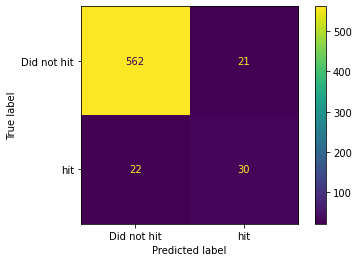

In [73]:
plot_confusion_matrix(clf_xgb2,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=["Did not hit","hit"])

In [74]:
X.columns

Index(['rb?', 'te?', 'age', 'max_pts', 'avg_pts', 'last_pts',
       '3_yr_trail_avg_fppg', 'injury_risk', 'last_yr_games_played',
       'hit_rate', 'Draft Pick', 'Breakout Age', 'cdr'],
      dtype='object')

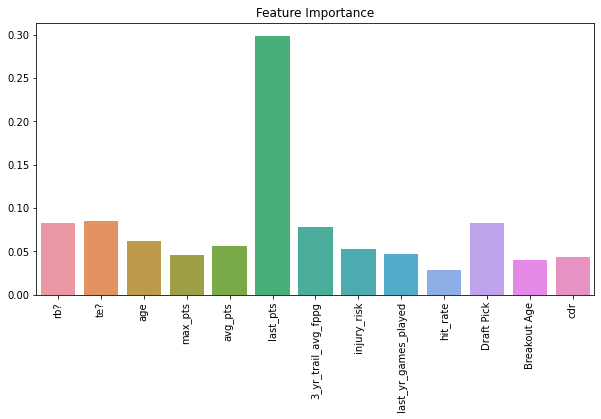

In [75]:
features = ['rb?', 'te?', 'age', 'max_pts', 'avg_pts', 'last_pts',
       '3_yr_trail_avg_fppg', 'injury_risk', 'last_yr_games_played',
       'hit_rate', 'Draft Pick', 'Breakout Age', 'cdr']
f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=features, y=clf_xgb2.feature_importances_)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()

## Score 2022

In [76]:
df_2022_X = df_2022_X.drop(columns=['id'])

In [77]:
j_scores_2022 = pd.DataFrame(clf_xgb2.predict_proba(df_2022_X)).set_index(df_2022_X_id['id']).sort_values(
    1, axis=0, ascending=False)
j_scores_2022.to_csv('j_scores_2022_hermes.csv')

In [78]:
j_scores_2022.head(10)

,0,1
id,,
Tyreek Hill,0.045203,0.954797
Jonathan Taylor,0.061894,0.938106
Tyler Lockett,0.063091,0.936909
Davante Adams,0.063098,0.936902
Alvin Kamara,0.065588,0.934412
Joe Mixon,0.067401,0.932599
Ja'Marr Chase,0.068335,0.931665
Justin Jefferson,0.068335,0.931665
Mark Andrews,0.072100,0.927900


In [79]:
rb_adp = pd.read_csv('rb_adp.csv')
wr_adp = pd.read_csv('wr_adp.csv')
te_adp = pd.read_csv('te_adp.csv')

adp_df = rb_adp.append(wr_adp.append(te_adp))
adp_df

,Full Name,Position,ADP
0,A.J. Dillon,RB,72.1
1,Aaron Green,RB,-
2,Aaron Jones,RB,19.7
3,Aaron Ripkowski,RB,-
4,Abram Smith,RB,215.8
...,...,...,...
499,Zach Ertz,TE,109.8
500,Zach Gentry,TE,216
501,Zach Miller,TE,-
502,Zach Miller,TE,-


In [80]:
winner_df = j_scores_2022.reset_index().merge(adp_df[['Full Name','ADP']], left_on='id',right_on='Full Name')
winner_df.to_csv('winner_df_3.0.csv')

In [81]:
df_2022_id.to_csv('df_2022_id.csv')

## Backtest

### 2021

In [82]:
X_2021 = df_2021.drop(columns=['y'])
X_2021

,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate,Draft Pick,Breakout Age,cdr
0,1,0,23.1,40.2996,40.299600,40.2996,3.663600,0.687500,11.0,0.000000,2.30,19.3,34.8
1,1,0,26.5,315.2000,206.425150,258.9006,17.497633,0.850000,14.0,0.500000,5.39,18.8,47.0
3,1,0,36.2,260.8000,117.199886,124.4992,9.793733,0.718750,16.0,0.142857,1.07,19.5,42.7
8,1,0,26.8,171.0000,84.274975,21.0999,8.966650,0.578125,3.0,0.000000,5.34,19.0,29.9
9,1,0,22.9,86.8998,77.899900,86.8998,5.992300,0.812500,13.0,0.000000,3.38,19.2,28.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242,0,1,28.4,161.0000,88.080100,128.2005,8.248900,0.864583,15.0,0.000000,4.12,22.7,15.6
1243,0,1,28.6,124.5000,40.216667,41.9000,2.596667,0.562500,10.0,0.000000,3.21,20.9,11.5
1248,0,1,24.9,73.8000,56.833600,61.1008,8.339600,0.500000,16.0,0.000000,4.20,NaN,10.3
1251,0,1,30.5,280.0000,181.700071,77.5005,12.915167,0.906250,11.0,0.428571,2.03,21.8,31.8


In [83]:
id_2021 = full_data[['Full Name','Fantasy Points Per Game (2021)']].dropna(subset=['Fantasy Points Per Game (2021)'])
id_2021

,Full Name,Fantasy Points Per Game (2021)
0,A.J. Dillon,10.9176
1,Aaron Jones,15.2667
3,Adrian Peterson,6.6500
8,Alex Collins,6.2545
9,Alexander Mattison,7.8688
...,...,...
1242,Tyler Higbee,9.8000
1243,Tyler Kroft,4.3667
1248,Will Dissly,3.3400
1251,Zach Ertz,10.6294


In [84]:
j_scores_2021 = pd.DataFrame(clf_xgb2.predict_proba(X_2021)).set_index(id_2021['Full Name']).sort_values(
    1, axis=0, ascending=False)
j_scores_2021 = j_scores_2021.reset_index().merge(fp_2021[['Full Name','fpts_2021']],on='Full Name',how='left')
j_scores_2021.to_csv('j_scores_2021_hermes.csv')
j_scores_2021.head(20)

,Full Name,0,1,fpts_2021
0,Alvin Kamara,0.035451,0.964549,234.6994
1,Tyreek Hill,0.045203,0.954797,296.5004
2,Tyler Lockett,0.046319,0.953681,241.4000
3,D.K. Metcalf,0.060689,0.939311,244.3002
4,Dalvin Cook,0.071228,0.928772,206.2996
5,Davante Adams,0.073678,0.926322,344.3008
6,Cooper Kupp,0.075634,0.924366,439.4993
7,Stefon Diggs,0.084881,0.915119,285.4997
8,Josh Jacobs,0.093387,0.906613,226.0005
9,Antonio Gibson,0.096841,0.903159,229.1008


In [85]:
j_scores_2021_check = j_scores_2021.reset_index()
j_scores_2021_check

,index,Full Name,0,1,fpts_2021
0,0,Alvin Kamara,0.035451,0.964549,234.6994
1,1,Tyreek Hill,0.045203,0.954797,296.5004
2,2,Tyler Lockett,0.046319,0.953681,241.4000
3,3,D.K. Metcalf,0.060689,0.939311,244.3002
4,4,Dalvin Cook,0.071228,0.928772,206.2996
...,...,...,...,...,...
551,551,Chris Myarick,0.998852,0.001148,10.7000
552,552,Daniel Helm,0.998852,0.001148,0.9000
553,553,Colin Thompson,0.998852,0.001148,0.0000
554,554,Marcus Kemp,0.998900,0.001100,4.4000


In [86]:
X_2020 = df_2020.drop(columns=['y'])
X_2020

id_2020 = full_data[['Full Name','Fantasy Points Per Game (2020)']].dropna(subset=['Fantasy Points Per Game (2020)'])
id_2020

j_scores_2020 = pd.DataFrame(clf_xgb2.predict_proba(X_2020)).set_index(id_2020['Full Name']).sort_values(
    1, axis=0, ascending=False)
j_scores_2020 = j_scores_2020.reset_index().merge(fp_2020[['Full Name','fpts_2020']],on='Full Name',how='left')
j_scores_2020.to_csv('j_scores_2020_hermes.csv')

j_scores_2020.head(20)

,Full Name,0,1,fpts_2020
0,Alvin Kamara,0.055432,0.944568,377.8005
1,Keenan Allen,0.057012,0.942988,245.0994
2,Tyler Lockett,0.085828,0.914172,265.4000
3,Cooper Kupp,0.093175,0.906825,208.6995
4,D.J. Moore,0.098441,0.901559,211.5000
5,Nick Chubb,0.099058,0.900942,207.6996
6,Travis Kelce,0.101274,0.898726,312.7605
7,Amari Cooper,0.102683,0.897317,236.8000
8,Ezekiel Elliott,0.106575,0.893425,223.6995
9,Aaron Jones,0.108059,0.891941,258.9006


In [87]:
X_2019 = df_2019.drop(columns=['y'])
X_2019

id_2019 = full_data[['Full Name','Fantasy Points Per Game (2019)']].dropna(subset=['Fantasy Points Per Game (2019)'])
id_2019

j_scores_2019 = pd.DataFrame(clf_xgb2.predict_proba(X_2019)).set_index(id_2019['Full Name']).sort_values(
    1, axis=0, ascending=False)
j_scores_2019 = j_scores_2019.reset_index().merge(fp_2019[['Full Name','fpts_2019']],on='Full Name',how='left')
j_scores_2019.to_csv('j_scores_2019_hermes.csv')

j_scores_2019.head(20)

,Full Name,0,1,fpts_2019
0,Alvin Kamara,0.030951,0.969049,249.2
1,Tyreek Hill,0.045203,0.954797,188.4
2,Stefon Diggs,0.063516,0.936484,214.5
3,Travis Kelce,0.068677,0.931323,254.4
4,Julio Jones,0.071146,0.928854,274.5
5,Mike Evans,0.071174,0.928826,230.1
6,DeAndre Hopkins,0.081997,0.918003,267.0
7,Joe Mixon,0.083535,0.916465,225.6
8,Keenan Allen,0.095404,0.904596,260.8
9,Michael Thomas,0.100316,0.899684,374.4


In [88]:
X_2018 = df_2018.drop(columns=['y'])
X_2018

id_2018 = full_data[['Full Name','Fantasy Points Per Game (2018)']].dropna(subset=['Fantasy Points Per Game (2018)'])
id_2018

j_scores_2018 = pd.DataFrame(clf_xgb2.predict_proba(X_2018)).set_index(id_2018['Full Name']).sort_values(
    1, axis=0, ascending=False)
j_scores_2018 = j_scores_2018.reset_index().merge(fp_2018[['Full Name','fpts_2018']],on='Full Name',how='left')
j_scores_2018.to_csv('j_scores_2018_hermes.csv')

j_scores_2018.head(20)

,Full Name,0,1,fpts_2018
0,Alvin Kamara,0.037445,0.962555,348.0
1,Travis Kelce,0.050379,0.949621,294.4
2,DeAndre Hopkins,0.071174,0.928826,332.8
3,Tyreek Hill,0.077828,0.922172,328.0
4,Kareem Hunt,0.082766,0.917234,229.9
5,Michael Thomas,0.100316,0.899684,315.2
6,Keenan Allen,0.107493,0.892507,258.0
7,Antonio Brown,0.108884,0.891116,324.0
8,Brandin Cooks,0.114339,0.885661,243.0
9,Melvin Gordon,0.128858,0.871142,271.2


In [89]:
X_2017 = df_2017.drop(columns=['y'])
X_2017

id_2017 = full_data[['Full Name','Fantasy Points Per Game (2017)']].dropna(subset=['Fantasy Points Per Game (2017)'])
id_2017

j_scores_2017 = pd.DataFrame(clf_xgb2.predict_proba(X_2017)).set_index(id_2017['Full Name']).sort_values(
    1, axis=0, ascending=False)
j_scores_2017 = j_scores_2017.reset_index().merge(fp_2017[['Full Name','fpts_2017']],on='Full Name',how='left')
j_scores_2017.to_csv('j_scores_2017_hermes.csv')

j_scores_2017.head(20)

,Full Name,0,1,fpts_2017
0,Odell Beckham,0.063878,0.936122,74.0
1,Mike Evans,0.081034,0.918966,201.0
2,Travis Kelce,0.083741,0.916259,234.0
3,Devonta Freeman,0.090445,0.909555,200.2
4,Le'Veon Bell,0.092330,0.907670,342.0
5,Ezekiel Elliott,0.093142,0.906858,203.0
6,Brandin Cooks,0.096166,0.903834,219.2
7,Adam Thielen,0.098591,0.901409,240.0
8,DeAndre Hopkins,0.101749,0.898251,310.5
9,Antonio Brown,0.108884,0.891116,308.0


[CV] END gamma=1.5, learning_rate=0.15, max_depth=4, reg_lambda=0, scale_pos_weight=4; total time=   1.1s
[CV] END gamma=1.5, learning_rate=0.2, max_depth=4, reg_lambda=0, scale_pos_weight=2; total time=   1.0s
[CV] END gamma=1.5, learning_rate=0.15, max_depth=4, reg_lambda=0, scale_pos_weight=4; total time=   1.2s
[CV] END gamma=1.5, learning_rate=0.15, max_depth=4, reg_lambda=0, scale_pos_weight=4; total time=   1.1s
[CV] END gamma=1.5, learning_rate=0.2, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   0.7s
[CV] END gamma=1.5, learning_rate=0.2, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   1.0s
[CV] END gamma=1.5, learning_rate=0.2, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   0.7s
[CV] END gamma=1.5, learning_rate=0.2, max_depth=4, reg_lambda=0, scale_pos_weight=4; total time=   0.5s
[CV] END gamma=1.5, learning_rate=0.2, max_depth=4, reg_lambda=0, scale_pos_weight=4; total time=   0.5s
[CV] END gamma=1.5, learning_rate=0.2, max_depth=4, 